### Preparations

In [1]:
### Importing Matplotlib (cannot be repeated in a Kernel)
#%matplotlib notebook
#%matplotlib inline
import matplotlib
#matplotlib.use("Agg")
#matplotlib.use('ps')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib._color_data as mcd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset,TransformedBbox, BboxPatch, BboxConnector

In [2]:
### Importing Other Packages

from matplotlib import animation
from jupyterthemes import jtplot
import numpy as np
import math
from scipy import stats
from scipy.stats import skewnorm
import pandas as pd
import netCDF4 as nc4
from netCDF4 import Dataset
from netCDF4 import num2date
import pickle
import datetime
import sys
sys.path.append('../misc')
#from nc_dump import ncdump
from nc_dump import ncdump
import os
import time
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import importlib

#my scripts:
import tools_plot as jplt
importlib.reload(jplt) 
import tools_analysis as jan
importlib.reload(jan) 
# #my scripts:
# import tools_plot as jplt
# reload(jplt) 
# import tools_analysis as jan
# reload(jan)  
%matplotlib inline
#matplotlib notebook
#plt.style.use('dark_background')
#jtplot.style(theme='onedork')
#jtplot.reset()
%load_ext ferretmagic
import csv
import scipy.stats as stats
from scipy.stats import truncnorm
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from scipy.optimize import fsolve

In [3]:
sys.path

['/p/projects/ace/janlandw/publication_TrJu/plots',
 '/p/system/packages/intel/parallel_studio_xe_2017_update4/advisor_2017.1.3.510716/pythonapi',
 '/home/janlandw/.conda/envs/py3_jan/lib/python37.zip',
 '/home/janlandw/.conda/envs/py3_jan/lib/python3.7',
 '/home/janlandw/.conda/envs/py3_jan/lib/python3.7/lib-dynload',
 '',
 '/home/janlandw/.conda/envs/py3_jan/lib/python3.7/site-packages',
 '/home/janlandw/.conda/envs/py3_jan/lib/python3.7/site-packages/IPython/extensions',
 '/home/janlandw/.ipython',
 '../misc']

In [4]:
### Defining some Functions for Reading nc-files and Plotting
def read_hist(path, hist_name, var_name, mean_opt=''):
        nc_f = '../climber/'+path+'/'+hist_name+'.nc'
        nc_fid = Dataset(nc_f, 'r')
        #nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
        if var_name=='ts_ann':
            var=nc_fid.variables[var_name][:,::-1,:]
        if var_name=='pco2diag':
            var=nc_fid.variables[var_name][:]
        if mean_opt=='global':
            var=jan.global_mean(var)
        times=np.arange(0,len(var),1)
        return var, times

def read_file(path):
    nc_f = '../'+path+'/tmp/history_p2.nc'
    nc_fid = Dataset(nc_f, 'r')
    #nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
    ts_ann=jan.global_mean(nc_fid.variables['ts_ann'][:,::-1,:])
    times_ts=np.arange(0,len(ts_ann),1)
    timesincemod=time.time()-os.stat('../'+path+'/tmp/history.nc').st_mtime
    year=str(len(nc_fid.variables['ts_ann'][:,0,0]))
    status=[]
    if timesincemod<1800:
        status=' (running)'    
    else:
        status=' (stopped)'
    if path in paths_pulse_failed:
        status=' (failed)'
    elif path in paths_pulse_failed_13c:
        status= status+ '(13C failed)'        
#    if os.path.islink('../'+path+'/.workdir_locked_by_batchjob'):
#        status=' (running)'
#    else:
#        status=' '  
    return times_ts, ts_ann, status, year

def plot_paths(ax_sel='', path_list='', xlims='', ylims='', statuslab='on'):
    ax_sel.grid(linestyle=':', zorder=0)
    for path in path_list:
        times_ts, ts_ann, status, year=read_file(path)
        if statuslab=='on':
            labelstr=path+status+'(yr'+year+')'
        elif statuslab=='off':
            labelstr=path
        ax_sel.plot(times_ts,ts_ann, '-',lw=1, c=colors_df.loc[path, 'color'] ,label=labelstr, alpha=0.8)
    if xlims!='':
        ax_sel.set_xlim(xlims)
    if ylims!='':
        ax_sel.set_ylim(ylims)
    ax_sel.legend(loc='lower right',ncol=2, fontsize='x-small')
    ax_sel.set_xlabel('Time (years)');
    ax_sel.set_ylabel(r'ts_ann (${\circ}C$)')
    plt.tight_layout()
    
### Function for reading Snapshots-Timeseries and store them in pickle-File
def read_allsnapshotsmom(var='', scenario='', paths=''):

    #scenario='long'
    #var='dp13'

#     if scenario=='short':
#         #paths_snapts=paths_pulse_control+paths_pulse_c_short
#         paths_snapts=paths_pulse_control+paths_pulse_c_short+paths_pulse_c_short_extra_13c+paths_pulse_cs_short+paths_pulse_s_short
#         #+paths_pulse_failed
#     elif scenario=='long':
#         paths_snapts=paths_pulse_long

    var_ts_dfs=pd.DataFrame([], columns=[var+'_ts_globmean', 'years'], index=paths) #, dtype=float[], columns=['dp13_ts_globmean', 'years'], index=[]

    for i in range(len(paths)): #_snapts
        path=paths[i] #paths_snapts[i]
        
#         if path in paths_pulse_control+paths_pulse_c_long+paths_pulse_cs_long:
#             sbx_range=1
#         else:
#             sbx_range=10
#         %ferret_run 'cancel data/all; define symbol path = %(path)s; use "../$path/TIMERES/all_snapshots_mom_annual.nc"; \
#                 let a=ph[i=@ave,j=@ave,k=1,l=@sbx:%(sbx_range)s]; let ph_mean_min_f=a[l=@min]-a[l=1]' % locals()
#         %ferret_getdata ph_mean_min_f=ph_mean_min_f
#         var_ts_dfs.loc[path, 'ph_mean_min']=ph_mean_min_f['data'] 
        
        nc_f = '../'+path+'/TIMERES/all_snapshots_mom_annual.nc'
        nc_fid = Dataset(nc_f, 'r')
        #nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
        var_ts=nc_fid.variables[var][:,0,::-1,:]
        var_ts_globmean=jan.global_mean(var_ts, grid='ocean') #, restrict_lat='yes'

        #exclude southpole using ferret for averaging
        #%ferret_run 'define symbol path = %(path)s '
        #%ferret_run 'use "../$path/TIMERES/all_snapshots_mom_annual.nc"'
        #%ferret_run 'let var_fer=dp13[i=@ave,y=75S:90N@ave,k=1]'
        #%ferret_getdata var_dict = var_fer
        #var_nested=var_dict['data']
        #dp13_ts_globmean=var_nested.flatten()

        dates=num2date(nc_fid.variables['Time'][:], units=nc_fid.variables['Time'].units, calendar=nc_fid.variables['Time'].calendar)
        years_strings=[time.strftime('%Y') for time in dates]
        years=np.array(list(map(int,years_strings)))
        #times=[time.timetuple().tm_year for time in test]

        var_ts_dfs.loc[path, [var+'_ts_globmean','years'] ]= [var_ts_globmean,years]

    var_ts_dfs.to_pickle('./'+var+'_ts_'+scenario+'_corr.pkl')
    #return var_ts_dfs
    # if scenario=='short':
    #     dp13_ts_dfs.to_pickle('./dp13_ts.pkl')
    # elif scenario=='long':
    #     dp13_ts_dfs.to_pickle('./dp13_ts_long.pkl')


In [5]:
# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
# loc1, loc2 : {1, 2, 3, 4} 
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

In [6]:
### Listing and Grouping the Pulse-Runs/Paths 

paths_pulse_control=[
       'pulse_control_1000ppm',
       'pulse_control_1500ppm',
       'pulse_control_2000ppm']

paths_pulse_c_short_base=[
       'pulse_c_1000ppm_5300GtC_5ka', 
       'pulse_c_1500ppm_2500GtC_5ka',
       'pulse_c_1500ppm_5300GtC_5ka',
       'pulse_c_1500ppm_7500GtC_5ka',     
       'pulse_c_2000ppm_5300GtC_5ka']
paths_pulse_c_short_extra_13c=[
       'pulse_c_1500ppm_5300GtC_5ka_13d13C',
       'pulse_c_1500ppm_5300GtC_5ka_40d13C']
paths_pulse_c_short_extra_Eppley=[    
       'pulse_c_1500ppm_5300GtC_5ka_Eppley',
       'pulse_c_1500ppm_7500GtC_5ka_Eppley']
paths_pulse_c_long=['pulse_c_1500ppm_5300GtC_12ka']
paths_pulse_c_short=paths_pulse_c_short_base+paths_pulse_c_short_extra_13c+paths_pulse_c_short_extra_Eppley
paths_pulse_c=paths_pulse_c_short+paths_pulse_c_long

paths_pulse_s_short=[
        'pulse_rev_s_1500ppm_125GtS_5ka']
paths_pulse_s_long=[]
paths_pulse_s_failed=[ ]
paths_pulse_s_failed_13c=[]
paths_pulse_s=paths_pulse_s_short+paths_pulse_s_long+paths_pulse_s_failed

paths_pulse_cs_short=[
        'pulse_rev_cs_1000ppm_5300GtC_125GtS_5ka',
        'pulse_rev_cs_1500ppm_5300GtC_10GtS_5ka_sparse',
        'pulse_rev_cs_1500ppm_5300GtC_50GtS_5ka',    
        'pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka',
        'pulse_rev_cs_1500ppm_5300GtC_250GtS_5ka',
        'pulse_rev_cs_1500ppm_5300GtC_500GtS_5ka',
        'pulse_rev_cs_2000ppm_5300GtC_125GtS_5ka']
paths_pulse_cs_long=[
        'pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka',
        'pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka',
        'pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka']
paths_pulse_cs_failed=['pulse_rev_cs_1500ppm_5300GtC_600GtS_5ka'] 
paths_pulse_cs_irreg=[
        ]
        #those two did not break, but show an anomalous bend in the pCO2 curve and anomalous
paths_pulse_cs_failed_13c=[]
paths_pulse_cs=paths_pulse_cs_short+paths_pulse_cs_long+paths_pulse_cs_failed

paths_pulse_s_single=[       
       'pulse_rev_s_single_1500ppm_9MtS',
       'pulse_rev_s_single_1500ppm_50MtS',
       'pulse_rev_s_single_1500ppm_100MtS',
       'pulse_rev_s_single_1500ppm_200MtS',
       'pulse_rev_s_single_1500ppm_250MtS',
       'pulse_rev_s_single_1500ppm_500MtS',
       'pulse_rev_s_single_1500ppm_1000MtS']
#'pulse_corr_s_single_1000ppm_250MtS',
#'pulse_corr_s_single_2000ppm_250MtS'

paths_pulse_failed=paths_pulse_s_failed+paths_pulse_cs_failed
paths_pulse_failed_13c=paths_pulse_cs_failed_13c+paths_pulse_s_failed_13c

paths_pulse_long=paths_pulse_control+paths_pulse_c_long+paths_pulse_s_long+paths_pulse_cs_long
paths_pulse=paths_pulse_control+paths_pulse_c+paths_pulse_s+paths_pulse_cs

# paths_nobiogeo=['c3beta_tria_200Ma_700ppm','c3beta_tria_200Ma_1000ppm', 'c3beta_tria_200Ma_1500ppm', 
#       'c3beta_tria_200Ma_2000ppm', 'c3beta_tria_200Ma_3000ppm', 'c3beta_tria_200Ma_4000ppm']
paths_nobiogeo=['c3beta_tria_200Ma_1000ppm', 'c3beta_tria_200Ma_1500ppm', 
      'c3beta_tria_200Ma_2000ppm']

paths_all=paths_nobiogeo+paths_pulse

paths_paper=['pulse_control_1500ppm',
            'pulse_c_1000ppm_5300GtC_5ka', 
            'pulse_c_1500ppm_5300GtC_5ka',    
            'pulse_c_2000ppm_5300GtC_5ka',
            'pulse_c_1500ppm_5300GtC_12ka',
            'pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka',   
            'pulse_corr_cs_1500ppm_5300GtC_125GtS_12ka']
    


In [7]:
###Colour list
color_dict=mcd.TABLEAU_COLORS #XKCD_COLORS
color_list=list(color_dict.keys())[:]*5
colors_df=pd.DataFrame([], columns=['color'], index=paths_all+paths_pulse_s_single)
colors_df.iloc[:,0]=color_list[0:len(paths_all+paths_pulse_s_single)] #color_list[0:37]
colors_df.loc['pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka', 'color']='tab:purple'

colors_paper_df=pd.DataFrame([], columns=['color'], index=paths_paper)
colors_paper_df.loc['pulse_control_1500ppm', 'color']='tab:grey'
colors_paper_df.loc['pulse_c_1000ppm_5300GtC_5ka', 'color']='tab:cyan'
colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color']='tab:green'
colors_paper_df.loc['pulse_c_1500ppm_7500GtC_5ka', 'color']='tab:brown'
colors_paper_df.loc['pulse_c_2000ppm_5300GtC_5ka', 'color']='darkorange'
colors_paper_df.loc['pulse_c_1500ppm_5300GtC_12ka', 'color']='tab:blue'
colors_paper_df.loc['pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka', 'color']=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color']
colors_paper_df.loc['pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka', 'color']=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_12ka', 'color']

In [8]:
times=np.arange(1,12501,1)

In [9]:
#Generate continental mask and store it
nc_f = '../climber/c3beta_tria_200Ma_1500ppm/snapshots.004002.01.01.dta.nc'  
nc_fid = Dataset(nc_f, 'r')  
#nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
temp = np.flipud(nc_fid.variables['temp'][0,0,:,:])
mask=np.empty([48,96])
mask[np.where(temp > -1000)]=1
mask[np.where(temp < -1000)]=0
with open('../climber/continental_mask.pickle', 'wb') as f:  
   pickle.dump(mask, f)
with open('../climber/continental_mask.pickle', 'rb') as f:  
   continental_mask = pickle.load(f, encoding='latin1')

### Fig. S3: Aerosol Forcing

In [13]:
%ferret_run 'cancel data/all; use "../emission_scenarios/examples/aod_multi_1200y_125GtS_250MtS_rev_0p1.nc"; \
    let aod_1yr_zonal_mean_f=aod550[j=@ave,l=1:60000:12@ave]; let aod_10yr_f=aod550[l=1:60000:120@ave]; let aod_10yr_zonal_mean_f=aod550[j=@ave,l=1:60000:120@ave]' % locals()  #,l=@sbx:100

%ferret_getdata aod_10yr_f=aod_10yr_f
%ferret_getdata aod_10yr_zonal_mean_f=aod_10yr_zonal_mean_f
%ferret_getdata aod_1yr_zonal_mean_f=aod_1yr_zonal_mean_f

aod_10yr=aod_10yr_f['data'][0,:,0,:,0,0]; 
aod_10yr_zonal_mean=aod_10yr_zonal_mean_f['data'][0,0,0,:,0,0]; 
aod_1yr_zonal_mean=aod_1yr_zonal_mean_f['data'][0,0,0,:,0,0]; 

Message: aod_10yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: aod_10yr_zonal_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: aod_1yr_zonal_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

In [14]:
%ferret_run 'cancel data/all; use "../emission_scenarios/examples/aod_multi_1200y_125GtS_250MtS_rev_0p1.nc"; \
    let aod_1yr_zonal_mean_f=aod550[j=@ave,l=1:60000:12@ave]' % locals()  #,l=@sbx:100

%ferret_getdata aod_1yr_zonal_mean_f=aod_1yr_zonal_mean_f

aod_1yr_zonal_mean=aod_1yr_zonal_mean_f['data'][0,0,0,:,0,0]; 

Message: aod_1yr_zonal_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

In [15]:
nc_f = '../emission_scenarios/examples/eruptions_multi_1200y_125GtS_250MtS.nc'
nc_fid = Dataset(nc_f, 'r')
injs=nc_fid.variables['ssi'][:] 
injs_yrs=nc_fid.variables['year'][:] 
years=np.arange(1,5000+1,1)

window=10 #years
n_10yr=np.empty(len(years)-window)
ssi_10yr=np.empty(len(years)-window)
for i in range(len(n_10yr)):
    n_10yr[i]=len(injs_yrs[abs(injs_yrs-years[i+int(1./2*window-1)]) <= 1./2*window-1]) 
    ssi_10yr[i]=np.sum(injs[abs(injs_yrs-years[i+int(1./2*window-1)]) <= 1./2*window-1])


In [16]:
%ferret_run 'cancel data/all; use "../emission_scenarios/examples/aod_single_250MtS_rev_0p1.nc"; \
    let aod_single_f=aod550[j=@ave]; let rad_forcing_single_f=21*aod550[j=@ave,l=1:1200:12@ave]' % locals()  #,l=@sbx:100

%ferret_getdata aod_single_f=aod_single_f
%ferret_getdata rad_forcing_single_f=rad_forcing_single_f

aod_single=aod_single_f['data'][0,0,0,:,0,0]; 
rad_forcing_single=rad_forcing_single_f['data'][0,0,0,:,0,0]; 

Message: aod_single_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: rad_forcing_single_f is now available in python as a dictionary containing the variable's metadata and data array.

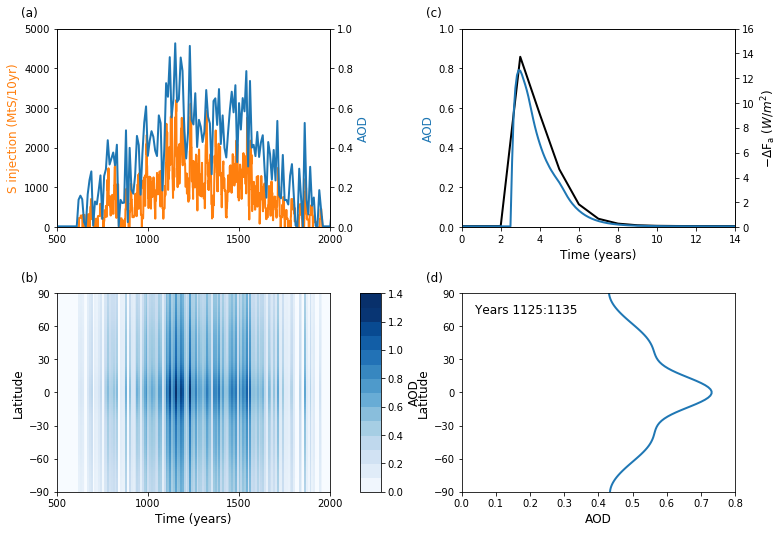

In [17]:
fig=plt.figure(figsize=(11,7.5))
plt.clf()
gs = GridSpec(2,4,height_ratios=[1,1], width_ratios=[1,0.075,0.075,1])


ax_1_0 = plt.subplot(gs[1,0])
ax_0_0_1 = plt.subplot(gs[0,0], sharex=ax_1_0)
ax_0_0=ax_0_0_1.twinx()
ax_0_2 = plt.subplot(gs[0,3])
ax_0_2.set_zorder(10)
ax_0_2.patch.set_visible(False)
ax_0_2_1 = ax_0_2.twinx()

ax_1_1 = plt.subplot(gs[1,1])
ax_1_2 = plt.subplot(gs[1,3])#, ymargin=5
#ax11 = plt.subplot(gs[:-1,1]) #sharey=ax1

lats_eva=np.linspace(-90,90,aod_10yr.shape[0]) 
times_1yr_eva=np.arange(0,aod_1yr_zonal_mean.shape[0],1)
times_10yr_eva=np.arange(0,aod_10yr.shape[1],1)
x,y = np.meshgrid(times_10yr_eva, lats_eva)

#ax_0_0.plot(times_1yr_eva,aod_1yr_zonal_mean)
ax_0_0.plot(times_10yr_eva,aod_10yr_zonal_mean,lw=2)
ax_0_0.set_ylim(0,1)
ax_0_0.set_ylabel('AOD',fontsize=12, color='tab:blue')
ax_0_0_1.plot(years[10:]/10,ssi_10yr,c='tab:orange',lw=2)
ax_0_0_1.set_ylim(0,5000)
ax_0_0_1.set_ylabel('S injection (MtS/10yr)',fontsize=12, color='tab:orange')

ax_0_2.plot(np.arange(0,100,1./12),aod_single,c='tab:blue',lw=2)
ax_0_2.set_xlim(0,14)
ax_0_2.set_ylim(0,1)
ax_0_2.set_xlabel('Time (years)',fontsize=12)
ax_0_2.set_ylabel('AOD',color='tab:blue',fontsize=12)
ax_0_2_1.plot(np.arange(0,100,1),rad_forcing_single,c='k',lw=2)
ax_0_2_1.set_ylabel('$\mathsf{-\Delta F_a}$ ($W/m^2$)',color='k',fontsize=12)
ax_0_2_1.set_ylim(0,16)

aod_pcolor=ax_1_0.pcolor(x,y,aod_10yr,cmap='Blues')
#ax_1_0.set_ylim(-90,90)
ax_1_0.set_xlim(50,200)
ax_1_0.set_xticks([50,100,150,200]);
ax_1_0.set_xticklabels([500,1000,1500,2000]);
ax_1_0.set_yticks([-90,-60,-30,0,30,60,90]);
ax_1_0.set_xlabel('Time (years)',fontsize=12)
ax_1_0.set_ylabel('Latitude',fontsize=12)
#cbar=fig.colorbar(aod_pcolor,ax=ax_1_0, orientation='vertical')
cbar=fig.colorbar(mappable=aod_pcolor, cax=ax_1_1, orientation='vertical', boundaries=np.arange(0,1.5,0.1))
cbar.ax.tick_params(labelsize=10);
cbar.set_label(r'AOD', fontsize=12)
#ax_1_2.plot(np.average(aod[:,50:200],axis=1),lats_eva)
ax_1_2.plot(aod_10yr[:,113],lats_eva,lw=2)
ax_1_2.set_ylim(-90,90)
ax_1_2.set_xlim(0,0.8)
ax_1_2.set_yticks([-90,-60,-30,0,30,60,90]);
ax_1_2.set_xlabel('AOD',fontsize=12)
ax_1_2.set_ylabel('Latitude',fontsize=12)
ax_1_2.text(0.05,0.9,'Years 1125:1135',transform=ax_1_2.transAxes,fontsize=12)

ax_0_0.text(-0.13,1.06,'(a)',transform=ax_0_0.transAxes,fontsize=12)
ax_0_2.text(-0.13,1.06,'(c)',transform=ax_0_2.transAxes,fontsize=12)
ax_1_0.text(-0.13,1.06,'(b)',transform=ax_1_0.transAxes,fontsize=12)
ax_1_2.text(-0.13,1.06,'(d)',transform=ax_1_2.transAxes,fontsize=12)

plt.tight_layout(w_pad=-1.5) #h_pad=-4.25, w_pad=-2

fig.savefig('./plot_pdf_files/FigS3_eva_forcing_illustration.pdf',bbox_inches='tight', pad_inches=0.05) #, dpi=900


### Fig. S2: Reproducing aerosol forcing scenarios of Schmidt et al. 2016

In [22]:
%ferret_run 'set window/aspect=0.45; cancel data/all; \
            use "../emission_scenarios/examples/aod_schmidt_12000MtS_0p44_10yrs.nc"; \
            use "../emission_scenarios/examples/aod_schmidt_12000MtS_0p44_10yrs_rev_0p1.nc";\
            use "../emission_scenarios/examples/aod_schmidt_60000MtS_0p44_50yrs_rev_0p1.nc";\
            let aod_schmidt_10yr_orig_f=aod550[j=@ave,d=1] ; let aod_schmidt_10yr_orig_ave_f=aod550[j=@ave,l=1:1200:12@ave,d=1] ;\
            let aod_schmidt_10yr_rev_f=aod550[j=@ave,d=2] ; let aod_schmidt_10yr_rev_ave_f=aod550[j=@ave,l=1:1200:12@ave,d=2] ;' % locals()  #,l=@sbx:100

#             set viewport left; plot aod550[j=@ave,d=1]; plot/over aod550[j=@ave,d=2]; plot/over aod550[j=@ave,d=3]; \
#             set viewport right; plot 21*aod550[j=@ave,l=0:360,d=2]; list 21*aod550[j=@ave,l=72:134@ave];\

%ferret_getdata aod_schmidt_10yr_orig_f=aod_schmidt_10yr_orig_f
%ferret_getdata aod_schmidt_10yr_rev_f=aod_schmidt_10yr_rev_f

%ferret_getdata aod_schmidt_10yr_orig_ave_f=aod_schmidt_10yr_orig_ave_f
%ferret_getdata aod_schmidt_10yr_rev_ave_f=aod_schmidt_10yr_rev_ave_f

aod_schmidt_10yr_orig=aod_schmidt_10yr_orig_f['data'][0,0,0,:,0,0]; 
aod_schmidt_10yr_rev=aod_schmidt_10yr_rev_f['data'][0,0,0,:,0,0]; 

aod_schmidt_10yr_orig_ave=aod_schmidt_10yr_orig_ave_f['data'][0,0,0,:,0,0]; 
aod_schmidt_10yr_rev_ave=aod_schmidt_10yr_rev_ave_f['data'][0,0,0,:,0,0]; 

Message: aod_schmidt_10yr_orig_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: aod_schmidt_10yr_rev_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: aod_schmidt_10yr_orig_ave_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: aod_schmidt_10yr_rev_ave_f is now available in python as a dictionary containing the variable's metadata and data array.

In [23]:
%ferret_run 'cancel data/all; \
            use "../climber/pulse_corr_s_schmidt_12000MtS_0p44_10yrs/history_p2.nc";\
            use "../climber/pulse_rev_s_schmidt_12000MtS_0p44_10yrs/history_p2.nc"; \
            use "../climber/pulse_rev_s_schmidt_60000MtS_0p44_50yrs/history_p2.nc"; \
            let tsann_schmidt_10yr_orig_f=ts_ann[i=@ave,j=@ave,l=501:600,d=1];\
            let tsann_schmidt_10yr_rev_f=ts_ann[i=@ave,j=@ave,l=501:600,d=2];\
            let tsann_schmidt_50yr_rev_f=ts_ann[i=@ave,j=@ave,l=501:600,d=3];\
            ' % locals()  #,l=@sbx:100

#             plot ts_ann[i=@ave,j=@ave,l=500:700,d=4]; plot/over ts_ann[i=@ave,j=@ave,l=500:600,d=3]; plot/over ts_ann[i=@ave,j=@ave,l=500:600,d=1]; plot/over ts_ann[i=@ave,j=@ave,l=500:600,d=2];  \
#             list ts_ann[i=@ave,j=@ave,l=@min,d=3]-ts_ann[i=@ave,j=@ave,l=@max,d=3]; \
#             list ts_ann[i=@ave,j=@ave,l=@min,d=2]-ts_ann[i=@ave,j=@ave,l=@max,d=2]; \
#             list ts_ann[i=@ave,j=@ave,l=@min,d=1]-ts_ann[i=@ave,j=@ave,l=@max,d=1]; \

%ferret_getdata tsann_schmidt_10yr_orig_f=tsann_schmidt_10yr_orig_f
%ferret_getdata tsann_schmidt_10yr_rev_f=tsann_schmidt_10yr_rev_f
%ferret_getdata tsann_schmidt_50yr_rev_f=tsann_schmidt_50yr_rev_f

tsann_schmidt_10yr_orig=tsann_schmidt_10yr_orig_f['data'][0,0,0,:,0,0]; 
tsann_schmidt_10yr_rev=tsann_schmidt_10yr_rev_f['data'][0,0,0,:,0,0]; 
tsann_schmidt_50yr_rev=tsann_schmidt_50yr_rev_f['data'][0,0,0,:,0,0]; 

Message: tsann_schmidt_10yr_orig_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: tsann_schmidt_10yr_rev_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: tsann_schmidt_50yr_rev_f is now available in python as a dictionary containing the variable's metadata and data array.

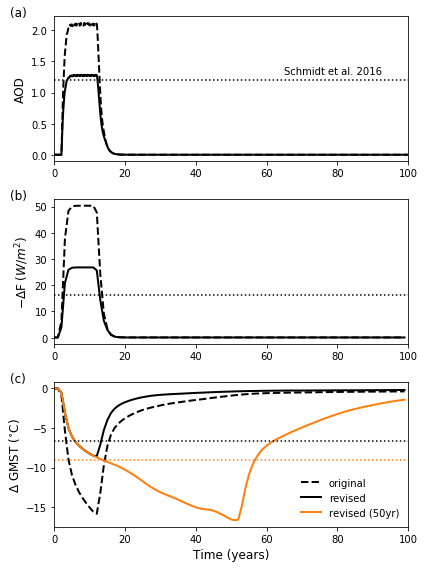

In [24]:
fig=plt.figure(figsize=(6,8))
plt.clf()
gs = GridSpec(3,1) #,height_ratios=[1,1], width_ratios=[1,0.075,0.075,1]

ax2 = plt.subplot(gs[2,0])
ax1 = plt.subplot(gs[1,0],sharex=ax2)
ax0 = plt.subplot(gs[0,0],sharex=ax2)

#ax0.axes.xaxis.set_ticklabels([])
#ax1.axes.xaxis.set_ticklabels([])
#ax0.axes.get_xaxis().set_visible(False)
#ax1.axes.get_xaxis().set_visible(False)


years=np.arange(0,100,1)

ax0.plot(np.arange(0,100,1./12),aod_schmidt_10yr_orig,'k--',lw=2)
ax0.plot(np.arange(0,100,1./12),aod_schmidt_10yr_rev,'k-',lw=2)
ax0.axhline(y=1.2, c='k', linestyle=':')
ax0.text(65,1.3,'Schmidt et al. 2016',fontsize=10)
ax0.set_ylabel('AOD',fontsize=12)


ax1.plot(years,24*aod_schmidt_10yr_orig_ave,'k--',lw=2)
ax1.plot(years,21*aod_schmidt_10yr_rev_ave,'k-',lw=2)
ax1.axhline(y=16.25, c='k', linestyle=':')
ax1.set_ylabel('$-\Delta$F ($W/m^2$)',fontsize=12)

ax2.plot(years,tsann_schmidt_10yr_orig-tsann_schmidt_10yr_orig[0],'k--',lw=2, label='original')
ax2.plot(years,tsann_schmidt_10yr_rev-tsann_schmidt_10yr_rev[0],'k-',lw=2, label='revised')
ax2.plot(years,tsann_schmidt_50yr_rev-tsann_schmidt_50yr_rev[0],'-',c='tab:orange',lw=2, label='revised (50yr)')
ax2.axhline(y=-6.6, c='k', linestyle=':')
ax2.axhline(y=-9, c='tab:orange', linestyle=':')
ax2.set_xlabel('Time (years)',fontsize=12)
ax2.set_ylabel('$\Delta$ GMST ($^{\circ}$C)',fontsize=12)
ax2.legend(frameon=False)
ax2.set_xlim(0,100)

ax0.text(-0.125,1,'(a)',transform=ax0.transAxes,fontsize=12)
ax1.text(-0.125,1,'(b)',transform=ax1.transAxes,fontsize=12)
ax2.text(-0.125,1,'(c)',transform=ax2.transAxes,fontsize=12)


plt.tight_layout() #h_pad=-4.25, w_pad=-2

fig.savefig('./plot_pdf_files/FigS2_forcing_revision.pdf',bbox_inches='tight', pad_inches=0.05) #, dpi=900


### Fig. 1: Pulse Forcings and GMST response timeseries 

In [34]:
### Read ts_ann (from history_p2) and pco2diag (from history) calculate maximal changes and store them to pickle-file

scenario='short'
if scenario=='short':   
    paths=paths_pulse_control+paths_pulse_c_short_base+['pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka','pulse_rev_s_1500ppm_125GtS_5ka']
    #paths=paths_pulse_control+paths_pulse_c_short_base+paths_pulse_cs_short #+paths_pulse_s_short #+paths_pulse_s_short #['pulse_c_1000ppm_5300GtC_5ka']
    
    #+paths_pulse_cs_short_extra
    len_scen=5000
elif scenario=='long':
    paths=paths_pulse_long
    len_scen=10000

ts_anns_minmax=np.empty((len(paths),8))
ts_anns_runmeans=np.empty((len(paths),len_scen))
pco2_minmax=np.empty((len(paths),6))
pco2_runmeans=np.empty((len(paths),len_scen))

for i in range(len(paths)):
    path=paths[i]
    ts_anns, times=read_hist(path, hist_name='history_p2', var_name='ts_ann', mean_opt='global')
    df=pd.DataFrame(ts_anns)
    test=df.rolling(window=100).mean()
    ts_anns_runmean=np.array(test)[:,0]
    ts_anns_runmeans[i,:]=ts_anns_runmean[500:len_scen+500]        

    idx_GtC=path.find('GtC')
    idx_GtS=path.find('GtS')
    idx_ppm=path.find('ppm')
    if path in paths_pulse_control+paths_pulse_s_short+paths_pulse_s_long:
        c_emission=0
    else:
        c_emission=path[idx_GtC-4:idx_GtC]
    if path in paths_pulse_control+paths_pulse_c_short+paths_pulse_c_short_extra_Eppley+paths_pulse_c_long:
        s_injection=0
    elif path in paths_pulse_cs_short+paths_pulse_cs_long:
        #s_injection=path[idx_GtS-3:idx_GtS]
        s_injection=path[idx_GtC+4:idx_GtS]
    elif path in paths_pulse_s_short+paths_pulse_s_long:
        #s_injection=path[idx_GtS-3:idx_GtS]
        s_injection=path[idx_ppm+4:idx_GtS]

    ts_ini=ts_anns_runmean[499]
    ts_end=ts_anns_runmean[len_scen+499]
    ts_min=np.min(ts_anns_runmean[499:len_scen+499])
    ts_max=np.max(ts_anns_runmean[499:len_scen+499])
    ts_diff_warm=ts_max-ts_ini
    ts_diff_cool=ts_min-ts_ini
    ts_anns_minmax[i,:]=[c_emission,s_injection, ts_ini, ts_end, ts_min, ts_max, ts_diff_warm, ts_diff_cool]

    pco2, times=read_hist(path, hist_name='history', var_name='pco2diag')
    #df=pd.DataFrame(pco2)
    #runningmean_window=100
    #test=df.rolling(window=runningmean_window).mean()
    pco2_runmean=pco2[:] #np.array(test)
    pco2_runmeans[i,:]=pco2_runmean[500:len_scen+500]

    pco2_ini=pco2_runmean[499]
    pco2_end=pco2_runmean[len_scen+499]
    pco2_min=np.min(pco2_runmean[499:len_scen+499])
    pco2_max=np.max(pco2_runmean[499:len_scen+499])
    pco2_diff=pco2_max-pco2_ini
    pco2_minmax[i,:]=[c_emission,pco2_ini, pco2_end, pco2_min, pco2_max, pco2_diff]

ppms_nobiogeo=[1000,1500,2000] #700,,3000,4000
ts_anns_nobiogeo=np.empty((len(paths_nobiogeo)))
for i in range(len(paths_nobiogeo)):
    path=paths_nobiogeo[i]
    nc_f = '../climber/'+path+'/history_p2.nc'
    nc_fid = Dataset(nc_f, 'r')
    #nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
    ts_ann=np.mean(jan.global_mean(nc_fid.variables['ts_ann'][-100:-1,::-1,:]), axis=0) 
    ts_anns_nobiogeo[i]=ts_ann

if scenario=='short':
    with open('historyp2_tsann_pco2diag_rev.pickle', 'wb') as f:  
        pickle.dump([ts_anns_minmax, ts_anns_runmeans, pco2_minmax,pco2_runmeans, ts_anns_nobiogeo,ppms_nobiogeo], f)
elif scenario=='long':
    with open('historyp2_long_tsann_pco2diag_rev.pickle', 'wb') as f:  
        pickle.dump([ts_anns_minmax, ts_anns_runmeans, pco2_minmax,pco2_runmeans, ts_anns_nobiogeo,ppms_nobiogeo], f)

In [13]:
#Read out example Temp.-Timeseries

path='pulse_c_1500ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_1500ppm_5300GtC_5ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:,0,0], -1e34)
path='pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
        let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
%ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 
Tcolor='tab:green'
path='pulse_c_1000ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_1000ppm_5300GtC_5ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:,0,0], -1e34)
path='pulse_c_2000ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_2000ppm_5300GtC_5ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:,0,0], -1e34)

path='pulse_rev_cs_1500ppm_5300GtC_10GtS_5ka_sparse'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_f=a' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
ts_ann_pulse_rev_cs_1500ppm_5300GtC_10GtS_5ka_sparse=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)


path='pulse_c_1500ppm_5300GtC_12ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_1500ppm_5300GtC_12ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:10500,0,0], -1e34)
path='pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
        let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
%ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 
Tcolor='tab:purple'
path='pulse_control_1500ppm'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_control_1500ppm=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:10500,0,0], -1e34)



Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_raw_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_raw_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

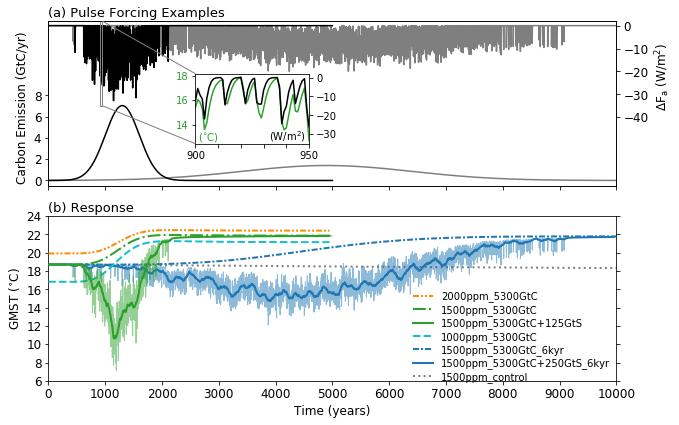

In [15]:
### Example Timeseries for Paper
%matplotlib inline
fig=plt.figure(figsize=(9.5,6))
plt.clf()
ax2=fig.add_subplot(212)
ax1=fig.add_subplot(211,sharex=ax2)

#ax1.grid(linestyle=':', zorder=0)

years=np.arange(1,5001,1)
#filename='../pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka/carbon_emission_1200y_5300GtC.dat'
#years_c, c_rate=np.loadtxt(filename, unpack=True)
#ax2.plot(years,10+c_rate*0.5, '--',c='k',lw=1, zorder=2, label='Forcing (a.u.)')


# paths_forcing_example=['pulse_c_1500ppm_2500GtC_5ka',
#        'pulse_c_1500ppm_5300GtC_5ka',       
#        'pulse_c_1500ppm_7500GtC_5ka',
#        'pulse_corr_cs_1500ppm_2500GtC_125GtS_12ka', 
#        'pulse_c_1500ppm_5300GtC_12ka',
#        'pulse_corr_cs_1500ppm_7500GtC_125GtS_12ka']
labels=['2500GtC_5ka', '5300GtC_5ka', '7500GtC_5ka',
	'2500GtC_12ka','5300GtC_12ka', '7500GtC_12ka']
#ax1.grid(linestyle=':', zorder=0)
paths_forcing_carb_short=['pulse_c_1500ppm_5300GtC_5ka'] #'pulse_c_1500ppm_2500GtC_5ka', , 'pulse_c_1500ppm_7500GtC_5ka'
paths_forcing_carb_long=['pulse_c_1500ppm_5300GtC_12ka'] #'pulse_corr_cs_1500ppm_2500GtC_125GtS_12ka',,'pulse_corr_cs_1500ppm_7500GtC_125GtS_12ka'
for i in range(len(paths_forcing_carb_short)):
    times, c_rate=np.loadtxt('../climber/'+paths_forcing_carb_long[i]+'/c_emission.dat', unpack=True)
    ax1.plot(times, c_rate , '-', c='tab:gray', lw=1.5, label=labels[i]) #+500
    times, c_rate=np.loadtxt('../climber/'+paths_forcing_carb_short[i]+'/c_emission.dat', unpack=True)
    ax1.plot(times, c_rate , '-', c='k', lw=1.5, label=labels[i]) #+500

#ax1.legend(loc='lower right', fontsize='x-small')
#ax1.set_xlabel('Time (years)');
#ax1.set_ylabel(r'c_emission (GtC/y)');
ax1.set_ylabel(r'Carbon Emission (GtC/yr)', fontsize=12);
ax1.yaxis.set_label_coords(0.3, -0.1)
ax1.set_ylim((-0.5,15))
ax1.set_yticks([0,2,4,6,8])
ax1.yaxis.label.set_color('k')
ax1.set_zorder(10)
ax1.patch.set_visible(False)

ax12 = ax1.twinx()
paths_sulf_forcing_short=['pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka'] #'pulse_rev_cs_1500ppm_5300GtC_500GtS_5ka','pulse_rev_cs_1500ppm_5300GtC_250GtS_5ka',
paths_sulf_forcing_long=['pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka'] #'pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka', ,'pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka'
alphas=[1.0] #[0.4,0.7,1.0]
for i in range(len(paths_sulf_forcing_short)):
    times, solar_forced =np.loadtxt('../climber/'+paths_sulf_forcing_long[i]+'/solarv.dat', unpack=True)
    ax12.plot(times, (1339.-solar_forced)*(-0.7/4) , '-', c='tab:gray', lw=1.5, label='125GtS_5ka', alpha=1) #+500    
    times, solar_forced =np.loadtxt('../climber/'+paths_sulf_forcing_short[i]+'/solarv.dat', unpack=True)
    ax12.plot(times, (1339.-solar_forced)*(-0.7/4) , '-', c='k', lw=1.5, label='125GtS_5ka', alpha=1) #+500

#path='pulse_corr_s_1500ppm_125GtS_12ka'
#times, solar_forced =np.loadtxt('../'+path+'/solarv.dat', unpack=True)
#ax12.plot(times, solar_forced , '-', c='tab:purple', lw=2, label='125GtS_12ka', alpha=0.5) #+500
#ax12.legend(loc='upper right', fontsize='x-small')
#ax12.set_ylabel('Forced $S_0$ ($W/m^2$)');
ax12.set_ylabel(r'$\mathsf{\Delta F_a}$ (W/m$\mathsf{^2}$)', fontsize=12);
ax12.set_ylim((-70,2))
ax12.set_yticks([0,-10,-20,-30,-40])
ax12.yaxis.label.set_color('k')
ax12.yaxis.set_label_coords(1.065, 0.66)

times=np.arange(0,5000,1)  

#ax1.plot(times, ts_ann, c=Tcolor, label=path, lw=2)  #color_list[i] , alpha=0.8
ax2.plot(times, ts_ann_pulse_c_2000ppm_5300GtC_5ka, linestyle=(0,(3,1,1,1,1,1)), c=colors_paper_df.loc['pulse_c_2000ppm_5300GtC_5ka', 'color'], label='2000ppm_5300GtC', lw=2, zorder=3)
ax2.plot(times, ts_ann_pulse_c_1500ppm_5300GtC_5ka, '-.', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='1500ppm_5300GtC', lw=2, zorder=4)
ax2.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='1500ppm_5300GtC+125GtS', lw=2, zorder=4)
ax2.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw, c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=1, alpha=0.5, zorder=4)
ax2.plot(times, ts_ann_pulse_c_1000ppm_5300GtC_5ka, linestyle='--', c=colors_paper_df.loc['pulse_c_1000ppm_5300GtC_5ka', 'color'], label='1000ppm_5300GtC', lw=2, zorder=3)

times=np.arange(0,10000,1)  

ll=len(ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka_raw)
#ax1.plot(times, ts_ann, c=Tcolor, label=path, lw=2)  #color_list[i] , alpha=0.8
ax2.plot(times, ts_ann_pulse_c_1500ppm_5300GtC_12ka, linestyle=(0,(3,1,1,1)), c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_12ka', 'color'], label='1500ppm_5300GtC_6kyr', lw=2, zorder=2)
ax2.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka_raw, c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_12ka', 'color'], lw=1, alpha=0.5, zorder=2)
ax2.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka,linestyle='-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_12ka', 'color'], label='1500ppm_5300GtC+250GtS_6kyr', lw=2, zorder=2)
ax2.plot(times, ts_ann_pulse_control_1500ppm, linestyle=':', c=colors_paper_df.loc['pulse_control_1500ppm', 'color'], label='1500ppm_control', lw=2, zorder=1)


times, solar_forced =np.loadtxt('../climber/pulse_rev_s_1500ppm_125GtS_5ka/solarv.dat', unpack=True)
axins2 = inset_axes(ax12, width="100%", height="100%", loc='lower left',bbox_to_anchor=(.25, .225, .2, .425), bbox_transform=ax1.transAxes)
yr_l=900; yr_u=yr_l+50;
axins2.set_zorder(10)
axins2.patch.set_visible(False)
axins21=axins2.twinx()
axins21.plot(times[yr_l:yr_u+1], ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw[yr_l:yr_u+1], '-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=1.5)
axins2.plot(times[yr_l:yr_u+1], (1339.-solar_forced[yr_l:yr_u+1])*(-0.7/4) , '-', c='k', lw=1.5, alpha=1, zorder=10)
mark_inset(ax12, axins2, loc1a=2, loc2a=3, loc1b=1, loc2b=4, fc="none", ec="0.5", zorder=11)
#mark_inset(ax1, axins3, loc1a=2, loc2a=3, loc1b=1, loc2b=4, fc="none", ec="0.75")
axins2.tick_params(axis='y',left=False,right=True,labelleft=False, labelright=True) #, colors='tab:red'
axins21.tick_params(axis='y',left=True,right=False,labelleft=True, labelright=False)
axins2.tick_params(labelsize=10)
#axins2.tick_params(axis='x',labelbottom=False)
axins2.set_xlim([yr_l,yr_u])
axins2.set_ylim((-35,2))
axins2.set_xticks(np.arange(yr_l,yr_u+10,10))
axins2.set_xticklabels([yr_l,'','','','', yr_u])
axins2.set_yticks([0,-10,-20,-30])
#axins2.set_yticklabels(['',1200,'',1300,''])
axins2.yaxis.label.set_color('tab:red')
axins21.set_yticks([14,16,18])
axins21.set_yticklabels([14,16,18])
plt.setp(axins2.get_yticklabels(), color="k")
plt.setp(axins21.get_yticklabels(), color="tab:green")
axins2.text(0.025,0.05,r'$(\mathsf{^{\circ}C})$',fontsize=10, color='tab:green',transform=axins2.transAxes) #,fontweight='bold' , horizontalalignment='center'
axins2.text(0.65,0.05,r'$(\mathsf{W/m^2})$',fontsize=10, color='k',transform=axins2.transAxes) #,fontweight='bold' , horizontalalignment='center'

#ax2.legend(loc='lower right', fontsize=10, ncol=1, labelspacing=0.25, frameon=False)
ax2.legend(bbox_to_anchor=(0.615,-0.034,0.4,0.6),loc='center', fontsize=10, ncol=1, labelspacing=0.25, frameon=False)
#ax2.set_title('Global Mean Temperature in selected scenarios (100yr moving ave.)', fontsize=10);
ax2.set_xlim([0,10000]); 
ax2.set_ylim([7,23]);
ax2.set_xticks(np.arange(0,11000,1000))
ax2.set_yticks(np.arange(6,24+2,2))
ax2.set_xlabel('Time (years)', fontsize=12); 
ax2.set_ylabel(r'GMST ($\mathsf{^{\circ}C}$)', fontsize=12);
ax2.tick_params(labelsize=12)
#ax2.tick_params(labelsize=12)

#ax1.axes.get_xaxis().set_visible(False)
ax1.tick_params(axis='x', direction='out',labelbottom=False)
ax1.tick_params(labelsize=12)
ax12.tick_params(labelsize=12)
ax2.tick_params(axis='y',right=True)

ax1.text(0,1.025,'(a) Pulse Forcing Examples',transform=ax1.transAxes,fontsize=13)
ax2.text(0,1.025,'(b) Response',transform=ax2.transAxes,fontsize=13)
ax1.yaxis.set_label_coords(-0.035, 0.475)
plt.tight_layout() #h_pad=-0.0h_pad=+0.01

fig.savefig('./plot_pdf_files/Fig1_pulse_rev_rev_Forcing_SATTimeseries.pdf',bbox_inches='tight', pad_inches=0.05, dpi=900)


### Fig. 6: Illustration of three pulse cases 

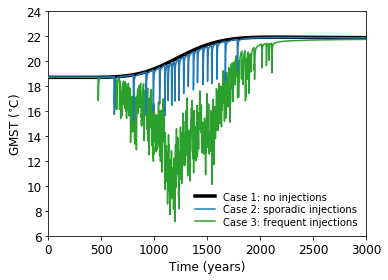

In [43]:
%matplotlib inline
fig=plt.figure(figsize=(5.5,4)) #figsize=(9.5,6)
plt.clf()
ax=fig.add_subplot(111)

times=np.arange(0,5000,1) 

#colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color']
ax.plot(times, ts_ann_pulse_c_1500ppm_5300GtC_5ka, '-', c='k', label='Case 1: no injections', lw=3.5, zorder=3)
ax.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_10GtS_5ka_sparse, '-', c='tab:blue', label='Case 2: sporadic injections', lw=1.5, zorder=6)
#ax.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='Case 3: frequent sulfur injections', lw=2, zorder=4)
ax.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw, c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='Case 3: frequent injections', lw=1.5, alpha=1, zorder=5)

ax.legend(loc='lower right', fontsize=10, ncol=1, labelspacing=0.25, frameon=False)

ax.set_xlabel('Time (years)', fontsize=12); 
ax.set_ylabel(r'GMST ($\mathsf{^{\circ}C}$)', fontsize=12);
ax.tick_params(labelsize=12)
ax.set_ylim(6,24)

ax.set_xlim([0,3000]);

plt.tight_layout(h_pad=-0.1)

fig.savefig('./plot_pdf_files/Fig6_pulse_rev_cases_illustration.pdf',bbox_inches='tight', pad_inches=0.05, dpi=900)

### Fig. 2: Pulse warming and cooling amplitudes

In [44]:
paths_corr_long=['pulse_corr_cs_1500ppm_5300GtC_50GtS_12ka','pulse_corr_cs_1500ppm_5300GtC_125GtS_12ka','pulse_corr_cs_1500ppm_5300GtC_250GtS_12ka']
paths=paths_pulse_c_short_base+paths_pulse_cs_short+paths_pulse_cs_long+paths_pulse_s_single+paths_corr_long
ts_ann_maxchange_df=pd.DataFrame([], columns=['ts_ann','ts_ann_100yr','maxwarm','maxcool'], index=paths) 

for path in paths:
    if path not in paths_pulse_s_single:
        %ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
                    let ts_ann_f=ts_ann[i=@ave,j=@ave]; let ts_ann_100yr_f=ts_ann[i=@ave,j=@ave,l=@sbx:100]' % locals()  
        %ferret_getdata ts_ann_f=ts_ann_f
        %ferret_getdata ts_ann_100yr_f=ts_ann_100yr_f
        ts_ann=np.ma.masked_values(ts_ann_f['data'][0,0,0,:,0,0], -1e34)
        ts_ann_100yr=np.ma.masked_values(ts_ann_100yr_f['data'][0,0,0,:,0,0], -1e34)
        ts_ann_maxchange_df.loc[path, ['ts_ann','ts_ann_100yr','maxwarm','maxcool']]=[ts_ann, ts_ann_100yr, np.max(ts_ann_100yr)-ts_ann_100yr[499], np.min(ts_ann_100yr)-ts_ann_100yr[499]]
    
    if path in paths_pulse_s_single:
        %ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
            let ts_ann_f=ts_ann[i=@ave,j=@ave]' % locals()  
        %ferret_getdata ts_ann_f=ts_ann_f
        ts_ann=np.ma.masked_values(ts_ann_f['data'][0,0,0,:,0,0], -1e34)
        ts_ann_maxchange_df.loc[path, ['ts_ann','maxcool']]=[ts_ann, np.min(ts_ann)-ts_ann[0]]
ts_ann_maxchange_df.to_pickle('./ts_ann_maxchange_df.pkl')    

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_100yr_f is now available in python as a dictionary containing the variable's metadata and data array.

In [140]:
ts_ann_maxchange_df

ts_ann  \
pulse_c_1000ppm_5300GtC_5ka                    [16.85038367554098, 16.84901557841778, 16.8490...   
pulse_c_1500ppm_2500GtC_5ka                    [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_c_1500ppm_5300GtC_5ka                    [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_c_1500ppm_7500GtC_5ka                    [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_c_2000ppm_5300GtC_5ka                    [19.920550604166774, 19.920583598918174, 19.92...   
pulse_rev_cs_1000ppm_5300GtC_125GtS_5ka        [16.85038367554098, 16.84901557841778, 16.8490...   
pulse_rev_cs_1500ppm_5300GtC_10GtS_5ka_sparse  [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_cs_1500ppm_5300GtC_50GtS_5ka         [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka        [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_cs_1500ppm_5300GtC_250GtS_5ka        [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_cs_1500ppm_5300GtC_500GtS_5ka        [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_cs_2000ppm_5300GtC_125GtS_5ka        [19.920550604166774, 19.920583598918174, 19.92...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka       [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka       [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka       [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_s_single_1500ppm_9MtS                [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_s_single_1500ppm_50MtS               [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_s_single_1500ppm_100MtS              [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_s_single_1500ppm_200MtS              [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_s_single_1500ppm_250MtS              [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_s_single_1500ppm_500MtS              [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_rev_s_single_1500ppm_1000MtS             [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_corr_cs_1500ppm_5300GtC_50GtS_12ka       [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_corr_cs_1500ppm_5300GtC_125GtS_12ka      [18.71531715984677, 18.71468980565674, 18.7140...   
pulse_corr_cs_1500ppm_5300GtC_250GtS_12ka      [18.71531715984677, 18.71468980565674, 18.7140...   

                                                                                    ts_ann_100yr  \
pulse_c_1000ppm_5300GtC_5ka                    [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_c_1500ppm_2500GtC_5ka                    [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_c_1500ppm_5300GtC_5ka                    [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_c_1500ppm_7500GtC_5ka                    [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_c_2000ppm_5300GtC_5ka                    [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1000ppm_5300GtC_125GtS_5ka        [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1500ppm_5300GtC_10GtS_5ka_sparse  [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1500ppm_5300GtC_50GtS_5ka         [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka        [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1500ppm_5300GtC_250GtS_5ka        [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1500ppm_5300GtC_500GtS_5ka        [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_2000ppm_5300GtC_125GtS_5ka        [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka       [--, --, --, --, --, --, --, --, --, --, --, -...   
pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka       [--, --, --, --, --, --, --, --, --, --, -

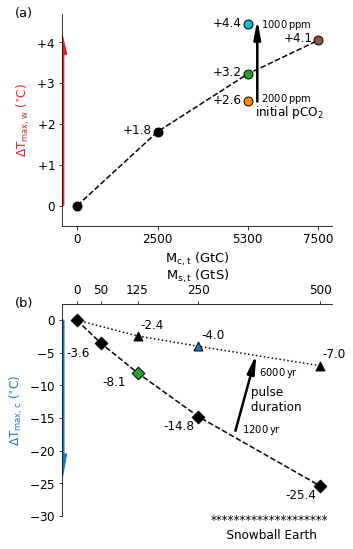

In [10]:
### for Paper: short and long scenarios together (runmean of global mean ts_ann)
ts_ann_maxchange_df=pd.read_pickle('./ts_ann_maxchange_df.pkl')

fig1=plt.figure(figsize=(5.0,7.7))
plt.clf()
ax1 = fig1.add_subplot(211) 
ax2 = fig1.add_subplot(212) 
#ax1.grid(linestyle=':', zorder=0) 
#ax2.grid(linestyle=':', zorder=0) 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
#fig1.subplots_adjust(hspace=0.001)

times=np.arange(0,10500,1)
line_warm_t=[]; line_warm_c=[]
line1_cool_t=[]; line1_cool_s=[]
line2_cool_t=[]; line2_cool_s=[]

line_warm=np.zeros((4,2))
line_cool_s=np.zeros((5,2))
line_cool_l=np.zeros((4,2))

paths=paths_pulse_c_short_base
c_emissions=[5300,2500,5300,7500,5300]
for ii in range(len(paths)):
    path=paths[ii]
    c_emission=c_emissions[ii]
    maxwarm=float(ts_ann_maxchange_df.loc[path, ['maxwarm']])  
    if path in colors_paper_df.index:
        cc=colors_paper_df.loc[path, 'color']
    else: 
        cc='k' 
    ax1.scatter(c_emission, maxwarm, marker='o', edgecolors='k', facecolors=cc, s=80, zorder=10)
    ax1.annotate('+'+str(np.round(maxwarm,1)) ,xy=(c_emission,maxwarm), xytext=(-35, -2), textcoords='offset pixels', fontsize=12,color='k') 
    
    if path in paths_pulse_c_short_base[1:-1]:
        line_warm[ii,0]=c_emission
        line_warm[ii,1]=maxwarm
ax1.scatter(0, 0, marker='o', edgecolors='k', facecolors='k', s=80, zorder=10)
line_warm[0,:]=0
ax1.plot(line_warm[:,0],line_warm[:,1],'--', c='k', lw=1.5,zorder=0)


paths=['pulse_rev_cs_1500ppm_5300GtC_50GtS_5ka',
        'pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka',
        'pulse_rev_cs_1500ppm_5300GtC_250GtS_5ka',
        'pulse_rev_cs_1500ppm_5300GtC_500GtS_5ka']
s_emissions=[50,125,250,500]
for ii in range(len(paths)):
    path=paths[ii]
    s_emission=s_emissions[ii]
    maxcool=float(ts_ann_maxchange_df.loc[path, ['maxcool']])  
    if path in colors_paper_df.index:
        cc=colors_paper_df.loc[path, 'color']
    else: 
        cc='k' 
    ax2.scatter(s_emission, maxcool, marker='D', edgecolors='k', facecolors=cc, s=80, zorder=10)
    ax2.annotate(str(np.round(maxcool,1)) ,xy=(s_emission,maxcool), xytext=(-35, -13), textcoords='offset pixels', fontsize=12,color='k') 
 
    
    line_cool_s[ii+1,0]=s_emission
    line_cool_s[ii+1,1]=maxcool
ax2.scatter(0, 0, marker='D', edgecolors='k', facecolors='k', s=80, zorder=10)
line_cool_s[0,:]=0
ax2.plot(line_cool_s[:,0],line_cool_s[:,1],'--', c='k', lw=1.5,zorder=0)

paths=['pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka',
        'pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka',
        'pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka']
s_emissions=[125,250,500]
for ii in range(len(paths)):
    path=paths[ii]
    s_emission=s_emissions[ii]
    maxcool=float(ts_ann_maxchange_df.loc[path, ['maxcool']])  
    if path in colors_paper_df.index:
        cc=colors_paper_df.loc[path, 'color']
    else: 
        cc='k' 
    ax2.scatter(s_emission, maxcool, marker='^', edgecolors='k', facecolors=cc, s=80, zorder=10)
    ax2.annotate(str(np.round(maxcool,1)) ,xy=(s_emission,maxcool), xytext=(+2.5, +7.5), textcoords='offset pixels', fontsize=12,color='k') 
    
    line_cool_l[ii+1,0]=s_emission
    line_cool_l[ii+1,1]=maxcool
#ax2.scatter(0, 0, marker='^', edgecolors='k', facecolors='k', s=80, zorder=10)
line_cool_l[0,:]=0
ax2.plot(line_cool_l[:,0],line_cool_l[:,1],':', c='k', lw=1.5,zorder=0)



ax1.set_xticks([0,2500,5300,7500]);
ax1.set_ylim([-0.5,4.7])  
ax1.set_ylabel(r'$\mathsf{\Delta T_{max,w}}$ ($\mathsf{^{\circ}C}$)', fontsize=12, color='tab:red'); #$\Delta$ SAT
ax1.tick_params(labelsize=12)
#ax1.tick_params(axis='x', direction='in', pad=-15)
#ax1.tick_params(axis='x', direction='in', pad=-15)
#ax1.set_xticklabels(['0','2500','5300', '7500 GtC  '])
ax1.set_xlabel('$\mathsf{M_{c,t}}$ (GtC)', fontsize=13)
ax1.set_yticks([0,1,2,3,4])
ax1.set_yticklabels(['0','$+1$','$+2$', '$+3$', '$+4$'])
ax2.set_xticks([0,50,125,250,500]);
ax2.set_yticks([0,-5,-10,-15,-20,-25,-30])
ax2.set_yticklabels(['0','$-5$','$-10$', '$-15$', '$-20$', '$-25$', '$-30$'])
ax2.set_ylim([-30,2.5])
ax2.set_xlim([-30,525])
ax2.set_xlabel('$\mathsf{M_{s,t}}$ (GtS)', fontsize=13)
ax2.xaxis.set_label_position('top') 
ax2.set_ylabel(r'$\mathsf{\Delta T_{max,c}}$ ($\mathsf{^{\circ}C}$)', fontsize=12, color='tab:blue'); #$\Delta$ SAT
#ax2.set_xticklabels(['0','50','125', '250','500 GtS'])
ax2.tick_params(labelsize=12)
#ax2.tick_params(axis='x', direction='in', top=True, bottom=False, labeltop=True, labelbottom=False, pad=-20)
ax2.tick_params(axis='x', direction='out', top=True, bottom=False, labeltop=True, labelbottom=False)

# arrow=matplotlib.patches.FancyArrowPatch(posA=(5600,4.55),posB=(5600,2.3),arrowstyle=matplotlib.patches.ArrowStyle.CurveFilledB(head_length=.15, head_width=.028), lw=2.5, mutation_scale=100, edgecolor='k', facecolor='k') #, shrinkA=10                    #
# ax1.add_patch(arrow)
# #ax1.text(5700, 3.075, 'initial $\mathsf{pCO_2}$', rotation=0, fontsize=12)
# ax1.text(5500, 4.65, 'initial $\mathsf{pCO_2}$', rotation=0, fontsize=12)
# ax1.text(5750, 2.44, '2000$\,$ppm', rotation=0, fontsize=10)
# ax1.text(5750, 4.35, '1000$\,$ppm', rotation=0, fontsize=10)

arrow=matplotlib.patches.FancyArrowPatch(posA=(5600,2.5),posB=(5600,4.6),arrowstyle=matplotlib.patches.ArrowStyle.CurveFilledB(head_length=.15, head_width=.028), lw=2.5, mutation_scale=100, edgecolor='k', facecolor='k') #, shrinkA=10                    #
ax1.add_patch(arrow)
#ax1.text(5700, 3.075, 'initial $\mathsf{pCO_2}$', rotation=0, fontsize=12)
ax1.text(5525, 2.2, 'initial $\mathsf{pCO_2}$', rotation=0, fontsize=12)
ax1.text(5725, 4.35, '1000$\,$ppm', rotation=0, fontsize=10)
ax1.text(5725, 2.55, '2000$\,$ppm', rotation=0, fontsize=10)

arrow=matplotlib.patches.FancyArrowPatch(posA=(325, -17.25),posB=(370,-5.0),arrowstyle=matplotlib.patches.ArrowStyle.CurveFilledB(head_length=.15, head_width=.03), lw=2.5, mutation_scale=100, edgecolor='k', facecolor='k') #, shrinkA=10                    #
ax2.add_patch(arrow)
ax2.text(350, -13.9, ' pulse \n duration', rotation=0, fontsize=12)

ax2.text(375, -8.5, '6000$\,$yr', rotation=0, fontsize=10)
ax2.text(340, -17.2, '1200$\,$yr', rotation=0, fontsize=10)
ax2.text(275, -33.5, '********************\n    Snowball Earth', rotation=0, fontsize=12)

ax1.text(-0.175,0.985,'(a)',transform=ax1.transAxes,fontsize=13)
ax2.text(-0.175,0.985,'(b)',transform=ax2.transAxes,fontsize=13)


ax1.arrow(-470, 0, 0, 4.2 ,fc='tab:red', ec='tab:red', alpha=1, width=110, head_width=300, head_length=0.5,length_includes_head=True,) # shape='right'
ax2.arrow(-29, 0, 0, -24 ,fc='tab:blue', ec='tab:blue', alpha=1, width=6, head_width=17, head_length=3.5,length_includes_head=True,)

fig1.tight_layout(h_pad=0.00) #h_pad=0.1


fig1.savefig('./plot_pdf_files/Fig2_pulse_rev_warmingcooling.pdf',bbox_inches='tight', pad_inches=0.1, dpi=900)

### Fig. S14: Pulse Change of precipitation-evaporation difference

In [16]:
%%ferret
cancel data/all
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/history_p2.nc"
let a=ts_ann[i=@ave,j=@ave, l=@sbx:100]
let b=a[l=@min]-a
!list b[l=@loc:0]
!shade ts_ann[l=1656]-ts_ann[l=1]
let ts_ini_f=ts_ann[l=1]
let ts_diff_maxcool_f=ts_ann[l=1606:1706@ave]-ts_ann[l=1] !1656
!shade ts_ann[l=1606:1706@ave]
!contour/over/levels=(-15) ts_ann[l=1614:1714@ave]

let c=a[l=@max]-a
!list c[l=@loc:0]
!shade ts_ann[l=5450]-ts_ann[l=1]
let ts_maxwarm_f=ts_ann[l=5400:5500@ave]
let ts_diff_maxwarm_f=ts_ann[l=5400:5500@ave]-ts_ann[l=1] !5450
!let prc_diff_maxwarm_f=360*(prc_ann[l=5400:5500@ave]-prc_ann[l=1]) !5450
!shade slp_jja[l=5400:5500@ave]-slp_jja[l=1]
!contour/over ts_jja[l=5400:5500@ave]-ts_jja[l=1]
let prc_diff_maxwarm_f=((prc_ann[l=5400:5500@ave]-e_ann[l=5400:5500@ave])-(prc_ann[l=1]-e_ann[l=1])) !5450
let prc_diff_maxcool_f=((prc_ann[l=1606:1706@ave]-e_ann[l=1606:1706@ave])-(prc_ann[l=1]-e_ann[l=1]))
let prc_end_f=prc_ann[l=5400:5500@ave]
let prc_cool_f=prc_ann[l=1606:1706@ave]

!set viewport ul
!shade ts_diff_maxwarm_f
!set viewpoert ur
!plot ts_diff_maxwarm_f[y=23N]

In [17]:
%ferret_getdata ts_ini_f = ts_ini_f
%ferret_getdata ts_maxwarm_f = ts_maxwarm_f
%ferret_getdata ts_diff_maxwarm_f = ts_diff_maxwarm_f
%ferret_getdata ts_diff_maxcool_f = ts_diff_maxcool_f
%ferret_getdata prc_diff_maxwarm_f = prc_diff_maxwarm_f
%ferret_getdata prc_diff_maxcool_f = prc_diff_maxcool_f
%ferret_getdata prc_end_f = prc_end_f
%ferret_getdata prc_cool_f = prc_cool_f

ts_ini_1500ppm=np.rot90(ts_ini_f['data'][:,:,0,0,0,0])
ts_maxwarm=np.rot90(ts_maxwarm_f['data'][:,:,0,0,0,0])
ts_diff_maxwarm=np.rot90(ts_diff_maxwarm_f['data'][:,:,0,0,0,0])
ts_diff_maxcool=np.rot90(ts_diff_maxcool_f['data'][:,:,0,0,0,0])
prc_diff_maxwarm=np.rot90(prc_diff_maxwarm_f['data'][:,:,0,0,0,0])
prc_diff_maxcool=np.rot90(prc_diff_maxcool_f['data'][:,:,0,0,0,0])
prc_end=np.rot90(prc_end_f['data'][:,:,0,0,0,0])
prc_cool=np.rot90(prc_cool_f['data'][:,:,0,0,0,0])

Message: ts_ini_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_maxwarm_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_diff_maxwarm_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_diff_maxcool_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: prc_diff_maxwarm_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: prc_diff_maxcool_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: prc_end_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: prc_cool_f is now available in python as a dictionary containing the variable's metadata and data array.

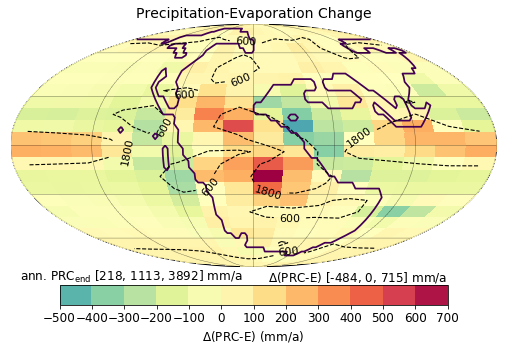

In [48]:
fig1=jplt.plot_world(360*prc_diff_maxwarm, varname='$\Delta$(PRC-E)',  units='mm/a', lim_l=-500., lim_u=700, cbar_delta=100, cbar_tick_freq=1,\
                     projection='moll', title='Precipitation-Evaporation Change', var_digits=0, colourmap='Spectral_shifted', \
                     cont='on', var_cont=360*prc_end, cont_levs=[600, 1800], var_cont_digits=0, var_cont_name='ann. $\mathsf{PRC_{end}}$', var_cont_unit='mm/a', cont_label_fmt='%d', linestyle='dashed')[1] 
# , cbar_tick_freq=2, lim_l=1.5, lim_u=6, cbar_delta=0.25, var_cont=ts_diff_maxcool
fig1.savefig('./plot_pdf_files/FigS14_pulse_rev_1500ppm_PRC_EVAP_Change.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

In [60]:
# %%ferret
# cancel data/all
# use "./climber/pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka/TIMERES/all_snapshots_mom_annual.nc"

# let temp_diff_maxcool_f=temp[i=0,l=111:121@ave]-temp[i=0,l=1] !116
# let temp_diff_maxwarm_f=temp[i=0,l=490:500@ave]-temp[i=0,l=1] !495

# let a=temp[l=490:500@ave]-temp[l=1] 
# !shade a[k=@max] !!! max warming in the water column
# !list a[i=@ave,j=@ave,k=@ave]

# !list temp[i=0,y=30S:30N@ave,k=1,l=490:500@ave]-temp[i=0,y=30S:30N@ave,k=1,l=1]
# !list temp[i=0,y=30S:30N@ave,k=1,l=111:121@ave]-temp[i=0,y=30S:30N@ave,k=1,l=1]

In [61]:
# %ferret_getdata temp_diff_maxcool_f=temp_diff_maxcool_f
# %ferret_getdata temp_diff_maxwarm_f=temp_diff_maxwarm_f
# temp_diff_maxcool=np.ma.masked_values(np.rot90(temp_diff_maxcool_f['data'][0,:,::-1,0,0,0]), -1e34);
# temp_diff_maxwarm=np.ma.masked_values(np.rot90(temp_diff_maxwarm_f['data'][0,:,::-1,0,0,0]), -1e34);

Message: temp_diff_maxcool_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: temp_diff_maxwarm_f is now available in python as a dictionary containing the variable's metadata and data array.

### Fig. 19: Change of marine export production in response to aerosol induced cooling and ocean mixing

In [49]:
%%ferret
cancel data/all
use "../climber/pulse_rev_s_schmidt_12000MtS_0p44_10yrs/history_p2.nc"
use "../climber/pulse_rev_s_schmidt_12000MtS_0p44_10yrs/all_snapshots_mom_annual.nc"
use "../climber/pulse_rev_s_schmidt_12000MtS_0p44_10yrs/history.nc"
!sh da
let tsann_schmidt_10yr_f=ts_ann[i=@ave,j=@ave,l=501:600,d=1]
let phosph_schmidt_10yr_f=tracer_06[i=@ave,j=@ave,z=1:100@ave,d=2]
let proyear_schmidt_10yr_f=proyear[i=@din,y=@din,l=1:100,d=2]
let proyear_lowlat_schmidt_10yr_f=proyear[i=@din,y=45S:45N@din,l=1:100,d=2]
let proyear_hilat_schmidt_10yr_f=proyear[i=@din,y=90S:45S@din,l=1:100,d=2]+proyear[i=@din,y=45N:90N@din,l=1:100,d=2]

let a=abs(glb_over[d=3])
!let glob_over_f=a[k=@ave,j=@ave,l=501:5500@sbx:100,d=1]
!Georg: MOC usually measured as strength below 500m; Black 2018 also measured it like the maximum strength on NH below 500m ->  for our continental config. on SH
let glob_over_schmidt_10yr_f=a[z=500:4000@max, y=90S:0S@max,l=501:600@sbx:10]

!set viewport ul
!plot ts_ann[i=@ave,j=@ave,l=500:600,d=1]
!set viewport ll
!plot glob_over_schmidt_10yr_f
!plot hmxl[i=@ave,j=@ave,l=1:100,d=2]
!set viewport lr
!plot proyear_hilat_schmidt_10yr_f
!plot proyear[i=@din,y=@din,l=1:100,d=2]
!plot/over proyear[i=@din,y=40S:40N@din,l=1:100,d=2]
!!plot tracer_06[i=@ave,j=@ave,z=1:100@ave,d=2]

!shade temp[k=1,l=1,d=2]-temp[k=1,l=1,d=1]

In [50]:
%ferret_getdata tsann_schmidt_10yr_f=tsann_schmidt_10yr_f
%ferret_getdata phosph_schmidt_10yr_f=phosph_schmidt_10yr_f
%ferret_getdata proyear_schmidt_10yr_f=proyear_schmidt_10yr_f
%ferret_getdata proyear_lowlat_schmidt_10yr_f=proyear_lowlat_schmidt_10yr_f
%ferret_getdata proyear_hilat_schmidt_10yr_f=proyear_hilat_schmidt_10yr_f
%ferret_getdata glob_over_schmidt_10yr_f=glob_over_schmidt_10yr_f

tsann_schmidt_10yr=tsann_schmidt_10yr_f['data'][0,0,0,:,0,0]; 
phosph_schmidt_10yr=phosph_schmidt_10yr_f['data'][0,0,0,:,0,0]; 
proyear_schmidt_10yr=proyear_schmidt_10yr_f['data'][0,0,0,:,0,0]; 
proyear_lowlat_schmidt_10yr=proyear_lowlat_schmidt_10yr_f['data'][0,0,0,:,0,0]; 
proyear_hilat_schmidt_10yr=proyear_hilat_schmidt_10yr_f['data'][0,0,0,:,0,0]; 
glob_over_schmidt_10yr=glob_over_schmidt_10yr_f['data'][0,0,0,:,0,0]; 

Message: tsann_schmidt_10yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: phosph_schmidt_10yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: proyear_schmidt_10yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: proyear_lowlat_schmidt_10yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: proyear_hilat_schmidt_10yr_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: glob_over_schmidt_10yr_f is now available in python as a dictionary containing the variable's metadata and data array.

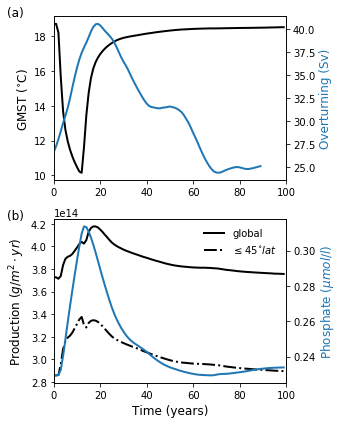

In [51]:
fig=plt.figure(figsize=(5,6))
plt.clf()
gs = GridSpec(2,1) #,height_ratios=[1,1], width_ratios=[1,0.075,0.075,1]

ax2 = plt.subplot(gs[1,0])
ax1 = plt.subplot(gs[0,0],sharex=ax2)

ax1_1=ax1.twinx()
ax2_1=ax2.twinx()

years=np.arange(0,100,1)

ax1.plot(years,tsann_schmidt_10yr,'k-',lw=2)
ax1_1.plot(years[:-10],glob_over_schmidt_10yr[:-10],'-', c='tab:blue',lw=2)
ax1.set_ylabel('GMST ($^{\circ}$C)',fontsize=12)
ax1_1.set_ylabel('Overturning (Sv)',fontsize=12, color='tab:blue')


ax2.plot(years,proyear_schmidt_10yr,'k-',lw=2, label='global')
ax2.plot(years,proyear_lowlat_schmidt_10yr,'k-.',lw=2, label='$\leq 45^{\circ} lat$')
#ax2.plot(years,proyear_hilat_schmidt_10yr,'-',c='tab:orange',lw=2, label='revised (50yr)')
ax2_1.plot(years,phosph_schmidt_10yr, color='tab:blue',lw=2, label='original')

ax2.set_xlabel('Time (years)',fontsize=12)
ax2.set_ylabel(r'Production ($g/{m^2}\cdot yr$)',fontsize=12)
ax2.legend(frameon=False)
ax2.set_xlim(0,100)
ax2_1.set_ylabel(r'Phosphate ($\mu mol/l$)',fontsize=12, color='tab:blue' )

#ax0.text(-0.125,1,'(a)',transform=ax0.transAxes,fontsize=12)
ax1.text(-0.2,1,'(a)',transform=ax1.transAxes,fontsize=12)
ax2.text(-0.2,1,'(b)',transform=ax2.transAxes,fontsize=12)


plt.tight_layout() #h_pad=-4.25, w_pad=-2

fig.savefig('./plot_pdf_files/FigS19_overturning_productivity.pdf',bbox_inches='tight', pad_inches=0.05) #, dpi=900


### Fig. S12: Pulse pCO2 timeseries and maximum increase

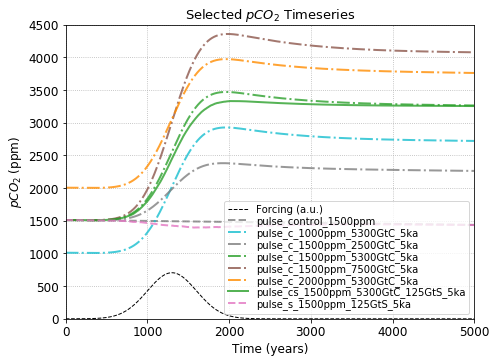

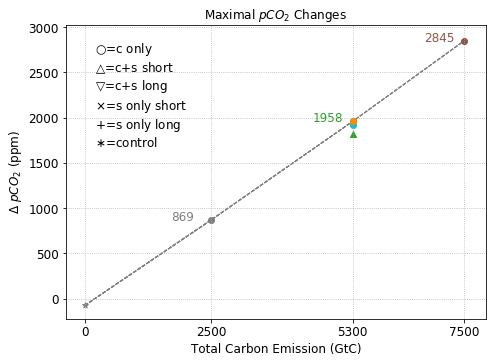

In [32]:
### Plot pco2diag Timeseries and maximal pco2diag-change for all short pulse runs

with open('historyp2_tsann_pco2diag_rev.pickle', 'rb') as f:  
        ts_anns_minmax, ts_anns_runmeans, pco2_minmax,pco2_runmeans, ts_anns_nobiogeo, ppms_nobiogeo = pickle.load(f, encoding='latin1')

fig1=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax1=fig1.add_subplot(111)
ax1.grid(linestyle=':', zorder=0)

fig2=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax2=fig2.add_subplot(111)
ax2.grid(linestyle=':', zorder=0)

times=np.arange(0,12500,1)
line_co2_inc=[]; line_co2_em=[]

years=np.arange(1,5001,1)
filename='../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/carbon_emission_1200y_5300GtC.dat'
years_c, c_rate=np.loadtxt(filename, unpack=True)
ax1.plot(years,c_rate*100, '--',c='k',lw=1, zorder=2, label='Forcing (a.u.)')

for scenario in ['short']: #, 'long'
    if scenario=='short':
        with open('historyp2_tsann_pco2diag_rev.pickle', 'rb') as f:  
            ts_anns_minmax, ts_anns_runmeans, pco2_minmax,pco2_runmeans, ts_anns_nobiogeo, ppms_nobiogeo = pickle.load(f, encoding='latin1')
            #paths=paths_pulse_control+paths_pulse_c_short_base+paths_pulse_cs_short+paths_pulse_s_short
            paths=paths_pulse_control+paths_pulse_c_short_base+['pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka','pulse_rev_s_1500ppm_125GtS_5ka']
            paths_sel=['pulse_control_1500ppm', 'pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka','pulse_rev_s_1500ppm_125GtS_5ka']+paths_pulse_c_short_base

#     elif scenario=='long':
#         with open('historyp2_long_tsann_pco2diag_corr.pickle', 'rb') as f:  
#             ts_anns_minmax, ts_anns_runmeans, pco2_minmax,pco2_runmeans, ts_anns_nobiogeo, ppms_nobiogeo = pickle.load(f, encoding='latin1')
#         paths=paths_pulse_long
        #x_lim=12500
#paths=paths_pulse_control+paths_pulse_c_short_base+paths_pulse_cs_short+paths_pulse_s_short
#paths_sel=['pulse_control_1500ppm', 'pulse_cs_1500ppm_5300GtC_100GtS_5ka','pulse_s_1500ppm_100GtS_5ka']+paths_pulse_c_short_base
    for i in range(len(paths)):
        path=paths[i]

#         if path in paths_pulse_cs_short:
#             mark='^'; linestyle='-'
#         elif path in paths_pulse_s_short:
#             mark='x'; linestyle='--'
#         elif path in paths_pulse_control:
#             linestyle='--'; mark='*'
#         else:
#             mark='o'; linestyle='-'
            
        if path in paths_pulse_control:
            mark='*'; linestyle='--'
        elif path in paths_pulse_c_short_base+paths_pulse_c_long:
            mark='o'; linestyle='-.' 
        elif path in paths_pulse_s_short:
            mark='x'; linestyle='--'
        elif path in paths_pulse_s_long:
            mark='+'; linestyle='--'
        elif path in paths_pulse_cs_short:
            mark='^'; linestyle='-'
        elif path in paths_pulse_cs_long:
            mark='v'; linestyle='-'       
            
        

        c_emission=ts_anns_minmax[i,0]; pco2_diff=pco2_minmax[i,5]
        pco2_ini=pco2_minmax[i,1]; pco2_end=pco2_minmax[i,2]
        ts_ini=ts_anns_minmax[i,2]; ts_end=ts_anns_minmax[i,3]
        
        if path in ['pulse_control_1500ppm','pulse_c_1500ppm_2500GtC_5ka','pulse_c_1500ppm_5300GtC_5ka', \
                    'pulse_c_1500ppm_7500GtC_5ka']:
            if path in ['pulse_control_1500ppm']:
                line_co2_inc.append(pco2_minmax[i,3]-pco2_minmax[i,1]); line_co2_em.append(c_emission);
            else:
                line_co2_inc.append(pco2_diff); line_co2_em.append(c_emission);
        ax2.plot(line_co2_em[:],line_co2_inc[:],'--', c='tab:gray', lw=1,zorder=0)

        if path in colors_paper_df:
            ccc=colors_paper_df.loc[path, 'color']
        else:
            ccc=colors_df.loc[path, 'color']
        
        if path in paths_sel and scenario=='short':
            if path in paths_pulse_cs or path in paths_pulse_s:
                path_label='pulse'+path[9:]
            else:
                path_label=path
                
            if path in colors_paper_df.index:
                ccc=colors_paper_df.loc[path, 'color']
            else:
                ccc=colors_df.loc[path, 'color']
            ax1.plot(times[0:5000], pco2_runmeans[i,:], label=path_label, alpha=0.8, c=ccc, linestyle=linestyle, lw=2)
                
        if path=='pulse_control_1500ppm': 
            ax2.scatter(c_emission, pco2_minmax[i,3]-pco2_minmax[i,1], c=ccc, marker=mark) 
            
         
        if path in paths_pulse_c_short+paths_pulse_cs_short+paths_pulse_c_long+paths_pulse_cs_long and path not in paths_pulse_cs_irreg:
            ax2.scatter(c_emission, pco2_diff, c=ccc, marker=mark)
            #ax33.scatter(pco2_ini, ts_ini, c=color_list[i], marker=mark)
            #ax33.scatter(pco2_end, ts_end, c=color_list[i], marker=mark)
            if path in ['pulse_c_1500ppm_2500GtC_5ka','pulse_c_1500ppm_5300GtC_5ka', 'pulse_c_1500ppm_7500GtC_5ka']:
                anno_pos=(-40, 0) #ax2.annotate('%d' % (pco2_diff) ,xy=(c_emission,pco2_diff),xytext=(-40, 0), textcoords='offset pixels', fontsize=12,color=colors_df.loc[path, 'color'])            
            #elif path in ['pulse_c_1500ppm_5300GtC_12ka','pulse_c_1000ppm_5300GtC_5ka','pulse_c_2000ppm_5300GtC_5ka']:
            #    anno_pos=(+7, -15)
            if path in ['pulse_c_1500ppm_2500GtC_5ka','pulse_c_1500ppm_5300GtC_5ka', 'pulse_c_1500ppm_7500GtC_5ka']:
            #['pulse_c_1500ppm_2500GtC_5ka', 'pulse_c_1500ppm_7500GtC_5ka','pulse_c_1500ppm_5300GtC_5ka',\
             #          'pulse_c_2000ppm_5300GtC_5ka','pulse_c_1500ppm_5300GtC_12ka']: #'pulse_c_1000ppm_5300GtC_5ka',
                ax2.annotate('%d' % (pco2_diff) ,xy=(c_emission,pco2_diff),xytext=anno_pos, textcoords='offset pixels', fontsize=12,color=ccc) 
        #if path in paths_pulse_control+paths_pulse_s_short+paths_pulse_s_long:
        #    ax2.scatter(c_emission, pco2_minmax[i,3]-pco2_minmax[i,1], c=ccc, marker=mark)
        #if path=='pulse_s_2000ppm_250GtS_5ka':
        #    ax2.annotate('%d' % (pco2_minmax[i,3]-pco2_minmax[i,1]) ,xy=(ts_anns_minmax[i,0],pco2_minmax[i,5]),xytext=(+7, -15), textcoords='offset pixels', fontsize=12,color=colors_df.loc[path, 'color'])
            #ax2.annotate('%d' % (pco2_minmax[-1,3]-pco2_minmax[-1,1]) ,xy=(ts_anns_minmax[-1,0],pco2_minmax[-1,5]),xytext=(+7, -15), textcoords='offset pixels', fontsize=12,color='k')
#ax2.annotate('%d' % (pco2_minmax[0,3]-pco2_minmax[0,1]) ,xy=(ts_anns_minmax[0,0],pco2_minmax[0,5]),xytext=(+7, 0), textcoords='offset pixels', fontsize=12,color='k')

# for i in range(len(paths_nobiogeo)):
#     ax33.scatter(ppms_nobiogeo[i], ts_anns_nobiogeo[i], marker='+', c='k')
#     ax33.text(ppms_nobiogeo[i],ts_anns_nobiogeo[i]-0.75,'{:.2f}'.format(ts_anns_nobiogeo[i]),fontsize=8)

ax1.set_title('Selected $pCO_2$ Timeseries', fontsize=13);
ax1.legend(loc='lower right',ncol=1, fontsize=10, labelspacing=0.1)
ax1.set_xlim([0,5000]); ax1.set_ylim([0,4500]);
ax1.set_xlabel('Time (years)', fontsize=12); ax1.set_ylabel(r'$pCO_2$ (ppm)', fontsize=12);
ax2.set_title('Maximal $pCO_2$ Changes', fontsize=12);
ax2.set_xticks([0,2500,5300,7500]);
ax2.set_xlabel('Total Carbon Emission (GtC)', fontsize=12);  ax2.set_ylabel(r'$\Delta\ pCO_2$ (ppm)', fontsize=12);
ax2.text(200,1700,r'$\bigcirc$=c only'+'\n'+r'$\bigtriangleup$=c+s short'+'\n'+r'$\bigtriangledown$=c+s long'+'\n' \
         +r'$\times$=s only short'+'\n'+r'$+$=s only long'+'\n'+r'$\ast$=control', fontsize=12) #+r'$\Box$=control'+'\n'

#ax2.text(100,2000,r'$\bigcirc$=c only'+'\n'+r'$\bigtriangleup$=c+s'+'\n'+r'$\times$=s only'+'\n'+r'$\ast$=control'+'\n'+r'$\plus$=no biogeo', fontsize=12)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
#ax33.set_title('Dependence of Equilibrium ts_anns on pco2diag', fontsize=8);
#ax33.set_xticks([0,100,250]);
#ax33.set_xlabel('pco2diag (ppm)'); ax33.set_ylabel(r'ts_ann (${\circ}C$)');
fig2.tight_layout()
fig1.tight_layout()

fig1.savefig('./plot_pdf_files/FigS12a_pulse_rev_pco2_timeseries.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)
fig2.savefig('./plot_pdf_files/FigS12b_pulse_rev_pco2_change.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

### Figs. S13 and S18: Pulse ocean and marine biogeochemistry change timeseries

In [53]:
%%ferret
cancel data/all
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/all_snapshots_mom_annual.nc"
let sst_trop_f=temp[i=@ave,y=23S:23N@ave,k=1,l=@sbx:10]
let ocean_meantemp_f=temp[i=@ave,j=@ave,k=@ave,l=@sbx:10]
let hmxl_ts_f=hmxl[i=@ave,j=@ave,l=@sbx:10]
let omega_trop_cs_f=omegaplo_a[i=@ave,y=23S:23N@ave,k=1,l=@sbx:10]
!sh da
!plot tracer_05[i=@ave,y=@ave,k=1,l=@sbx:10]
let proyear_trop_cs_f=proyear[i=@din,y=40S:40N@din,k=1,l=@sbx:10]
let proyear_extratrop_cs_f=proyear[i=@din,y=40N:90N@din,k=1,l=@sbx:10]+proyear[i=@din,y=90S:40S@din,k=1,l=@sbx:10]
let calex_trop_cs_f=calex[i=@din,y=23S:23N@din,k=1,l=@sbx:10]
let calex_extratrop_cs_f=calex[i=@din,y=23N:90N@din,k=1,l=@sbx:10]+calex[i=@din,y=90S:23S@din,k=1,l=@sbx:10]
let oxy_cs_f=tracer_05[i=@ave,j=@ave,k=@ave,l=@sbx:10]

let oxy_cs_ini_f=tracer_05[k=@min,l=1:10@ave]
let oxy_cs_cool_f=tracer_05[k=@min,l=110:120@ave]
let oxy_cs_warm_f=tracer_05[k=@min,l=490:500@ave]

In [54]:
%ferret_getdata sst_trop_f = sst_trop_f
%ferret_getdata ocean_meantemp_f = ocean_meantemp_f
%ferret_getdata hmxl_ts_f = hmxl_ts_f
%ferret_getdata omega_trop_cs_f = omega_trop_cs_f
%ferret_getdata proyear_trop_cs_f = proyear_trop_cs_f
%ferret_getdata proyear_extratrop_cs_f = proyear_extratrop_cs_f
%ferret_getdata calex_trop_cs_f = calex_trop_cs_f
%ferret_getdata calex_extratrop_cs_f = calex_extratrop_cs_f
%ferret_getdata oxy_cs_f = oxy_cs_f

%ferret_getdata oxy_cs_ini_f = oxy_cs_ini_f
%ferret_getdata oxy_cs_cool_f = oxy_cs_cool_f
%ferret_getdata oxy_cs_warm_f = oxy_cs_warm_f

#sst_trop_f
#np.ma.masked_values(np.rot90(omegaplo_a_f['data'][:,:,0,0,0,0]), -1e34)
sst_trop=np.ma.masked_values(sst_trop_f['data'][0,0,0,:,0,0], -1e34)
ocean_meantemp=np.ma.masked_values(ocean_meantemp_f['data'][0,0,0,:,0,0], -1e34)
hmxl_ts=np.ma.masked_values(hmxl_ts_f['data'][0,0,0,:,0,0], -1e34)/100
omega_trop_cs=np.ma.masked_values(omega_trop_cs_f['data'][0,0,0,:,0,0], -1e34)
proyear_trop_cs=np.ma.masked_values(proyear_trop_cs_f['data'][0,0,0,:,0,0], -1e34)
proyear_extratrop_cs=np.ma.masked_values(proyear_extratrop_cs_f['data'][0,0,0,:,0,0], -1e34)
calex_trop_cs=np.ma.masked_values(calex_trop_cs_f['data'][0,0,0,:,0,0], -1e34)
calex_extratrop_cs=np.ma.masked_values(calex_extratrop_cs_f['data'][0,0,0,:,0,0], -1e34)
oxy_cs=np.ma.masked_values(oxy_cs_f['data'][0,0,0,:,0,0], -1e34)

oxy_cs_ini=np.ma.masked_values(np.rot90(oxy_cs_ini_f['data'][:,:,0,0,0,0]), -1e34); 
oxy_cs_cool=np.ma.masked_values(np.rot90(oxy_cs_cool_f['data'][:,:,0,0,0,0]), -1e34); 
oxy_cs_warm=np.ma.masked_values(np.rot90(oxy_cs_warm_f['data'][:,:,0,0,0,0]), -1e34); 

Message: sst_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ocean_meantemp_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: hmxl_ts_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: proyear_trop_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: proyear_extratrop_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: calex_trop_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: calex_extratrop_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: oxy_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: oxy_cs_ini_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: oxy_cs_cool_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: oxy_cs_warm_f is now available in python as a dictionary containing the variable's metadata and data array.

In [55]:
%%ferret
cancel data/all
use "../climber/pulse_c_1500ppm_5300GtC_5ka/all_snapshots_mom_annual.nc"
let sst_trop_c_f=temp[i=@ave,y=23S:23N@ave,k=1,l=@sbx:10]
let ocean_meantemp_c_f=temp[i=@ave,j=@ave,k=@ave,l=@sbx:10]
let hmxl_ts_c_f=hmxl[i=@ave,j=@ave,l=@sbx:10]
let omega_trop_c_f=omegaplo_a[i=@ave,y=23S:23N@ave,k=1,l=@sbx:10]
let proyear_trop_c_f=proyear[i=@din,y=40S:40N@din,k=1,l=@sbx:10]
let proyear_extratrop_c_f=proyear[i=@din,y=40N:90N@din,k=1,l=@sbx:10]+proyear[i=@din,y=90S:40S@din,k=1,l=@sbx:10]
let calex_trop_c_f=calex[i=@din,y=23S:23N@din,k=1,l=@sbx:10]
let calex_extratrop_c_f=calex[i=@din,y=23N:90N@din,k=1,l=@sbx:10]+proyear[i=@din,y=90S:23S@din,k=1,l=@sbx:10]
let oxy_c_f=tracer_05[i=@ave,j=@ave,k=@ave,l=@sbx:10]

In [56]:
%ferret_getdata sst_trop_c_f = sst_trop_c_f
%ferret_getdata ocean_meantemp_c_f = ocean_meantemp_c_f
%ferret_getdata hmxl_ts_c_f = hmxl_ts_c_f
%ferret_getdata omega_trop_c_f = omega_trop_c_f
%ferret_getdata proyear_trop_c_f = proyear_trop_c_f
%ferret_getdata proyear_extratrop_c_f = proyear_extratrop_c_f
%ferret_getdata calex_trop_c_f = calex_trop_c_f
%ferret_getdata calex_extratrop_c_f = calex_extratrop_c_f
%ferret_getdata oxy_c_f = oxy_c_f
#sst_trop_f
#np.ma.masked_values(np.rot90(omegaplo_a_f['data'][:,:,0,0,0,0]), -1e34)
sst_trop_c=np.ma.masked_values(sst_trop_c_f['data'][0,0,0,:,0,0], -1e34)
ocean_meantemp_c=np.ma.masked_values(ocean_meantemp_c_f['data'][0,0,0,:,0,0], -1e34)
hmxl_ts_c=np.ma.masked_values(hmxl_ts_c_f['data'][0,0,0,:,0,0], -1e34)/100
omega_trop_c=np.ma.masked_values(omega_trop_c_f['data'][0,0,0,:,0,0], -1e34)
proyear_trop_c=np.ma.masked_values(proyear_trop_c_f['data'][0,0,0,:,0,0], -1e34)
proyear_extratrop_c=np.ma.masked_values(proyear_extratrop_c_f['data'][0,0,0,:,0,0], -1e34)
calex_trop_c=np.ma.masked_values(calex_trop_c_f['data'][0,0,0,:,0,0], -1e34)
calex_extratrop_c=np.ma.masked_values(calex_extratrop_c_f['data'][0,0,0,:,0,0], -1e34)
oxy_c=np.ma.masked_values(oxy_c_f['data'][0,0,0,:,0,0], -1e34)

Message: sst_trop_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ocean_meantemp_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: hmxl_ts_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: proyear_trop_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: proyear_extratrop_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: calex_trop_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: calex_extratrop_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: oxy_c_f is now available in python as a dictionary containing the variable's metadata and data array.

In [57]:
%%ferret
cancel data/all
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/history.nc"
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/history_isis.nc"
let eta_steric_f=eta_steric[l=501:5500@sbx:100, d=1]
let a=abs(glb_over)
!let glob_over_f=a[k=@ave,j=@ave,l=501:5500@sbx:100,d=1]
! 06/2019: new definition of MOC measure
!Georg: MOC usually measured as strength below 500m; Black 2018 also measured it like the maximum strength on NH below 500m ->  for our continental config. on SH
let glob_over_f=a[z=500:4000@max, y=90S:0S@max,l=501:5500@sbx:100, d=1]
!let ocean_meantemp_f=temp[i=@ave,j=@ave,k=@ave,l=@sbx:10]
!sh da
!plot ocean_meantemp_f
!let max_ini=a[z=500:4000@max, y=90S:0S@max,l=500 ]
!set viewport ul
!plot/vlimits=0:50 a[z=500:4000@max, y=90S:0S@max,l=501:5500@sbx:100, d=1]
!plot/over a[z=500:4000@max, y=0N:90N@max,l=501:5500@sbx:100, d=1]
!set viewport ur
!plot a[z=500:4000@max,l=500, d=1]
!plot/over a[z=500:4000@max,l=5500, d=1]
!set viewport lr
!plot a[y=90S:0S@max,l=500, d=1]
!plot/over a[y=90S:0S@max,l=5500, d=1]

!list a[z=500:4000@max, y=90S:0S@max,l=500, d=1]
!list a[z=500:4000@max, y=90S:0S@max,l=5500, d=1]

!set viewport ll
!plot con_g[x=@ave,y=90S:0S@ave, d=2,l=501:5500@sbx:100]

In [58]:
%ferret_getdata eta_steric_f = eta_steric_f
%ferret_getdata glob_over_f=glob_over_f
eta_steric=np.ma.masked_values(eta_steric_f['data'][0,0,0,:,0,0], -1e34)/100
glb_over=np.ma.masked_values(glob_over_f['data'][0,0,0,:,0,0], -1e34)

Message: eta_steric_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: glob_over_f is now available in python as a dictionary containing the variable's metadata and data array.

In [59]:
%%ferret
cancel data/all
use "../climber/pulse_control_1500ppm/history.nc"
let eta_steric_control_1500ppm_f=eta_steric[l=501:5500@sbx:100]
let a=abs(glb_over)
!let glob_over_control_1500ppm_f=a[k=@ave,j=@ave,l=501:5500@sbx:100]
! 06/2019: new definition of MOC measure
!Georg: MOC usually measured as strength below 500m; Black 2018 also measured it like the maximum strength on NH below 500m ->  for our continental config. on SH
let glob_over_control_1500ppm_f=a[z=500:4000@max, y=90S:0S@max,l=501:5500@sbx:100]
!plot glob_over_control_1500ppm_f

In [60]:
%ferret_getdata eta_steric_control_1500ppm_f = eta_steric_control_1500ppm_f
%ferret_getdata glob_over_control_1500ppm_f = glob_over_control_1500ppm_f
eta_steric_control_1500ppm=np.ma.masked_values(eta_steric_control_1500ppm_f['data'][0,0,0,:,0,0], -1e34)/100
glob_over_control_1500ppm=np.ma.masked_values(glob_over_control_1500ppm_f['data'][0,0,0,:,0,0], -1e34)

Message: eta_steric_control_1500ppm_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: glob_over_control_1500ppm_f is now available in python as a dictionary containing the variable's metadata and data array.

In [61]:
%%ferret
cancel data/all
use "../climber/pulse_c_1500ppm_5300GtC_5ka/history.nc"
let eta_steric_c_f=eta_steric[l=501:5500@sbx:100]
let a=abs(glb_over)
!let glob_over_c_f=a[k=@ave,j=@ave,l=501:5500@sbx:100]
! 06/2019: new definition of MOC measure
!Georg: MOC usually measured as strength below 500m; Black 2018 also measured it like the maximum strength on NH below 500m ->  for our continental config. on SH
let glob_over_c_f=a[z=500:4000@max, y=90S:0S@max,l=501:5500@sbx:100]
!plot glob_over_c_f
!list glob_over_c_f[l=@min]/glob_over_c_f[l=501]

In [62]:
%ferret_getdata eta_steric_c_f = eta_steric_c_f
%ferret_getdata glob_over_c_f=glob_over_c_f
eta_steric_c=np.ma.masked_values(eta_steric_c_f['data'][0,0,0,:,0,0], -1e34)/100
glb_over_c=np.ma.masked_values(glob_over_c_f['data'][0,0,0,:,0,0], -1e34)

Message: eta_steric_c_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: glob_over_c_f is now available in python as a dictionary containing the variable's metadata and data array.

In [63]:
%%ferret
cancel data/all
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/history_p2.nc"
let prc_times_f=(prc_ann[i=@ave,j=@ave,l=501:5500@sbx:100])*360

In [64]:
%ferret_getdata prc_times_f = prc_times_f
prc_times=np.ma.masked_values(prc_times_f['data'][0,0,0,:,0,0], -1e34)

Message: prc_times_f is now available in python as a dictionary containing the variable's metadata and data array.

In [65]:
%%ferret
cancel data/all
use "../climber/pulse_c_1500ppm_5300GtC_5ka/history_p2.nc"
let prc_times_c_f=(prc_ann[i=@ave,j=@ave,l=501:5500@sbx:100])*360

In [66]:
%ferret_getdata prc_times_c_f = prc_times_c_f
prc_times_c=np.ma.masked_values(prc_times_c_f['data'][0,0,0,:,0,0], -1e34)

Message: prc_times_c_f is now available in python as a dictionary containing the variable's metadata and data array.

In [67]:
%%ferret
cancel data/all
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/history_isis.nc"
!shade con_g[i=@ave,l=501:5500@sbx:100]
let ice_lat_f=con_g[i=@ave,y=90S:0S@loc:0.1,l=501:5500@sbx:100] 
!plot ice_lat_f
!let con_g_times_f=(con_g[i=@ave,j=@ave,l=501:5500@sbx:100])


In [68]:
%ferret_getdata ice_lat_f = ice_lat_f
#ice_lat=np.ma.masked_values(ice_lat_f['data'][0,0,0,:,0,0], -1e34)
ice_lat=ice_lat_f['data'][0,0,0,:,0,0]
ice_lat[ice_lat==-1e34]=-90

Message: ice_lat_f is now available in python as a dictionary containing the variable's metadata and data array.

In [69]:
%%ferret
cancel data/all
use "../climber/pulse_c_1500ppm_5300GtC_5ka/history_isis.nc"
let ice_lat_c_f=con_g[i=@ave,y=90S:0S@loc:0.1,l=501:5500@sbx:100] 

In [70]:
%ferret_getdata ice_lat_c_f = ice_lat_c_f
ice_lat_c=ice_lat_c_f['data'][0,0,0,:,0,0]
ice_lat_c[ice_lat_c==-1e34]=-90

Message: ice_lat_c_f is now available in python as a dictionary containing the variable's metadata and data array.

In [175]:
# %%ferret
# cancel data/all
# use "./climber/pulse_c_1500ppm_5300GtC_5ka_Eppley/all_snapshots_mom_annual.nc"
# let proyear_trop_c_eppley_f=proyear[i=@din,y=23S:23N@din,k=1,l=@sbx:10]

In [176]:
# %ferret_getdata proyear_trop_c_eppley_f= proyear_trop_c_eppley_f
# proyear_trop_c_eppley=np.ma.masked_values(proyear_trop_c_eppley_f['data'][0,0,0,:,0,0], -1e34)

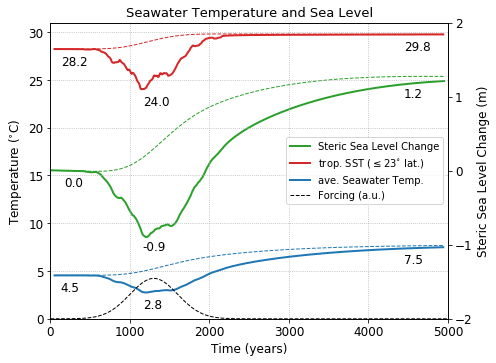

In [71]:
### Plot
fig10=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax10 = fig10.add_subplot(111) 
ax10.patch.set_visible(False)
ax10.set_zorder(10)
ax11 = ax10.twinx()
ax10.grid(linestyle=':', zorder=0) 

years=np.arange(1,5001,1)
filename='../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/carbon_emission_1200y_5300GtC.dat'
years_c, c_rate=np.loadtxt(filename, unpack=True)

ax10.plot(years[::10],sst_trop, '-',lw=2, zorder=2, c='tab:red', label='trop. SST ($\leq 23^{\circ}$ lat.)')  
ax10.plot(years[::10],ocean_meantemp, '-',lw=2, zorder=2, c='tab:blue', label='ave. Seawater Temp.')
#ax11.plot(years[::10],omega_trop_cs, '-',lw=2, zorder=2, c='tab:orange', label='trop. surf. $\Omega_{Ar}$')
ax10.plot(years,c_rate*0.6, '--k',lw=1, zorder=2, label='Forcing (a.u.)')
ax11.plot(years,eta_steric, '-',lw=2, zorder=2, c='tab:green', label='Steric Sea Level Change')


ax10.plot(years[::10],sst_trop_c, '--',lw=1, zorder=2, c='tab:red')  
ax10.plot(years[::10],ocean_meantemp_c, '--',lw=1, zorder=2, c='tab:blue')
#ax11.plot(years[::10],omega_trop_c, '--',lw=1, zorder=2, c='tab:orange')
ax11.plot(years,eta_steric_c, '--',lw=1, zorder=2, c='tab:green')

for var in [sst_trop, ocean_meantemp,eta_steric]:
    fac=1; ax=ax10
    if var is eta_steric:
        fac=10; ax=ax11
    ax.annotate('%.1f' % (np.round(var[5*fac],1)), xy=(years[5*fac],var[5*fac]), xytext=(+10,-16), textcoords='offset pixels', fontsize=12, color='k') 
    ax.annotate('%.1f' % (np.round(var[116*fac],1)), xy=(years[1160],var[116*fac]), xytext=(0,-16), textcoords='offset pixels', fontsize=12, color='k') 
    ax.annotate('%.1f' % (np.round(var[494*fac],1)), xy=(years[4950],var[494*fac]), xytext=(-40,-16), textcoords='offset pixels', fontsize=12, color='k') 

h2, l2 = ax10.get_legend_handles_labels()
h1, l1 = ax11.get_legend_handles_labels()
ax10.legend(h1+h2, l1+l2, loc='center right', ncol=1, fontsize=10) #(0.25,0.25)

ax10.tick_params(labelsize=12)
ax11.tick_params(labelsize=12)
ax10.set_xlim([0,5000]); ax10.set_ylim([0,31]) 
#plt.xticks([700,1000,1500,2000,3000,4000]);
#ax10.set_yticks(np.arange(8,32,2))
ax10.set_title('Seawater Temperature and Sea Level', fontsize=13)
ax10.set_ylabel('Temperature ($^{\circ}$C)', fontsize=12)
ax10.set_xlabel('Time (years)', fontsize=12); 
ax11.set_ylabel(r'Steric Sea Level Change (m)', fontsize=12)
ax11.set_ylim([-2,2])
ax11.set_yticks([-2,-1,0,1,2])
#ax10.set_yticks(np.arange(8,32,2))
plt.tight_layout()

fig10.savefig('./plot_pdf_files/FigS13a_pulse_rev_1500ppm_SeaTemp_Level_Timeseries.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

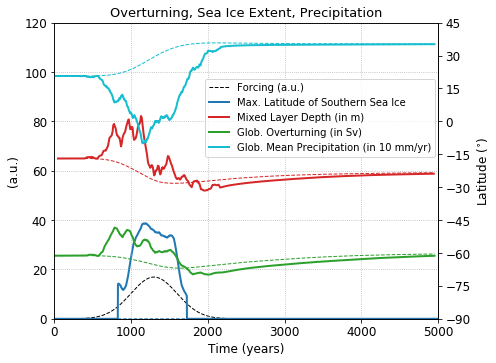

In [73]:
### Plot
fig10=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax10 = fig10.add_subplot(111) 
ax10.patch.set_visible(False)
ax10.set_zorder(10)
ax11 = ax10.twinx()
ax10.grid(linestyle=':', zorder=0) 

years=np.arange(1,5001,1)
filename='../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/carbon_emission_1200y_5300GtC.dat'
years_c, c_rate=np.loadtxt(filename, unpack=True)

ax10.plot(years[::10],hmxl_ts, '-k',lw=2, zorder=2, c='tab:red', label='Mixed Layer Depth (in m)')  
ax11.plot(years,c_rate*2.7-90, '--k',lw=1, zorder=2, label='Forcing (a.u.)')
ax11.plot(years,ice_lat, '-k',lw=2, zorder=2, c='tab:blue', label='Max. Latitude of Southern Sea Ice')
ax10.plot(years,glb_over, '-k',lw=2, zorder=2, c='tab:green', label='Glob. Overturning (in Sv)')
ax10.plot(years,prc_times/10, '-k',lw=2, zorder=2, c='tab:cyan', label='Glob. Mean Precipitation (in 10 mm/yr)')

ax10.plot(years[::10],hmxl_ts_c, '--',lw=1, zorder=2, c='tab:red')  
ax11.plot(years,ice_lat_c, '--',lw=1, zorder=2, c='tab:blue')
ax10.plot(years,glb_over_c, '--',lw=1, zorder=2, c='tab:green')
ax10.plot(years,prc_times_c/10, '--',lw=1, zorder=2, c='tab:cyan')

# for var in [sst_trop, ocean_meantemp,eta_steric]:
#     fac=1; ax=ax10
#     if var is eta_steric:
#         fac=10; ax=ax11
#     ax.annotate('%.1f' % (np.round(var[5*fac],1)), xy=(years[5*fac],var[5*fac]), xytext=(+10,-25), textcoords='offset pixels', fontsize=12, color='k') 
#     ax.annotate('%.1f' % (np.round(var[116*fac],1)), xy=(years[1160],var[116*fac]), xytext=(0,-25), textcoords='offset pixels', fontsize=12, color='k') 
#     ax.annotate('%.1f' % (np.round(var[494*fac],1)), xy=(years[4950],var[494*fac]), xytext=(-60,-25), textcoords='offset pixels', fontsize=12, color='k') 

h2, l2 = ax10.get_legend_handles_labels()
h1, l1 = ax11.get_legend_handles_labels()
ax10.legend(h1+h2, l1+l2, ncol=1, fontsize=10, bbox_to_anchor=(0.38, 0.53)) #(, loc='best'

ax10.tick_params(labelsize=12)
ax11.tick_params(labelsize=12)
ax10.set_xlim([0,5000]); ax10.set_ylim([0,120]) 
#plt.xticks([700,1000,1500,2000,3000,4000]);
ax11.set_yticks([-90,-75,-60,-45,-30,-15,0,15,30,45])
ax10.set_title('Overturning, Sea Ice Extent, Precipitation', fontsize=13)
ax10.set_ylabel('(a.u.)', fontsize=12)
ax10.set_xlabel('Time (years)', fontsize=12); 
ax11.set_ylabel(r'Latitude ($^{\circ}$)', fontsize=12)
ax11.set_ylim([-90,45])
#ax10.set_yticks(np.arange(8,32,2))
plt.tight_layout()

fig10.savefig('./plot_pdf_files/FigS13b_pulse_rev_1500ppm_OverturningIcePrecipitation_Timeseries.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

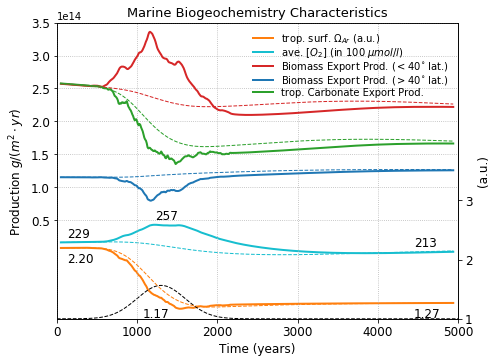

In [75]:
### Plot
fig10=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax10 = fig10.add_subplot(111) 
ax10.patch.set_visible(False)
ax10.set_zorder(10)
ax11 = ax10.twinx()
ax10.grid(linestyle=':', zorder=0) 

years=np.arange(1,5001,1)
filename='../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/carbon_emission_1200y_5300GtC.dat'
years_c, c_rate=np.loadtxt(filename, unpack=True)

ax10.plot(years[::10],proyear_trop_cs, '-',lw=2, zorder=2, c='tab:red', label=r'Biomass Export Prod. ($<40^{\circ}$ lat.)')  
ax10.plot(years[::10],proyear_extratrop_cs, '-',lw=2, zorder=2, c='tab:blue', label=r'Biomass Export Prod. ($>40^{\circ}$ lat.)') 
ax10.plot(years[::10],12*calex_trop_cs, '-',lw=2, zorder=2, c='tab:green', label='trop. Carbonate Export Prod.') 
#ax10.plot(years[::10],10*calex_extratrop_cs, '-',lw=2, zorder=2, c='tab:olive', label='extratroptrop. Carbonate Export') 
ax11.plot(years[::10],omega_trop_cs, '-',lw=2, zorder=2, c='tab:orange', label='trop. surf. $\Omega_{Ar}$ (a.u.)')
ax11.plot(years[::10],0.01*oxy_cs, '-',lw=2, zorder=2, c='tab:cyan', label='ave. $[O_2]$ (in 100 $\mu mol/l$)')
ax11.plot(years,c_rate*0.08+1, '--k',lw=1, zorder=2) #, label='Forcing (a.u.)'
#ax11.plot(years,eta_steric, '-',lw=2, zorder=2, c='tab:green', label='Steric Sea Level Change')


ax10.plot(years[::10],proyear_trop_c, '--',lw=1, zorder=2, c='tab:red')  
ax10.plot(years[::10],proyear_extratrop_c, '--',lw=1, zorder=2, c='tab:blue')
#ax10.plot(years[::10],proyear_trop_c_eppley[:-1], '--',lw=1, zorder=2, c='tab:pink', label='trop. prim. Prod. (Eppley)') 
ax11.plot(years[::10],omega_trop_c, '--',lw=1, zorder=2, c='tab:orange')
ax10.plot(years[::10],12*calex_trop_c, '--',lw=1, zorder=2, c='tab:green') 
ax11.plot(years[::10],0.01*oxy_c, '--',lw=1, zorder=2, c='tab:cyan')
#ax10.plot(years[::10],calex_extratrop_c, '--',lw=1, zorder=2, c='tab:olive') 
#ax11.plot(years,eta_steric_c, '--',lw=1, zorder=2, c='tab:green')

for var in [omega_trop_cs]:
    fac=1; ax=ax11
    #if var is eta_steric:
       # fac=10; ax=ax11
    ax.annotate('%.2f' % (np.round(np.max(var),2)), xy=(years[5*fac],var[5*fac]), xytext=(+10,-14), textcoords='offset pixels', fontsize=12, color='k') 
    ax.annotate('%.2f' % (np.round(np.min(var),2)), xy=(years[1439],var[144*fac]), xytext=(-30,-12), textcoords='offset pixels', fontsize=12, color='k') 
    ax.annotate('%.2f' % (np.round(var[494*fac],2)), xy=(years[4950],var[494*fac]), xytext=(-40,-14), textcoords='offset pixels', fontsize=12, color='k') 
for var in [oxy_cs]:
    fac=1; ax=ax11
    #if var is eta_steric:
       # fac=10; ax=ax11
    ax.annotate('%d' % (np.round(var[5*fac])), xy=(years[5*fac],0.01*var[5*fac]), xytext=(+10,+5), textcoords='offset pixels', fontsize=12, color='k') 
    ax.annotate('%d' % (np.round(np.max(var[144*fac]))), xy=(10*years[np.where(var==np.max(var))],0.01*var[144*fac]), xytext=(0,+6), textcoords='offset pixels', fontsize=12, color='k') 
    ax.annotate('%d' % (np.round(var[494*fac])), xy=(years[4950],0.01*var[494*fac]), xytext=(-40,+5), textcoords='offset pixels', fontsize=12, color='k') 

    
h2, l2 = ax10.get_legend_handles_labels()
h1, l1 = ax11.get_legend_handles_labels()
ax10.legend(h1+h2, l1+l2, loc='upper right', ncol=1, fontsize=10, labelspacing=0.0, frameon=False) #(0.25,0.25)

ax10.tick_params(labelsize=12)
ax11.tick_params(labelsize=12)
ax10.set_xlim([0,5000]); 
ax10.set_ylim([-1.0e14,3.5e14]) 
ax10.set_yticks(np.arange(0.5e14,4e14,0.5e14))
ax11.set_yticks([1,2,3])
#plt.xticks([700,1000,1500,2000,3000,4000]);
#ax10.set_yticks(np.arange(8,32,2))
ax10.set_title('Marine Biogeochemistry Characteristics', fontsize=13)
ax10.set_ylabel('Production $g/(m^2\cdot yr)$', fontsize=12)
ax10.set_xlabel('Time (years)', fontsize=12); 
ax11.set_ylabel(r'(a.u.)', fontsize=12)
ax11.set_ylim([1,6])
#ax10.set_yticks(np.arange(8,32,2))
plt.tight_layout()

fig10.savefig('./plot_pdf_files/FigS18_pulse_rev_1500ppm_BiogeoCharacteristicTimeseries.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

### Figs. S15, S16 and S17: Pulse change of ocean pH and carbonate saturation

In [76]:
### read out biogeo_df from all_snapshots_mom_annual.nc
paths=paths_pulse_control+paths_pulse_c_short_base+['pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka']
#paths=paths_pulse_control+paths_pulse_c_short_base+\
#    paths_pulse_cs_short+paths_pulse_cs_long
#+\
#    paths_pulse_s_short+paths_pulse_s_long #+paths_pulse_s_long
#+paths_pulse_c_short_extra_13c+paths_pulse_c_long

#paths=paths_pulse_control+paths_pulse_c_short_base
biogeo_df=pd.DataFrame([], columns=['ph_mean','omega_trop','dp13', 'dc13', 'years'], index=paths) #, dtype=float[], columns=['dp13_ts_globmean', 'years'], index=[]

for path in paths: 
    #nc_f = '../'+path+'/TIMERES/all_snapshots_mom_annual.nc'
    #nc_fid = Dataset(nc_f, 'r')
    #nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
    #var_ts=nc_fid.variables[var][:,0,::-1,:]
    #dates=num2date(nc_fid.variables['Time'][:], units=nc_fid.variables['Time'].units, calendar=nc_fid.variables['Time'].calendar)
    #years_strings=[time.strftime('%Y') for time in dates]
    #years=np.array(list(map(int,years_strings)))
    #times=[time.timetuple().tm_year for time in test]
    
    if path in paths_pulse_control:
        years=np.arange(0,13000,100)
    else:
        years=np.arange(0,5000,10)

    #path='c3beta_tria_200Ma_'+str(pco2[i])+'ppm'
    if path in paths_pulse_control+paths_pulse_c_long+paths_pulse_cs_long:
        sbx_range=1
    else:
        sbx_range=10
    %ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/all_snapshots_mom_annual.nc"; \
            let ph_mean_f=ph[i=@ave,j=@ave,k=1,l=@sbx:%(sbx_range)s];\
            let omega_trop_f=omegaplo_a[i=@ave,y=30S:30N@ave,k=1,l=@sbx:%(sbx_range)s]; \
            let dp13_mean_f=dp13[i=@ave,j=@ave,k=1,l=@sbx:%(sbx_range)s];\
            let dc13_mean_f=dc13[i=@ave,j=@ave,k=1,l=@sbx:%(sbx_range)s]' % locals() #,l=@sbx:%(sbx_range)s; let ph_mean_min_f=a[l=@min]-a[l=1]
    %ferret_getdata ph_mean_f=ph_mean_f
    %ferret_getdata omega_trop_f=omega_trop_f
    %ferret_getdata dp13_mean_f=dp13_mean_f
    %ferret_getdata dc13_mean_f=dc13_mean_f
    #; let ph_mean_min_f=a[l=@min]-a[l=1]
    biogeo_df.loc[path, ['ph_mean','omega_trop', 'dp13', 'dc13','years']]=[np.ma.masked_values(ph_mean_f['data'][0,0,0,:,0,0], -1e34), \
                                                                           np.ma.masked_values(omega_trop_f['data'][0,0,0,:,0,0], -1e34),\
                                                                           np.ma.masked_values(dp13_mean_f['data'][0,0,0,:,0,0], -1e34),\
                                                                           np.ma.masked_values(dc13_mean_f['data'][0,0,0,:,0,0], -1e34),\
                                                                           years] 
biogeo_df.to_pickle('./biogeo_df_rev.pkl')

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_trop_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dp13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: dc13_mean_f is now available in python as a dictionary containing the variable's metadata and data array.

In [77]:
biogeo_df

ph_mean  \
pulse_control_1000ppm                    [7.692365494273341, 7.692418192014194, 7.69248...   
pulse_control_1500ppm                    [7.599261800261874, 7.599298033430007, 7.59932...   
pulse_control_2000ppm                    [7.540781661862346, 7.540805836926754, 7.54083...   
pulse_c_1000ppm_5300GtC_5ka              [--, --, --, --, --, 7.692641980468145, 7.6926...   
pulse_c_1500ppm_2500GtC_5ka              [--, --, --, --, --, 7.599416611320305, 7.5994...   
pulse_c_1500ppm_5300GtC_5ka              [--, --, --, --, --, 7.599414540799288, 7.5994...   
pulse_c_1500ppm_7500GtC_5ka              [--, --, --, --, --, 7.5994103871487315, 7.599...   
pulse_c_2000ppm_5300GtC_5ka              [--, --, --, --, --, 7.540918989623301, 7.5409...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka  [--, --, --, --, --, 7.599407730803535, 7.5994...   

                                                                                omega_trop  \
pulse_control_1000ppm                    [2.1402375027570915, 2.1403875684754743, 2.140...   
pulse_control_1500ppm                    [2.1590793760514018, 2.159360761094911, 2.1593...   
pulse_control_2000ppm                    [2.234722172930214, 2.2347825376277384, 2.2349...   
pulse_c_1000ppm_5300GtC_5ka              [--, --, --, --, --, 2.1413078963628323, 2.141...   
pulse_c_1500ppm_2500GtC_5ka              [--, --, --, --, --, 2.159836008275365, 2.1599...   
pulse_c_1500ppm_5300GtC_5ka              [--, --, --, --, --, 2.159826179385031, 2.1599...   
pulse_c_1500ppm_7500GtC_5ka              [--, --, --, --, --, 2.1598087698205033, 2.159...   
pulse_c_2000ppm_5300GtC_5ka              [--, --, --, --, --, 2.235381377225876, 2.2355...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka  [--, --, --, --, --, 2.159988611596877, 2.1601...   

                                                                                      dp13  \
pulse_control_1000ppm                    [-31.29110385755809, -31.30119427309537, -31.3...   
pulse_control_1500ppm                    [-31.323277377828866, -31.33133327158101, -31....   
pulse_control_2000ppm                    [-31.395471334122607, -31.401882977014306, -31...   
pulse_c_1000ppm_5300GtC_5ka              [--, --, --, --, --, -31.340202648896852, -31....   
pulse_c_1500ppm_2500GtC_5ka              [--, --, --, --, --, -31.36303197281804, -31.3...   
pulse_c_1500ppm_5300GtC_5ka              [--, --, --, --, --, -31.362791064371436, -31....   
pulse_c_1500ppm_7500GtC_5ka              [--, --, --, --, --, -31.363187318675195, -31....   
pulse_c_2000ppm_5300GtC_5ka              [--, --, --, --, --, -31.42702337386836, -31.4...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka  [--, --, --, --, --, -31.362535179917643, -31....   

                                                                                      dc13  \
pulse_control_1000ppm                    [2.380788883810344, 2.3707240694663034, 2.3608...   
pulse_control_1500ppm                    [2.2949177903995395, 2.2869032675658723, 2.278...   
pulse_control_2000ppm                    [2.179267471096057, 2.172760368786869, 2.16633...   
pulse_c_1000ppm_5300GtC_5ka              [--, --, --, --, --, 2.330949477294082, 2.3210...   
pulse_c_1500ppm_2500GtC_5ka              [--, --, --, --, --, 2.2547347527334023, 2.246...   
pulse_c_1500ppm_5300GtC_5ka              [--, --, --, --, --, 2.2546921627365992, 2.246...   
pulse_c_1500ppm_7500GtC_5ka              [--, --, --, --, --, 2.254644007776559, 2.2466...   
pulse_c_2000ppm_5300GtC_5ka              [--, --, --, --, --, 2.1472770848886555, 2.140...   
pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka  [--, --, --, --, --, 2.254759682422845, 2.2467...   

                                                                                     years  
pulse_control_1000ppm                    [0, 100, 200, 300, 400, 500, 600, 700, 800, 90...  
pulse_control_1500ppm                    [0, 100, 200, 300, 400, 500, 600, 700, 800, 90...  
pulse_control_2000ppm                   

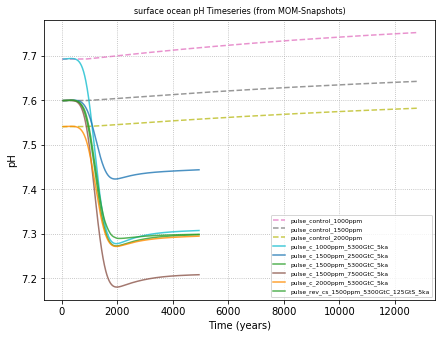

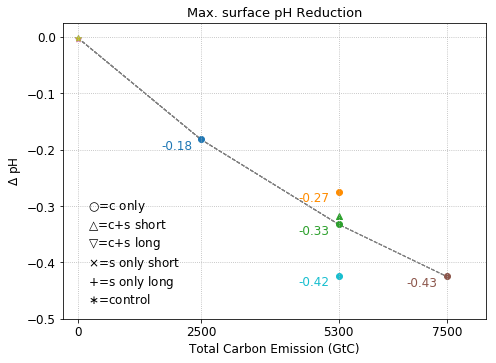

In [78]:
### short scenarios: Plot pH-Timeseries, calculate Fit for Control Runs, Determine excursion Amplitude relative to Control runs
### and Plot Map of dp13 and dp13-Change for Example-Run 

biogeo_df = pd.read_pickle("./biogeo_df_rev.pkl")

fig1=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax1=fig1.add_subplot(111)
ax1.grid(linestyle=':', zorder=0)

fig3=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax3=fig3.add_subplot(111)
ax3.grid(linestyle=':', zorder=0)

ph_regress_df=pd.DataFrame([], columns=['slope', 'intercept'], index=paths_pulse_control, dtype=float) #[], columns=['dp13_ts_globmean', 'years'], index=[]
for path in paths_pulse_control:
    [ph_mean,years]=biogeo_df.loc[path, ['ph_mean','years'] ]
    years=np.arange(0,13000-100,100)
    x=np.array(years).astype(np.int); y=np.array(ph_mean).astype(np.float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    ph_regress_df.loc[path, ['slope','intercept'] ]= [slope,intercept]
    #ax1.plot(x,slope*x+intercept, 'k--', alpha=0.8)
ppms=np.array([1000,1500,2000])

paths_plot=paths_pulse_control+paths_pulse_c_short_base+['pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka']
#paths_plot=paths_pulse_c_short_base
# paths_plot=paths_pulse_control+paths_pulse_c_short_base+paths_pulse_c_long+\
#         paths_pulse_cs_short+paths_pulse_cs_long+\
#         paths_pulse_s_short+paths_pulse_s_long

line_ph=[]; line_co2=[]

for path in paths_plot:
#for i in range(len(paths_plot)):    
#    path=paths_plot[i]
    #if path not in paths_pulse_failed_13c:
    if path in paths_pulse_control:
        mark='*'; linestyle='--'
    elif path in paths_pulse_c_short_base+paths_pulse_c_long:
        mark='o'; linestyle='-' 
    elif path in paths_pulse_s_short:
        mark='x'; linestyle='--'
    elif path in paths_pulse_s_long:
        mark='+'; linestyle='--'
    elif path in paths_pulse_cs_short:
        mark='^'; linestyle='-'
    elif path in paths_pulse_cs_long:
        mark='v'; linestyle='-' 
    
    if path in colors_paper_df.index:
        ccc=colors_paper_df.loc[path, 'color']
    else:
        ccc=colors_df.loc[path, 'color']

    [ph_ts_globmean,years]=biogeo_df.loc[path, ['ph_mean','years'] ] 
    
    
    if path in paths_pulse_control:
        years=np.arange(0,13000-100,100)
    else:
        years=np.arange(0,5000,10)
      
    ax1.plot(years,ph_ts_globmean, label=path, alpha=0.8, c=ccc, linestyle=linestyle) 

    if path in paths_pulse_c+paths_pulse_cs: # and path not in paths_pulse_failed_13c
        idx_GtC=path.find('GtC')
        GtC=int(path[idx_GtC-4:idx_GtC])
    else:
        GtC=0

    idx_ppm=path.find('ppm')
    ppm=int(path[idx_ppm-4:idx_ppm])

    [slope,intercept]=ph_regress_df.loc[paths_pulse_control[int(np.where(ppms==ppm)[0])], ['slope','intercept']]
    diff_ph=ph_ts_globmean-(np.array(slope).astype(np.float)*np.array(years).astype(np.int)+np.array(intercept).astype(np.float))
    ph_amplitude=np.min(diff_ph)
    
    #ax1.plot(years,diff_ph, label=path, alpha=0.8, c=colors_df.loc[path, 'color'], linestyle=linestyle) 
    

    
    if path in ['pulse_control_1500ppm','pulse_c_1500ppm_2500GtC_5ka','pulse_c_1500ppm_5300GtC_5ka', \
            'pulse_c_1500ppm_7500GtC_5ka']:
        line_ph.append(ph_amplitude); line_co2.append(GtC); 
    ax3.plot(line_co2[:],line_ph[:],'--', c='tab:gray', lw=1,zorder=0)
    
    ax3.scatter(GtC, ph_amplitude, c=ccc, marker=mark)
    if path in paths_pulse_c_short_base:
        ax3.annotate('%.2f' % (ph_amplitude) ,xy=(GtC,ph_amplitude),xytext=(-40, -10), \
                     textcoords='offset pixels', fontsize=12 ,color=ccc)

ax1.set_title('surface ocean pH Timeseries (from MOM-Snapshots)', fontsize=8)
ax1.legend(loc='lower right', fontsize='6')
#ax1.set_xlim([0,5000]); #ax71.set_ylim([0,5000]);
ax1.set_xlabel('Time (years)'); ax1.set_ylabel(r'pH');
#ax3.set_ylim([-0.5,0]);
ax3.tick_params(labelsize=12)
ax3.set_title('Max. surface pH Reduction', fontsize=13); 
ax3.set_xticks([0,2500,5300,7500]); 
ax3.set_xlim([-300,8300])
ax3.set_ylim([-0.5,0.025])
ax3.set_xlabel('Total Carbon Emission (GtC)', fontsize=12); 
ax3.set_ylabel(r'$\Delta$ pH', fontsize=12);
#ax73.text(0,-0.5,r'$\bigcirc$=c only'+'\n'+r'$\bigtriangleup$=c+s'+'\n'+r'$\times$=s only'+'\n'+r'$\ast$=control', fontsize=8)
ax3.text(200,-0.47,r'$\bigcirc$=c only'+'\n'+r'$\bigtriangleup$=c+s short'+'\n'+r'$\bigtriangledown$=c+s long'+'\n' \
         +r'$\times$=s only short'+'\n'+r'$+$=s only long'+'\n'+r'$\ast$=control', fontsize=12) #+r'$\Box$=control'+'\n'
plt.tight_layout()

fig3.savefig('./plot_pdf_files/FigS15a_pulse_rev_PH_diff.pdf' ,bbox_inches='tight', pad_inches=0.01, dpi=900)


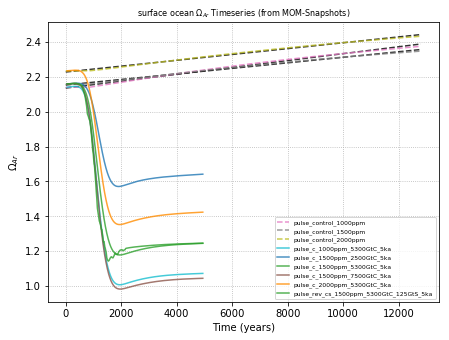

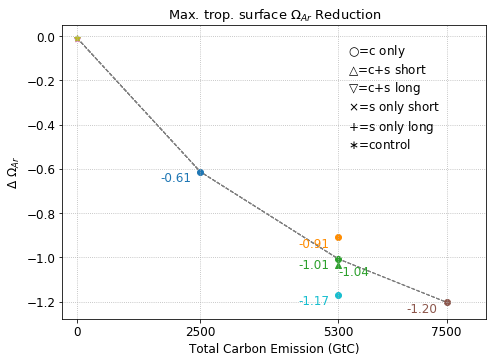

In [79]:
### short scenarios: Plot pH-Timeseries, calculate Fit for Control Runs, Determine excursion Amplitude relative to Control runs
### and Plot Map of dp13 and dp13-Change for Example-Run 

biogeo_df = pd.read_pickle("./biogeo_df_rev.pkl")

fig1=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax1=fig1.add_subplot(111)
ax1.grid(linestyle=':', zorder=0)

fig3=plt.figure(figsize=(7.0,5.15))
plt.clf()
ax3=fig3.add_subplot(111)
ax3.grid(linestyle=':', zorder=0)

ph_regress_df=pd.DataFrame([], columns=['slope', 'intercept'], index=paths_pulse_control, dtype=float) #[], columns=['dp13_ts_globmean', 'years'], index=[]
for path in paths_pulse_control:
    [ph_mean,years]=biogeo_df.loc[path, ['omega_trop','years'] ]
    years=np.arange(0,13000-100,100)
    x=np.array(years).astype(np.int); y=np.array(ph_mean).astype(np.float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    ph_regress_df.loc[path, ['slope','intercept'] ]= [slope,intercept]
    ax1.plot(x,slope*x+intercept, 'k--', alpha=0.8)
ppms=np.array([1000,1500,2000])

paths_plot=paths_pulse_control+paths_pulse_c_short_base+['pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka']
#paths_plot=paths_pulse_c_short_base
# paths_plot=paths_pulse_control+paths_pulse_c_short_base+paths_pulse_c_long+\
#         paths_pulse_cs_short+paths_pulse_cs_long+\
#         paths_pulse_s_short+paths_pulse_s_long
line_ph=[]; line_co2=[]

for path in paths_plot:
#for i in range(len(paths_plot)):    
#    path=paths_plot[i]
    #if path not in paths_pulse_failed_13c:
    if path in paths_pulse_control:
        mark='*'; linestyle='--'
    elif path in paths_pulse_c_short_base+paths_pulse_c_long:
        mark='o'; linestyle='-' 
    elif path in paths_pulse_s_short:
        mark='x'; linestyle='--'
    elif path in paths_pulse_s_long:
        mark='+'; linestyle='--'
    elif path in paths_pulse_cs_short:
        mark='^'; linestyle='-'
    elif path in paths_pulse_cs_long:
        mark='v'; linestyle='-' 
    
    if path in colors_paper_df.index:
        ccc=colors_paper_df.loc[path, 'color']
    else:
        ccc=colors_df.loc[path, 'color']

    [ph_ts_globmean,years]=biogeo_df.loc[path, ['omega_trop','years'] ] 
    
    if path in paths_pulse_control:
        years=np.arange(0,13000-100,100)
    else:
        years=np.arange(0,5000,10)
      
    ax1.plot(years,ph_ts_globmean, label=path, alpha=0.8, c=ccc, linestyle=linestyle) 

    if path in paths_pulse_c+paths_pulse_cs: # and path not in paths_pulse_failed_13c
        idx_GtC=path.find('GtC')
        GtC=int(path[idx_GtC-4:idx_GtC])
    else:
        GtC=0

    idx_ppm=path.find('ppm')
    ppm=int(path[idx_ppm-4:idx_ppm])

    [slope,intercept]=ph_regress_df.loc[paths_pulse_control[int(np.where(ppms==ppm)[0])], ['slope','intercept']]
    diff_ph=ph_ts_globmean-(np.array(slope).astype(np.float)*np.array(years).astype(np.int)+np.array(intercept).astype(np.float))
    ph_amplitude=np.min(diff_ph)
    
    #ax1.plot(years,diff_ph, label=path, alpha=0.8, c=colors_df.loc[path, 'color'], linestyle=linestyle) 
    
    if path in ['pulse_control_1500ppm','pulse_c_1500ppm_2500GtC_5ka','pulse_c_1500ppm_5300GtC_5ka', \
            'pulse_c_1500ppm_7500GtC_5ka']:
        line_ph.append(ph_amplitude); line_co2.append(GtC); 
    ax3.plot(line_co2[:],line_ph[:],'--', c='tab:gray', lw=1,zorder=0)
    
    ax3.scatter(GtC, ph_amplitude, c=ccc, marker=mark)
    if path in paths_pulse_c_short_base+paths_pulse_cs_short:
        if path in paths_pulse_c_short_base:
            anno_pos=(-40, -10)
        else:
            anno_pos=(0, -10)
        ax3.annotate('%.2f' % (ph_amplitude) ,xy=(GtC,ph_amplitude),xytext=anno_pos, \
                     textcoords='offset pixels', fontsize=12 ,color=ccc)

ax1.set_title('surface ocean $\Omega_{Ar}$ Timeseries (from MOM-Snapshots)', fontsize=8)
ax1.legend(loc='lower right', fontsize='6')
#ax1.set_xlim([0,5000]); #ax71.set_ylim([0,5000]);
ax1.set_xlabel('Time (years)'); ax1.set_ylabel(r'$\Omega_{Ar}$');
#ax3.set_ylim([-0.5,0]);
ax3.tick_params(labelsize=12)
ax3.set_title('Max. trop. surface $\Omega_{Ar}$ Reduction', fontsize=13); 
ax3.set_xticks([0,2500,5300,7500]); 
ax3.set_xlim([-300,8300])
ax3.set_xlabel('Total Carbon Emission (GtC)', fontsize=12); 
ax3.set_ylabel(r'$\Delta$ $\Omega_{Ar}$', fontsize=12);
#ax73.text(0,-0.5,r'$\bigcirc$=c only'+'\n'+r'$\bigtriangleup$=c+s'+'\n'+r'$\times$=s only'+'\n'+r'$\ast$=control', fontsize=8)
ax3.text(5500,-0.5,r'$\bigcirc$=c only'+'\n'+r'$\bigtriangleup$=c+s short'+'\n'+r'$\bigtriangledown$=c+s long'+'\n' \
         +r'$\times$=s only short'+'\n'+r'$+$=s only long'+'\n'+r'$\ast$=control', fontsize=12) #+r'$\Box$=control'+'\n'
plt.tight_layout()

fig3.savefig('./plot_pdf_files/FigS15b_pulse_rev_OMEGA_diff.pdf' ,bbox_inches='tight', pad_inches=0.01, dpi=900)


In [80]:
%%ferret
cancel data/all
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/all_snapshots_mom_annual.nc"
use "../climber/c3beta_tria_200Ma_1500ppm/topog.dta.nc"
let a=omegaplo_a[i=@ave,y=30S:30N@ave,k=1,l=@sbx:10,d=1]
let b=a[l=@min]-a
list b[l=@loc:0] !year 1539; 1939 mistakenly because of @sbx:100
!plot omegaplo_a[i=@ave,y=30S:30N@ave,k=1,l=@sbx:10,d=1]
!shade omegaplo_a[k=1,l=149:159@ave,d=1]
!contour/over/levels=(1) omegaplo_a[k=1,l=149:159@ave,d=1]
!shade omegaplo_a[k=1,l=189:199@ave,d=1]-omegaplo_a[k=1,l=1,d=1]
let omega_maxdiff_f=omegaplo_a[k=1,l=149:159@ave,d=1]-omegaplo_a[k=1,l=1,d=1]
let omega_min_f=omegaplo_a[k=1,l=149:159@ave,d=1]

let c=ph[i=@ave,j=@ave,k=1,l=@sbx:10,d=1]
let d=c[l=@min]-c
!list d[l=@loc:0] ! year 2059; erroneously year 1939
!shade ph[k=1,l=201:211@ave,d=1]-ph[k=1,l=1,d=1]
let ph_maxdiff_f=ph[k=1,l=201:211@ave,d=1]-ph[k=1,l=1,d=1]
let ph_min_f=ph[k=1,l=201:211@ave,d=1]

let h_ini=10^(-1*ph[k=1,l=1,d=1])
let h_end=10^(-1*ph[k=1,l=201:211@ave,d=1])
let h_diff=h_end-h_ini
!let h_diff=(h_end-h_ini)/h_ini*100
!shade h_diff

!let ccd_ini_f=missing(omegaplo_a[l=1,z=@loc:1],0)
!let ccd_end_f=missing(omegaplo_a[l=500,z=@loc:1],0)
!let ccd_diff_f
!shade ccd_end_f-ccd_ini_f
let ccd_unchanged_f=omegaplo_a[l=1,z=@loc:1,d=1]
let a=omegaplo_a[l=1,z=@loc:1,d=1]
!shade a
let b=if(ht[d=2]/100 le 1000 and i ge 48 and i le 64 and j ge 16 and j le 34) then ht[d=2]/100 else a
let ccd_ini_f=missing(b,0)
!shade ccd_ini_f
let ccd_end_f=missing(omegaplo_a[l=500,z=@loc:1,d=1],0)
!shade omegaplo_a[l=500,z=@loc:1,d=1]
!set window 2
!shade omegaplo_a[l=1,k=1,d=1]
!shade ccd_end_f-ccd_ini_f
!shade ccd_ini_f

VARIABLE : T (days) of 0 in A[L=@MIN]-A (days)
 LONGITUDE: 0E to 0E(360)
 LATITUDE : 30S to 30N
 DEPTH (m): 12.5
 T (days) : 3269.5 to 1800000 (location of 0) 360_DAY
 557834.

In [81]:
%ferret_getdata omega_maxdiff_f = omega_maxdiff_f
%ferret_getdata omega_min_f = omega_min_f
%ferret_getdata ph_maxdiff_f = ph_maxdiff_f
%ferret_getdata ph_min_f = ph_min_f
%ferret_getdata ccd_ini_f = ccd_ini_f
%ferret_getdata ccd_end_f = ccd_end_f
%ferret_getdata ccd_unchanged_f = ccd_unchanged_f
#%ferret_getdata ccd_diff_f = ccd_diff_f
omega_maxdiff=np.ma.masked_values(np.rot90(omega_maxdiff_f['data'][:,:,0,0,0,0]), -1e34); 
omega_min=np.ma.masked_values(np.rot90(omega_min_f['data'][:,:,0,0,0,0]), -1e34); 
ph_maxdiff=np.ma.masked_values(np.rot90(ph_maxdiff_f['data'][:,:,0,0,0,0]), -1e34);
ph_min=np.ma.masked_values(np.rot90(ph_min_f['data'][:,:,0,0,0,0]), -1e34);
ccd_ini=np.ma.masked_values(np.rot90(ccd_ini_f['data'][:,:,0,0,0,0]), -1e34);
ccd_end=np.ma.masked_values(np.rot90(ccd_end_f['data'][:,:,0,0,0,0]), -1e34);
ccd_unchanged=np.ma.masked_values(np.rot90(ccd_unchanged_f['data'][:,:,0,0,0,0]), -1e34);
#ccd_end=np.ma.masked_values(np.rot90(ccd_end_f['data'][:,:,0,0,0,0]), -1e34);

Message: omega_maxdiff_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: omega_min_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_maxdiff_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ph_min_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ccd_ini_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ccd_end_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ccd_unchanged_f is now available in python as a dictionary containing the variable's metadata and data array.

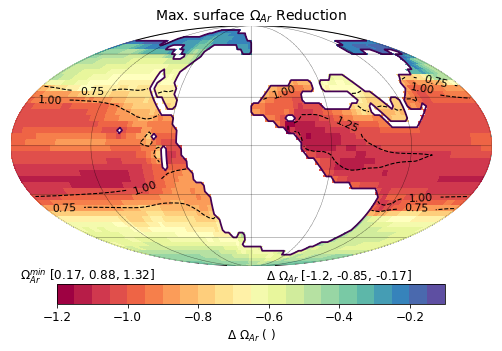

In [82]:
fig1=jplt.plot_world(omega_maxdiff, varname='$\Delta$ $\Omega_{Ar}$',  units=' ', cbar_tick_freq=4, lim_l=-1.2, lim_u=-0.1, cbar_delta=0.05,\
                     projection='moll', title='Max. surface $\Omega_{Ar}$ Reduction', colourmap='Spectral', continents='on',\
                     cont='on',var_cont=omega_min, var_cont_name='$\Omega_{Ar}^{min}$',cont_levs=[0.75,1,1.25], cont_anno='on', \
                     var_cont_unit=' ', cont_label_fmt='%.2f', linestyle='dashed', cont_labels='on')[1] 
# cont_levs=[-18,-12,-10,-8, -6]
fig1.savefig('./plot_pdf_files/FigS16a_pulse_rev_1500ppm_OMEGA_MaxDecrease.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

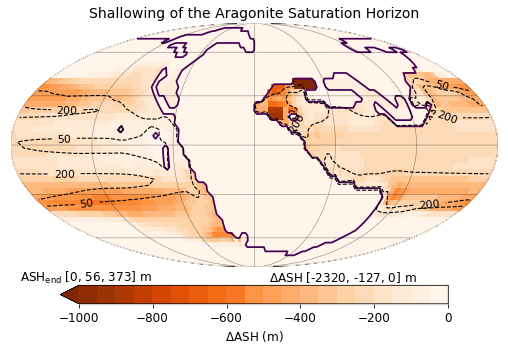

In [83]:
fig1=jplt.plot_world(ccd_end-ccd_ini, varname='$\Delta$ASH',  units='m', lim_l=-1000, lim_u=0, cbar_delta=50, cbar_tick_freq=4,\
                     projection='moll', continents='on', title='Shallowing of the Aragonite Saturation Horizon', colourmap='Oranges_r', var_digits=0, extend='min',\
                     cont='on',var_cont=ccd_end, var_cont_name='ASH$_{\mathrm{end}}$', cont_levs=[50,200], var_cont_digits=0, var_cont_unit='m', cont_label_fmt='%d', linestyle='dashed')[1] 
# , lim_l=-1000, lim_u=0, cbar_delta=50, cbar_tick_freq=2,var_cont=ccd_ini
fig1.savefig('./plot_pdf_files/FigS16b_pulse_rev_1500ppm_CCD.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

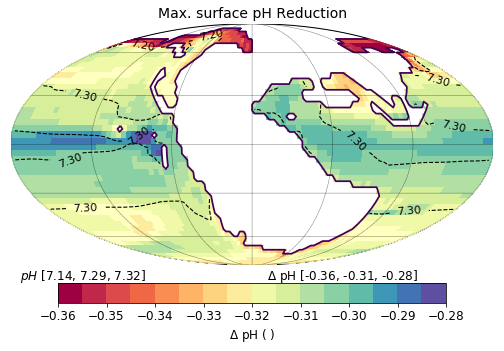

In [84]:
fig1=jplt.plot_world(ph_maxdiff, varname='$\Delta$ pH',  units=' ', cbar_tick_freq=2, lim_l=-0.36, lim_u=-0.28, cbar_delta=0.005,\
                     projection='moll', title='Max. surface pH Reduction', colourmap='Spectral', continents='on',\
                     cont='on',var_cont=ph_min, var_cont_name='$pH$',cont_levs=[7.2,7.3], cont_anno='on', \
                     var_cont_unit=' ', cont_label_fmt='%.2f', linestyle='dashed', cont_labels='on')[1] 
# cont_levs=[-18,-12,-10,-8, -6]
fig1.savefig('./plot_pdf_files/FigS17_pulse_rev_1500ppm_PH_MaxDecrease.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900)

### Fig. 4: Coral reef susceptibility

In [85]:
%%ferret
cancel data/all
!use "../climber/pulse_rev_cs_2000ppm_5300GtC_125GtS_5ka/all_snapshots_mom_annual.nc"
use "../climber/pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka/all_snapshots_mom_annual.nc"

let a=temp[i=@ave,j=@ave,k=1,l=@sbx:10,d=1]
let b=a[l=@min]-a
!list b[l=@loc:0] !year 1239
let nep_cold_f=proyear[l=119:129@ave,d=1]/360*12 
! /360*12 to get per day
let sst_cold_f=temp[k=1,l=119:129@ave,d=1]
let sss_cold_f=salt[k=1,l=119:129@ave,d=1]
let nep_warm_f=proyear[l=500,d=1]/360*12
let sst_warm_f=temp[k=1,l=500,d=1]
let sss_warm_f=salt[k=1,l=500,d=1]
let nep_ini_f=proyear[l=1,d=1]/360*12
let sst_ini_f=temp[k=1,l=1,d=1]
let sss_ini_f=salt[k=1,l=1,d=1]


In [86]:
%ferret_getdata nep_cold_f=nep_cold_f
%ferret_getdata sst_cold_f=sst_cold_f
%ferret_getdata sss_cold_f=sss_cold_f
#%ferret_getdata omegaplo_a_f=omegaplo_a_f
%ferret_getdata nep_warm_f=nep_warm_f
%ferret_getdata sst_warm_f=sst_warm_f
%ferret_getdata sss_warm_f=sss_warm_f
%ferret_getdata nep_ini_f=nep_ini_f
%ferret_getdata sst_ini_f=sst_ini_f
%ferret_getdata sss_ini_f=sss_ini_f

nep_cold=np.ma.masked_values(np.rot90(nep_cold_f['data'][:,:,0,0,0,0]), -1e34);
sst_cold=np.ma.masked_values(np.rot90(sst_cold_f['data'][:,:,0,0,0,0]), -1e34);
sss_cold=np.ma.masked_values(np.rot90(sss_cold_f['data'][:,:,0,0,0,0]), -1e34);
#omegaplo_a=np.ma.masked_values(np.rot90(omegaplo_a_f['data'][:,:,0,0,0,0]), -1e34)
nep_warm=np.ma.masked_values(np.rot90(nep_warm_f['data'][:,:,0,0,0,0]), -1e34);
sst_warm=np.ma.masked_values(np.rot90(sst_warm_f['data'][:,:,0,0,0,0]), -1e34);
sss_warm=np.ma.masked_values(np.rot90(sss_warm_f['data'][:,:,0,0,0,0]), -1e34);
nep_ini=np.ma.masked_values(np.rot90(nep_ini_f['data'][:,:,0,0,0,0]), -1e34);
sst_ini=np.ma.masked_values(np.rot90(sst_ini_f['data'][:,:,0,0,0,0]), -1e34);
sss_ini=np.ma.masked_values(np.rot90(sss_ini_f['data'][:,:,0,0,0,0]), -1e34);

Message: nep_cold_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: sst_cold_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: sss_cold_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: nep_warm_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: sst_warm_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: sss_warm_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: nep_ini_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: sst_ini_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: sss_ini_f is now available in python as a dictionary containing the variable's metadata and data array.

In [87]:
# Get Coral locations
# Download Scleractinia occurences from fossilworks (when downloaded directly from PBDB, plate reconstruction a little different)
def read_pdbd_csv(csv_file):
    with open(csv_file) as csvfile: #'pbdb_data_Scleractinia.csv' 'pbdb_data_Scleractinia_220_180Ma.csv'
         next(csvfile,None) #skip header
         spamreader = csv.reader(csvfile, delimiter=',')
         lon_col= []   
         lat_col= []
         row_prev=[0]
         for row in spamreader: #include each collection only once
             if row[0]!=row_prev[0]:    
                lon_col.append(row[9]) #33 18
                lat_col.append(row[8]) #34 19
             row_prev=row
         lon_paleo=np.array(list(filter(None, lon_col[0:])),dtype=float) #19
         lat_paleo=np.array(list(filter(None, lat_col[0:])),dtype=float) #19
         lonlat_paleo=np.transpose(np.array([lon_paleo,lat_paleo]))
    return lonlat_paleo

lonlat_paleo_norian=read_pdbd_csv('../coral_data/fossilworks_scleractinia_Norian_reef.csv')
lonlat_paleo_rhaetian=read_pdbd_csv('../coral_data/fossilworks_scleractinia_Rhaetian_reef.csv')
lonlat_paleo=np.append(lonlat_paleo_norian, lonlat_paleo_rhaetian,axis=0)

def filter_reef_loc(locs): #filter out locations which are very close to each other to avoid overwight of well-sampled regions
    locs_filt=np.zeros((2,2))
    for a in locs:
        #dist=r*np.arccos(np.sin(lat_c*np.pi/180)*np.sin(latos_2d*np.pi/180)+np.cos(lat_c*np.pi/180)*np.cos(latos_2d*np.pi/180)*np.cos((lon_c-lonos_2d)*np.pi/180)) 
        dist_min=np.min(6371*np.arccos(np.sin(a[1]*np.pi/180)*np.sin(locs_filt[:,1]*np.pi/180)+np.cos(a[1]*np.pi/180)*np.cos(locs_filt[:,1]*np.pi/180)*np.cos((a[0]-locs_filt[:,0])*np.pi/180))) 
        #condi=(np.min(abs(a[0]-locs_filt[:,0]))>0.2) & (np.min(abs(a[1]-locs_filt[:,1]))>0.2)
        if dist_min>250:
            locs_filt=np.vstack((locs_filt,a)) #,axis=1
    locs_filt=locs_filt[2:,:]
    return locs_filt

lonlat_paleo_norian_sel=filter_reef_loc(lonlat_paleo_norian)
lonlat_paleo_rhaetian_sel=filter_reef_loc(lonlat_paleo_rhaetian)
lonlat_paleo_sel=np.append(lonlat_paleo_norian_sel, lonlat_paleo_rhaetian_sel,axis=0)

a=np.copy(lonlat_paleo_norian_sel)
b=np.copy(lonlat_paleo_rhaetian_sel)

lonlat_paleo_norian_sel_tethys=a[(a[:,1]>=-40) & (a[:,1]<=40) & (a[:,0]>=0) & (a[:,0]<=150)]
lonlat_paleo_rhaetian_sel_tethys=b[(b[:,1]>=-40) & (b[:,1]<=40) & (b[:,0]>=0) & (b[:,0]<=150)]
lonlat_paleo_sel_tethys=np.append(lonlat_paleo_norian_sel_tethys, lonlat_paleo_rhaetian_sel_tethys,axis=0)

In [88]:
# Coral Susceptibility Functions
def sst_sens(sst):
    sst_mean=27
    sst_sigma=4.5
    sst_sensi_rudists=1./(1+np.exp(-1*(sst-18)))
    sst_sensi_corals=1./(np.sqrt(2*np.pi*sst_sigma**2))*np.exp(-1*((sst-sst_mean)**2)/(2*sst_sigma**2))
    sst_sensi_corals_norm=sst_sensi_corals/np.max(sst_sensi_corals)
    
    skewness=-6.5 #-2.5 #-2.5
    sst_mean_skew=30. #30.5 #29.5
    sst_sigma_skew=6 #5 #5.5  
    #mean, var, skew, kurt = skewnorm.stats(skewness, loc=sst_mean, scale=sst_sigma, moments='mvsk')    
    sst_sensi_corals_skewed = skewnorm.pdf(sst, skewness, loc=sst_mean_skew, scale=sst_sigma_skew) 
    
    dummy_ssts=np.arange(-2,40,0.01)
    dummy_sst_sensi_corals_skewed = skewnorm.pdf(dummy_ssts, skewness, loc=sst_mean_skew, scale=sst_sigma_skew)
    
    sst_sensi_corals_skewed_norm=sst_sensi_corals_skewed/np.max(dummy_sst_sensi_corals_skewed)
    
    
    return sst_sensi_corals_norm, sst_sensi_rudists, sst_sensi_corals_skewed_norm

def sss_sens(sss):
    sss_sigma=4.3
    sss_sensi=1./(np.sqrt(2*np.pi*sss_sigma**2))*np.exp(-1*((sss-35.25)**2)/(2*sss_sigma**2)) 
    sss_sensi_norm=sss_sensi/np.max(sss_sensi)
    return sss_sensi_norm

def npp_sens(npp):
    npp_sigma=0.22 #0.175
    npp_mean=0.125
    npp_sensi=1./(np.sqrt(2*np.pi*npp_sigma**2))*np.exp(-1*((npp-npp_mean)**2)/(2*npp_sigma**2))
    npp_sensi_norm=npp_sensi/np.max(npp_sensi)
    
    lower, upper = 0., 1000.
    a=(lower-npp_mean)/npp_sigma
    b=(upper-npp_mean)/npp_sigma 
    pdf_trunc=truncnorm.pdf(npp, a, b, loc=npp_mean, scale=npp_sigma)
    npp_sensi_trunc_norm=pdf_trunc/np.max(pdf_trunc)
    return npp_sensi_norm, npp_sensi_trunc_norm

ssts=np.arange(-2,40,0.1)
ssts_sens, ssts_sens_rudists, ssts_sens_skewed=sst_sens(ssts)[:]

ssss=np.arange(30,40,0.01)
ssss_sens=sss_sens(ssss)

npps=np.linspace(0,0.5,100)
npps_sens, npps_sens_trunc=npp_sens(npps)

# fig=plt.figure(figsize=(13,5))
# plt.clf()
# ax1 = fig.add_subplot(131)
# ax2 = fig.add_subplot(132)
# ax3 = fig.add_subplot(133)
# ax1.hist(sst_coralloc[sst_coralloc>5], bins=50, density=True)
# ax1.plot(ssts,ssts_sens)
# ax1.plot(ssts,ssts_sens_rudists)
# ax1.plot(ssts,ssts_sens_skewed)
# ax1.plot(ssts,0.4*ssts_sens_skewed,)
# ax2.plot(ssss,ssss_sens)
# ax3.plot(npps,npps_sens)
# ax3.plot(npps,npps_sens_trunc)
# plt.tight_layout()

In [89]:
#nep_npp_ratio=0.4756*nep**(-0.307/(1+0.307))
npp_cold=1./0.04756*nep_cold**(1./(1+0.307)) #following Laws 2011
npp_warm=1./0.04756*nep_warm**(1./(1+0.307))
npp_ini=1./0.04756*nep_ini**(1./(1+0.307))

a=1 #0.66
b=0 #0.062
c=0 #0.278
coral_suscept_cold=a*sst_sens(sst_cold)[2]+b*sss_sens(sss_cold)+c*npp_sens(npp_cold)[1]
coral_suscept_warm=a*sst_sens(sst_warm)[2]+b*sss_sens(sss_warm)+c*npp_sens(npp_warm)[1]
coral_suscept_ini=a*sst_sens(sst_ini)[2]+b*sss_sens(sss_ini)+c*npp_sens(npp_ini)[1]

kmt_225Ma=np.loadtxt('../climber/depth_adj_225Ma.dat', dtype=int)[:,:]
kmt_225Ma[kmt_225Ma>0]=1

In [90]:
csv_file='../coral_data/ReefLocations_Kopie.csv' #from reefbase.org 
with open(csv_file) as csvfile: #'pbdb_data_Scleractinia.csv' 'pbdb_data_Scleractinia_220_180Ma.csv'
     next(csvfile,None) #skip header
     spamreader = csv.reader(csvfile, delimiter=',')
     lon_col_reef= []   
     lat_col_reef= []
     #row_prev=[0]
     for row in spamreader: #include each collection only once
         #if row[0]!=row_prev[0]:    
        lon_col_reef.append(row[6]) #33 18
        lat_col_reef.append(row[5]) #34 19
         #row_prev=row
lon_reef=np.array(list(filter(None, lon_col_reef[0:])),dtype=float) #19
lat_reef=np.array(list(filter(None, lat_col_reef[0:])),dtype=float) #19
lonlat_reef=np.transpose(np.array([lon_reef,lat_reef]))

In [91]:
lon_reef_round=np.around(lon_reef)
lon_reef_round[lon_reef_round>=0]=lon_reef_round[lon_reef_round>=0]-0.5
lon_reef_round[lon_reef_round<0]=lon_reef_round[lon_reef_round<0]+0.5
#lon_reef_round[lon_reef_round!=0]=lon_reef_round-lon_reef_round/abs(lon_reef_round)*0.5
lat_reef_round=np.around(lat_reef)
lat_reef_round[lat_reef_round>=0]=lat_reef_round[lat_reef_round>=0]-0.5
lat_reef_round[lat_reef_round<0]=lat_reef_round[lat_reef_round<0]+0.5
#lat_reef_round[:]=lat_reef_round-lat_reef_round/abs(lat_reef_round)*0.5
lonlat_reef_round=np.transpose(np.array([lon_reef_round,lat_reef_round]))
lonlat_reef_uniq=np.unique(lonlat_reef_round, axis=0)

In [92]:
%%ferret
cancel data/all
CANCEL MODE LOGO
use "../coral_data/woa18_decav_t00_01.nc"
!sh da
!show axis depth
!shade t_an[k=1]
!let sst_an_f=t_an[k=1]
let sst_an_f=t_an[z=0:25@ave]
!plot t_an[k=1]
!plot/over t_an[z=0:25@ave]

In [93]:
%ferret_getdata sst_an_f=sst_an_f
sst_an_f
nooa_mask=(np.rot90(sst_an_f['data'][:,:,0,0,0,0])==-1e34)
sst_an=np.ma.masked_values(np.rot90(sst_an_f['data'][:,:,0,0,0,0]), -1e34);
lon_nooa=sst_an_f['axis_coords'][0]
lat_nooa=sst_an_f['axis_coords'][1]
lat_nooa=lat_nooa[::-1]
lon_nooa_2d,lat_nooa_2d=np.meshgrid(lon_nooa,lat_nooa)


Message: sst_an_f is now available in python as a dictionary containing the variable's metadata and data array.

In [94]:
sst_coralloc=[]
sst_coralloc_lon=[]
sst_coralloc_lat=[]
coral_suscept_coralloc=[]
r=6371

for i in range(len(lonlat_reef_uniq[:,0])):
            lon_r=lonlat_reef_uniq[i,0]
            lat_r=lonlat_reef_uniq[i,1] 
            sst_an_loc=sst_an[((lat_nooa_2d==lat_r) & (lon_nooa_2d==lon_r))]
            sst_loc=sst_an_loc.data
            sst_loc_mask=sst_an_loc.mask
            #sst_loc=sst_an[((lat_nooa_2d==lat_r) & (lon_nooa==lon_r))].data
            #if sst_loc.size>0 and sst_loc<100 and sst_loc>-100:
            if sst_loc.size>0:
                if sst_loc_mask==True:
                    #lon_c, lat_c=lonlat_paleo_sel[i,0:1+1]
                    dist=r*np.arccos(np.sin(lat_r*np.pi/180)*np.sin(lat_nooa_2d*np.pi/180)+np.cos(lat_r*np.pi/180)*np.cos(lat_nooa_2d*np.pi/180)*np.cos((lon_r-lon_nooa_2d)*np.pi/180)) #calculate distance to ocean cells, https://en.wikipedia.org/wiki/Great-circle_distance
                    dist_masked=np.ma.MaskedArray(dist, mask=nooa_mask)
                    #dist_min=np.ma.min(dist_p1_masked)
                    dist_min_idx=np.unravel_index(np.ma.argmin(dist_masked, axis=None), dist_masked.shape)
                    sst_coral_closest=sst_an[dist_min_idx] #corals_suscept at closest ocean cell
                    sst_loc=sst_coral_closest
                coral_suscept_coralloc=np.append(coral_suscept_coralloc,sst_sens(sst_loc)[2])
                sst_coralloc=np.append(sst_coralloc,sst_loc) 
                sst_coralloc_lon=np.append(sst_coralloc_lon,lon_r)
                sst_coralloc_lat=np.append(sst_coralloc_lat,lat_r)

sst_coralloc_lonlat=np.transpose(np.array([sst_coralloc_lon,sst_coralloc_lat]))
with open('coral_SSTatCoralLocs_modern.pickle', 'wb') as f:  
    pickle.dump(sst_coralloc, f)
#sst_coralloc_lonlat

/home/janlandw/.conda/envs/py3_jan/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in arccos


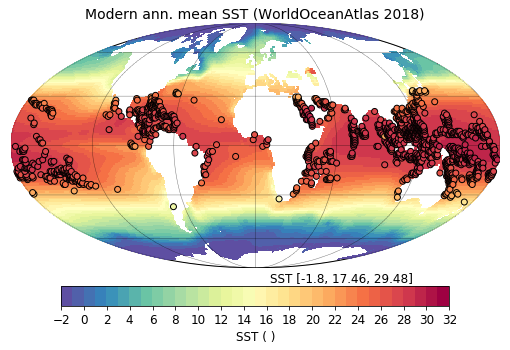

In [95]:
fig1=jplt.plot_world(sst_an, varname='SST', lim_l=-2, lim_u=32, cbar_delta=1, cbar_tick_freq=2, units=' ',\
                     projection='moll', title='Modern ann. mean SST (WorldOceanAtlas 2018)', axes='on',\
                     cont='off', var_cont_name='pH', cont_anno='off', var_cont_unit=' ', cont_levs=[0.4], cont_labels='off', linestyle='dashed',\
                    scat='on', var_scat=sst_coralloc_lonlat, scat_colored='on', scat_colors=sst_coralloc)[1] #, lim_l=0, lim_u=32 , var_cont=np.ma.masked_array(kmt_225Ma) , var_scat=lonlat_paleo_norian_sel , var_scat2=lonlat_paleo_rhaetian_sel , continents='off'
#fig1.savefig('./PlotsForPaper/equi_1500ppm_CoralReefSusceptibility.pdf',bbox_inches='tight', pad_inches=0.01, dpi=900) 

In [96]:
def calc_sst_atproxyloc(sst): #calculate average of the susceptibility in ocean cells closest to the proxy locations
    latos, lonos, lonos_2d, latos_2d=jan.grid_gen(region='ocean', cell='T')
    r=6371
    with open('../climber/continental_mask.pickle', 'rb') as f:  
        continental_mask = pickle.load(f, encoding='latin1' ) #Python3: , encoding='latin1' 

    sst_atproxyloc=np.zeros(lonlat_paleo.shape[0])
    #coral_suscept_atproxyloc_tethys=np.zeros(lonlat_paleo_sel_tethys.shape[0])
    for i in range(lonlat_paleo.shape[0]):
        lon_c, lat_c=lonlat_paleo[i,0:1+1]
        dist=r*np.arccos(np.sin(lat_c*np.pi/180)*np.sin(latos_2d*np.pi/180)+np.cos(lat_c*np.pi/180)*np.cos(latos_2d*np.pi/180)*np.cos((lon_c-lonos_2d)*np.pi/180)) #calculate distance to ocean cells, https://en.wikipedia.org/wiki/Great-circle_distance
        dist_masked=np.ma.MaskedArray(dist, mask=1-continental_mask)
        #dist_min=np.ma.min(dist_p1_masked)
        dist_min_idx=np.unravel_index(np.ma.argmin(dist_masked, axis=None), dist_masked.shape)
        sst_atproxyloc[i]=sst[dist_min_idx] #corals_suscept at closest ocean cell
               
    #condi_tethys=(lonlat_paleo_sel[:,1]>=-40) & (lonlat_paleo_sel[:,1]<=40) & (lonlat_paleo_sel[:,0]>=0) & (lonlat_paleo_sel[:,0]<=120)    
    
    #coral_suscept_score=np.mean(coral_suscept_atproxyloc)
    #coral_suscept_score_tethys=np.mean(coral_suscept_atproxyloc[condi_tethys])
    
    return sst_atproxyloc #coral_suscept_score, coral_suscept_atproxyloc, coral_suscept_score_tethys

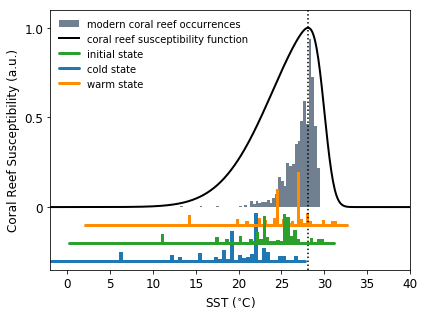

In [97]:
with open('coral_SSTatCoralLocs_modern.pickle', 'rb') as f:  
    sst_coralloc=pickle.load(f, encoding='latin1')

sst_ini_atproxyloc=calc_sst_atproxyloc(sst_ini)
sst_warm_atproxyloc=calc_sst_atproxyloc(sst_warm)
sst_cold_atproxyloc=calc_sst_atproxyloc(sst_cold)    
    
fig=plt.figure(figsize=(6,4.5))
plt.clf()
ax1 = fig.add_subplot(111)
ax1.hist(sst_coralloc[sst_coralloc>5], bins=50, density=True, color='slategrey', label='modern coral reef occurrences')
ax1.plot(ssts,ssts_sens_skewed*0.5,'-k', lw=2, label='coral reef susceptibility function')
ax1.axvline(x=ssts[np.argmax(ssts_sens_skewed)], c='k', ls=':')
ax1.set_yticks([0,0.25,0.5])
ax1.set_yticklabels(['0','0.5','1.0'])
#ticks = ax1.get_yticks()*2
#ax1.set_yticklabels(np.round(ticks,1))
xlim_l=-2.
xlim_u=40.
ax1.set_xlim(xlim_l,xlim_u)
ax1.set_ylim(-0.175,0.55)
ax1.set_xlabel('SST ($\mathsf{^{\circ}C}$)', fontsize=12)
ax1.set_ylabel('Coral Reef Susceptibility (a.u.)', fontsize=12)


ax1.plot((np.min(sst_ini),np.max(sst_ini)),(-0.1,-0.1),'-',c='tab:green', lw=3, solid_capstyle='round', label='initial state', zorder=11)
hist, bins_ = np.histogram(sst_ini_atproxyloc,bins=50) #, density=True
freq = 0.5*hist/np.sum(hist)
ax1.bar(bins_[:-1], freq, align="edge", width=np.diff(bins_), color='tab:green', bottom=-0.1, zorder=11)
#v_ini=ax1.violinplot(sst_ini_atproxyloc, positions=[-0.07], showmeans=False, showmedians=False, showextrema=False, vert=False, widths=0.03)
#for pc in v_ini['bodies']:
#    pc.set_facecolor('tab:green')
#    pc.set_edgecolor('tab:green')
#    pc.set_alpha(1)
#ax1.plot((np.min(sst_ini_atproxyloc),np.max(sst_ini_atproxyloc)),(-0.07,-0.07),'-',c='tab:green', lw=5, solid_capstyle='round')

ax1.plot((np.min(sst_cold),np.max(sst_cold)),(-0.15,-0.15),'-',c='tab:blue', lw=3, solid_capstyle='round', label='cold state')
hist, bins_ = np.histogram(sst_cold_atproxyloc,bins=50) #, density=True
freq = 0.5*hist/np.sum(hist)
ax1.bar(bins_[:-1], freq, align="edge", width=np.diff(bins_), color='tab:blue', bottom=-0.15)
#v_cold=ax1.violinplot(sst_cold_atproxyloc, positions=[-0.11], showmeans=False, showmedians=False, showextrema=False, vert=False, widths=0.03)
#for pc in v_cold['bodies']:
#    pc.set_facecolor('tab:blue')
#    pc.set_edgecolor('tab:blue')
#    pc.set_alpha(1)
#ax1.plot((np.min(sst_cold_atproxyloc),np.max(sst_cold_atproxyloc)),(-0.11,-0.11),'-',c='tab:blue', lw=5, solid_capstyle='round')

ax1.plot((np.min(sst_warm),np.max(sst_warm)),(-0.05,-0.05),'-',c='darkorange', lw=3, solid_capstyle='round', label='warm state')
#ax1.hist(sst_warm_atproxyloc,bins=100, color='tab:red', density=True, histtype='stepfilled', bottom=-0.03)
hist, bins_ = np.histogram(sst_warm_atproxyloc,bins=50) #, density=True
freq = 0.5*hist/np.sum(hist)
ax1.bar(bins_[:-1], freq, align="edge", width=np.diff(bins_), color='darkorange', bottom=-0.05)
#v_warm=ax1.violinplot(sst_warm_atproxyloc, positions=[-0.03], showmeans=False, showmedians=False, showextrema=False, vert=False, widths=0.03)
#for pc in v_warm['bodies']:
#    pc.set_facecolor('tab:red')
#    pc.set_edgecolor('tab:red')
#    pc.set_alpha(1)
#ax1.plot((np.min(sst_warm_atproxyloc),np.max(sst_warm_atproxyloc)),(-0.03,-0.03),'-',c='tab:red', lw=5, solid_capstyle='round')

handles, labels = ax1.get_legend_handles_labels()
order = [4,0,1,2,3]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],frameon=False)
#ax1.legend(frameon=False)
#ax1.axhline(y=-0.05, xmin=np.min(sst_ini)/(xlim_u-xlim_l), xmax=np.max(sst_ini))

ax1.tick_params(labelsize=12)
plt.tight_layout()
fig.savefig('./plot_pdf_files/Fig4_coral_susceptibility_function_rev.pdf')

### Fig. 3: Pulse Synthesis Plot 

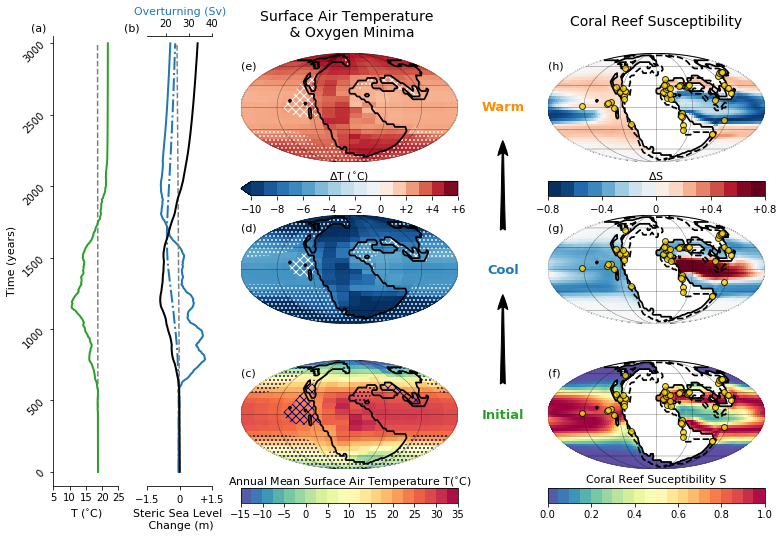

In [98]:
var_scat=lonlat_paleo_norian_sel
var_scat2=lonlat_paleo_rhaetian_sel
with open('../climber/continental_mask.pickle', 'rb') as f:  
    continental_mask = pickle.load(f, encoding='latin1') #Python3: , encoding='latin1'

fig=plt.figure(figsize=(11,7.5))
plt.clf()
gs = GridSpec(5, 5,height_ratios=[1,0.1,1,1,0.1], width_ratios=[0.3,0.3,1,0.15,1])
ax1 = plt.subplot(gs[:-1,0]) #, ymargin=5
ax11 = plt.subplot(gs[:-1,1]) #sharey=ax1

#ax112 = ax11.twiny()

ax21 = plt.subplot(gs[3,2])
ax22 = plt.subplot(gs[2,2])
ax23 = plt.subplot(gs[0,2])

ax24 = plt.subplot(gs[1,2]) #; ax24.axis('off')
ax25 = plt.subplot(gs[4,2])

ax31 = plt.subplot(gs[3,4])
ax32 = plt.subplot(gs[2,4])
ax33 = plt.subplot(gs[0,4])

ax34 = plt.subplot(gs[1,4])
ax35 = plt.subplot(gs[4,4])

ax_text = plt.subplot(gs[:,3]); ax_text.axis('off')
#ax_text1 = plt.subplot(gs[0,2]); ax_text1.axis('off')
#ax_text2 = plt.subplot(gs[2,2]); ax_text2.axis('off')
#ax_text3 = plt.subplot(gs[3,2]); ax_text3.axis('off')
#ax21.grid(linestyle=':', zorder=0)

lim_l=-10.
lim_u=6.
mycmap = jplt.shiftedColorMap(matplotlib.cm.RdBu_r, midpoint=abs(lim_l)/(lim_u+abs(lim_l)))
#mycmap = jplt.shiftedColorMap(matplotlib.cm.RdBu_r, stop=(abs(lim_l)+lim_u)/(2.*abs(lim_l)))

times=np.arange(0,5000,1)  
ax1.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka[0:3000],times[0:3000],'-', c='tab:green', lw=2) 
#ax1.scatter(ts_ann_pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka[0:2800],times[0:2800], c=ts_ann_pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka[0:2800], marker='.', cmap=mycmap, alpha=0.2, zorder=3)
ax1.plot(ts_ann_pulse_control_1500ppm[0:3000],times[0:3000], '--', c='tab:grey', zorder=1)
#ax1.set_aspect(0.04)
#ax1.set_ymargin(0.1)
#ax1.axis('off')
ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlim([5,25])
ax1.set_ylim([-100,3050])
ax1.set_xticks([5,10,15,20,25])
for tick in ax1.get_yticklabels():
    tick.set_rotation(45)
ax1.set_xlabel(r'T ($\mathsf{^{\circ}C}$)', fontsize=11)
ax1.set_ylabel(r'Time (years)', fontsize=11)

ax11.plot(eta_steric[0:3000],times[0:3000], '-', c='k', zorder=4, lw=2)
ax11.plot(eta_steric_control_1500ppm[0:3000],times[0:3000], '--', c='tab:grey', zorder=1)
#ax11.set_aspect(0.04*((1.5-(-1.5))/(25-5)))

ax11.spines['right'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.spines['top'].set_visible(False)
ax11.axes.get_yaxis().set_visible(False)
ax11.set_xlim([-1.5,1.5])
ax11.set_ylim([-100,3050])
ax11.set_xticks([-1.5,0,1.5])
ax11.set_xticklabels(['$-1.5$','$0$','$+1.5$'])
ax11.set_xlabel('Steric Sea Level \n Change (m)', fontsize=11)
ax11.xaxis.label.set_color('k')

ax11.set_zorder(10)
ax11.patch.set_visible(False)
ax112 = ax11.twiny()

ax112.plot(glb_over[0:3000],times[0:3000], '-', c='tab:blue', zorder=3, lw=2) #c='teal'
ax112.plot(glb_over_c[0:3000],times[0:3000], '-.', c='tab:blue', zorder=3, lw=2)
#ax112.set_aspect(0.04*((1.5-(-1.5))/(25-5))*(6-1/(25-5)), adjustable='box-forced')
ax112.spines['right'].set_visible(False)
ax112.spines['left'].set_visible(False)
ax112.spines['bottom'].set_visible(False)
ax112.axes.get_yaxis().set_visible(False)
ax112.set_xlim([12,40])
ax112.set_xticks([20,30,40])
#ax112.set_xlim([1,6])
#ax112.set_xticks([1,2,3,4,5,6])
ax112.set_ylim([-100,3050])
#ax112.set_xticklabels(['$-1.5$','$0$','$+1.5$'])
ax112.set_xlabel('Overturning (Sv)', fontsize=11) #Average Meridional #,fontweight='bold'
ax112.xaxis.label.set_color('tab:blue')

latso, lonso, xo, yo=jan.grid_gen(region='ocean', cell='T')

xpa, ypa=jan.grid_gen(region='atmo', cell='p')[2:4]
xua,yua=jan.grid_gen(region='atmo', cell='u')[2:4]
xta,yta=jan.grid_gen(region='atmo', cell='T')[2:4]

xpo, ypo=jan.grid_gen(region='ocean', cell='p')[2:4] 
xuo,yuo=jan.grid_gen(region='ocean', cell='u')[2:4]
xto,yto=jan.grid_gen(region='ocean', cell='T')[2:4]           

xtac,ytac=jan.grid_gen(region='atmo', cell='T')[2:4]
xtoc,ytoc=jan.grid_gen(region='ocean', cell='T')[2:4]

x_1deg, y_1deg=jan.grid_gen(region='atmo_1deg', cell='p')[2:4] 
xu_1deg,yu_1deg=jan.grid_gen(region='atmo_1deg', cell='u')[2:4]
xt_1deg,yt_1deg=jan.grid_gen(region='atmo_1deg', cell='T')[2:4]

for axi in [ax21, ax22, ax23, ax31, ax32, ax33]:
    m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0, ax=axi)
    m.drawmapboundary()  
    m.drawparallels(np.arange(-90.,120.,30.), linewidth=0.5)
    m.drawmeridians(np.arange(0.,420.,60.), linewidth=0.5)

xpam, ypam = m(xpa, ypa)
xom, yom = m(xo, yo)
xpom, ypom = m(xpo, ypo)

#xtm,ytm=m(xt,yt)   
#xtcm,ytcm=m(xtc,ytc)

x_scat, y_scat=m(var_scat[:,0],var_scat[:,1])
x_scat2, y_scat2=m(var_scat2[:,0],var_scat2[:,1])

a21=ax21.pcolor(xpam, ypam, ts_ini_1500ppm, cmap='Spectral_r',vmin=-15, vmax=35)
ax21.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')
cbar=fig.colorbar(mappable=a21, cax=ax25, orientation='horizontal', boundaries=np.arange(-15,35+2.5,2.5), ticks=np.arange(-15,35+2.5,5)) #, boundaries=np.arange(-11,6+1,1) drawedges=True, #cbar.dividers.set_color('white')  , pad=-0.5 ax=[ax21, ax22, ax23, ax24], c
#cbar.ax.set_xticklabels(['$-10$','$-8$','$-6$','$-4$','$-2$','$0$','$+2$', '$+4$', '$+6$'])
cbar.set_label(r'Annual Mean Surface Air Temperature T($\mathsf{^{\circ}C}$)', labelpad=-45, fontsize=11)
cbar.ax.tick_params(labelsize=10);


a22=ax22.pcolor(xpam, ypam, ts_diff_maxcool, cmap=mycmap, vmin=lim_l, vmax=lim_u) # , cmap=mycmap
ax22.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')

a23=ax23.pcolor(xpam, ypam, ts_diff_maxwarm, cmap=mycmap, vmin=lim_l, vmax=lim_u) #, vmin=1.5, vmax=6
ax23.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')
cbar=fig.colorbar(mappable=a23, cax=ax24, orientation='horizontal', extend='min', boundaries=np.arange(-11,6+1,1)) #, boundaries=boundaries, ticks=ticks drawedges=True, #cbar.dividers.set_color('white')  , pad=-0.5 ax=[ax21, ax22, ax23, ax24], c
cbar.ax.set_xticklabels(['$-10$','$-8$','$-6$','$-4$','$-2$','$0$','$+2$', '$+4$', '$+6$'])
cbar.set_label(r'$\Delta$T ($\mathsf{^{\circ}C}$)', labelpad=-45, fontsize=11)
#cbar.set_label("%s (%s)" % (varname, units), fontsize=12) , \
#           shrink=0.7 , pad=0.06
cbar.ax.tick_params(labelsize=10);

a31=ax31.pcolor(xpom, ypom, coral_suscept_ini, cmap='Spectral_r') #,vmin=-15, vmax=35
ax31.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')
ax31.contour(xom,yom,kmt_225Ma,  levels=[0.5], colors='k',linestyles='dashed', linewidths=1.75)
ax31.scatter(x_scat, y_scat,edgecolors='k', c='gold', zorder=5, s=35, alpha=0.8) #, marker='*', s=125
ax31.scatter(x_scat2, y_scat2,edgecolors='k', c='gold', zorder=5, s=35, alpha=0.8) 
cbar=fig.colorbar(mappable=a31, cax=ax35, orientation='horizontal', boundaries=np.arange(0,1+0.05,0.05), ticks=np.arange(0,1+0.2,0.2)) #, boundaries=np.arange(-11,6+1,1) drawedges=True, #cbar.dividers.set_color('white')  , pad=-0.5 ax=[ax21, ax22, ax23, ax24], c
#cbar.ax.set_xticklabels(['$-10$','$-8$','$-6$','$-4$','$-2$','$0$','$+2$', '$+4$', '$+6$'])
cbar.set_label('Coral Reef Suceptibility S', labelpad=-45, fontsize=11)
cbar.ax.tick_params(labelsize=10);

ax32.pcolor(xpom, ypom, coral_suscept_cold-coral_suscept_ini, cmap='RdBu_r', vmin=-0.7, vmax=0.7) #,vmin=-15, vmax=35
ax32.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75,colors='k')
ax32.contour(xom,yom,kmt_225Ma,  levels=[0.5], colors='k',linestyles='dashed', linewidths=1.75)
ax32.scatter(x_scat, y_scat,edgecolors='k', c='gold', zorder=5, s=35, alpha=0.8) #, marker='*', s=125
ax32.scatter(x_scat2, y_scat2,edgecolors='k', c='gold', zorder=5, s=35, alpha=0.8) 

a33=ax33.pcolor(xpom, ypom, coral_suscept_warm-coral_suscept_ini, cmap='RdBu_r', vmin=-0.7, vmax=0.7) #,vmin=-15, vmax=35
ax33.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')
ax33.contour(xom,yom,kmt_225Ma,  levels=[0.5], colors='k',linestyles='dashed', linewidths=1.75)
ax33.scatter(x_scat, y_scat,edgecolors='k', c='gold', zorder=5, s=35, alpha=0.8) #, marker='*', s=125 'xkcd:bright blue'
ax33.scatter(x_scat2, y_scat2,edgecolors='k', c='gold', zorder=5, s=35, alpha=0.8)  #'xkcd:green'

cbar=fig.colorbar(a33, cax=ax34, orientation='horizontal', boundaries=np.arange(-0.8,0.9,0.1), ticks=[-0.8,-0.4,0,0.4,0.8]) #drawedges=True, #cbar.dividers.set_color('white')  
cbar.ax.set_xticklabels(['$-0.8$', '$-0.4$','$0$','$+0.4$', '$+0.8$'])
cbar.set_label(r'$\Delta$S', labelpad=-45, fontsize=11)
#,boundaries=boundaries, ticks=ticks,, extend=extend
#cbar.set_label("%s (%s)" % (varname, units), fontsize=12) , \
#           shrink=0.7 , pad=0.06
cbar.ax.tick_params(labelsize=10);

matplotlib.rcParams['hatch.color']='navy' #whitesmoke
#ax21.pcolor(xom, yom, np.ma.masked_greater(oxy_cs_ini, 100), hatch='xxx', alpha=0.)
#ax21.pcolor(xom, yom, np.ma.masked_less(oxy_cs_ini, 200), hatch='...', alpha=0. )
ax21.contourf(xom, yom, oxy_cs_ini, hatches=['xxx',None], levels=[0,100], colors='none')
ax21.contourf(xom, yom, oxy_cs_ini, hatches=['...',None], levels=[200,1000], colors='none')
matplotlib.rcParams['hatch.color']='w'
#ax22.pcolor(xom, yom, np.ma.masked_greater(oxy_cs_cool, 100), hatch='xxx', alpha=0.)
#ax22.pcolor(xom, yom, np.ma.masked_less(oxy_cs_cool, 200), hatch='...', alpha=0. )
ax22.contourf(xom, yom, oxy_cs_cool, hatches=['xxx',None], levels=[0,100], colors='none')
ax22.contourf(xom, yom, oxy_cs_cool, hatches=['...',None], levels=[200,1000], colors='none')
matplotlib.rcParams['hatch.color']='w'
#ax23.pcolor(xom, yom, np.ma.masked_greater(oxy_cs_warm, 100), hatch='xxx', alpha=0.)
#ax23.pcolor(xom, yom, np.ma.masked_less(oxy_cs_warm, 200), hatch='...', alpha=0. )
ax23.contourf(xom, yom, oxy_cs_warm, hatches=['xxx',None], levels=[0,100], colors='none')
ax23.contourf(xom, yom, oxy_cs_warm, hatches=['...',None], levels=[200,1000], colors='none')


ax_text.text(0.5,0.18,'Initial',fontsize=13, horizontalalignment='center', color='tab:green',fontweight='bold')
ax_text.text(0.5,0.49,'Cool',fontsize=13, horizontalalignment='center', color='tab:blue',fontweight='bold')
ax_text.text(0.5,0.84,'Warm',fontsize=13, horizontalalignment='center', color='darkorange',fontweight='bold')

arrow=matplotlib.patches.FancyArrowPatch(posA=(0.5,0.25),posB=(0.5,0.45),arrowstyle=matplotlib.patches.ArrowStyle.Fancy(head_length=.3, head_width=.2, tail_width=.1), mutation_scale=50, edgecolor='k', facecolor='k') #, shrinkA=10                    #
ax_text.add_patch(arrow)
arrow2=matplotlib.patches.FancyArrowPatch(posA=(0.5,0.58),posB=(0.5,0.78),arrowstyle=matplotlib.patches.ArrowStyle.Fancy(head_length=.3, head_width=.2, tail_width=.1), mutation_scale=50, edgecolor='k', facecolor='k') #, shrinkA=10                    #
ax_text.add_patch(arrow2)
#ax_text.arrow(0.5, 0.25, 0, 0.2,fc='k', ec='k', alpha=1, width=0.05, head_width=0.2, head_length=0.05,length_includes_head=True)
#ax_text.arrow(0.5, 0.58, 0, 0.2,fc='k', ec='k', alpha=1, width=0.05, head_width=0.2, head_length=0.05,length_includes_head=True)

ax1.text(-0.35,1.01,'(a)',transform=ax1.transAxes,fontsize=11)
ax11.text(-0.35,1.01,'(b)',transform=ax11.transAxes,fontsize=11)

ax21.text(0,0.85,'(c)',transform=ax21.transAxes,fontsize=11)
ax22.text(0,0.85,'(d)',transform=ax22.transAxes,fontsize=11)
ax23.text(0,0.85,'(e)',transform=ax23.transAxes,fontsize=11)

ax31.text(0,0.85,'(f)',transform=ax31.transAxes,fontsize=11)
ax32.text(0,0.85,'(g)',transform=ax32.transAxes,fontsize=11)
ax33.text(0,0.85,'(h)',transform=ax33.transAxes,fontsize=11)

ax23.text(0.5,1.15,'Surface Air Temperature \n & Oxygen Minima',transform=ax23.transAxes,fontsize=14, horizontalalignment='center')
ax33.text(0.5,1.25,'Coral Reef Susceptibility',transform=ax33.transAxes,fontsize=14, horizontalalignment='center')

plt.tight_layout(h_pad=-4.25, w_pad=-2) #h_pad=-2,

fig.savefig('./plot_pdf_files/Fig3_pulse_rev_Overview_InitialColdWarm.pdf',bbox_inches='tight', pad_inches=0.05, dpi=900)
#fig.savefig('./PlotsForPaper/pulse_corr_Overview_InitialColdWarm.png',bbox_inches='tight', pad_inches=0.05, dpi=900)

### Fig. S20: Phytoplankton growth rate temperature characteristic

In [99]:
### Dependence of maximal growth rate on Temperature:
Ts=np.linspace(-2,40,200)    
#classical Eppley curve:
a_epp=0.59; b_epp=0.0633    
mumax_eppley=a_epp*np.exp(b_epp*Ts) 
#different proposed curves:   
mumax_six=0.6*1.066**Ts #=ft
mumax_biss=0.81*np.exp(0.0613*Ts) #see Bissinger 2008 and Kremer 2017 
mumax_mte=0.5*np.exp(0.0498*Ts) #see Kremer 2017; intercept is chosen arbitrarily

#Introduce new dependence with thermal limitation:
#load equilibrium SST's to determine T. in the tropics, which is approx. the optimal T.:
nc_f = '../climber/c3beta_tria_200Ma_1500ppm/snapshots.004002.01.01.dta.nc' 

nc_fid = Dataset(nc_f, 'r')
#nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
temp=np.flipud(np.ma.mean(nc_fid.variables['temp'][:,0,:,:], axis=0))
#temp_zonalmean=jan.global_mean(temp,region='global',grid='ocean',axis='zonal')
#jplt.plot_world(temp,projection='moll')

#Determine parameters for the new curve:
Topttrop=np.max(temp)-0.25 #~the annual mean T. in the Tropics, because there it is approximately equal to the opt. T.
Topttrop=31.1-2.5 #31.1 is max. SST for 1500ppm; and 27degC of M. Thomas is 2.5 degC lower than modern max. SST of 29.5 (WOA)
Tmax=Topttrop+6 #the T., where growth becomes zero; in Thomas 2017 the difference between Topt and Tmax is ~5 degC
#in Thomas 2015 in Tropics Topt is ~28degC and Tmax ~35degC
#a=0.59; b=0.0633
a=0.65; b=0.065
#a=0.64; b=0.064 #we can slightly increase the Eppley-coefficients to compensate for the decreased optimal growth rate
mumax_eppley_new=a*np.exp(b*Ts) 
#determine Parameters c and numerically to fulfill the two boundary conditions (Maximum at Topt, Zero at Tmax)
def equations(p):
    c, d = p
    return (c-a*b/d*np.exp(b*Topttrop), d-(b*Tmax-np.log(c/a))/(Tmax-Topttrop))
c, d =  fsolve(equations, (1, 1))
mumax_new=mumax_eppley_new-c*np.exp(d*(Ts-Topttrop))
mumax_new[mumax_new<0]=0

#modern:
Topttrop_modern=27
Tmax_modern=Topttrop_modern+6
def equations(p):
    c_modern, d_modern = p
    return (c_modern-a*b/d_modern*np.exp(b*Topttrop_modern), d_modern-(b*Tmax_modern-np.log(c_modern/a))/(Tmax_modern-Topttrop_modern))
c_modern, d_modern =  fsolve(equations, (1, 1))
mumax_new_modern=mumax_eppley_new-c_modern*np.exp(d_modern*(Ts-Topttrop_modern))
mumax_new_modern[mumax_new_modern<0]=0

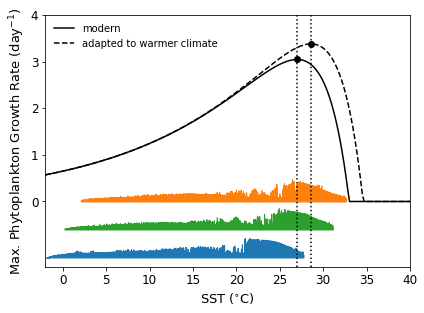

In [100]:
#Plot:
fig1=plt.figure(figsize=(6,4.5))
plt.clf()
ax1 = fig1.add_subplot(111) 
#ax1.plot(Ts,mumax_six,'--k',lw=1.5, label=r'modern (Eppley)', zorder=3) #label=r'Eppley/Six&Maier-Reimer 1996: $\mu_{max}=0.6\cdot 1.066^T$'
ax1.plot(Ts,mumax_new_modern,'-k',lw=1.5, label=r'modern', zorder=3) # (limited)
ax1.plot(Ts,mumax_new,'--k',lw=1.5, label=r'adapted to warmer climate', zorder=3)

def smooth(x,window_len=11,window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

ss=sst_warm.data; sst_warm_dummy=ss[ss!=-1e+34].flatten()
nn=nep_warm.data; nep_warm_dummy=nn[nn!=-1e+34].flatten()
sst_nep_warm=pd.DataFrame({'sst': sst_warm_dummy, 'nep':nep_warm_dummy.flatten()})
sst_nep_warm_sort=sst_nep_warm.sort_values(by=['sst'])
#sst_nep_warm_smooth=sst_nep_warm_sort.rolling(100, on='nep').mean()

ss=sst_ini.data; sst_ini_dummy=ss[ss!=-1e+34].flatten()
nn=nep_ini.data; nep_ini_dummy=nn[nn!=-1e+34].flatten()
sst_nep_ini=pd.DataFrame({'sst': sst_ini_dummy, 'nep':nep_ini_dummy.flatten()})
sst_nep_ini_sort=sst_nep_ini.sort_values(by=['sst'])

ss=sst_cold.data; sst_cold_dummy=ss[ss!=-1e+34].flatten()
nn=nep_cold.data; nep_cold_dummy=nn[nn!=-1e+34].flatten()
sst_nep_cold=pd.DataFrame({'sst': sst_cold_dummy, 'nep':nep_cold_dummy.flatten()})
sst_nep_cold_sort=sst_nep_cold.sort_values(by=['sst'])
#sst_nep_cold_smooth=sst_nep_cold_sort.rolling(100, on='nep').mean()

ax1.fill_between(sst_nep_warm_sort.loc[:,'sst'], sst_nep_warm_sort.loc[:,'nep']*3, 0, interpolate=True, color='tab:orange')
ax1.fill_between(sst_nep_ini_sort.loc[:,'sst'], sst_nep_ini_sort.loc[:,'nep']*3-0.6, -0.6, interpolate=True, color='tab:green')
ax1.fill_between(sst_nep_cold_sort.loc[:,'sst'], sst_nep_cold_sort.loc[:,'nep']*3-1.2, -1.2, interpolate=True, color='tab:blue')

ax1.scatter([Topttrop, Topttrop_modern], [np.max(mumax_new), np.max(mumax_new_modern)], c='k', zorder=4)

ax1.axvline(x=Topttrop, c='k', ls=':')
ax1.axvline(x=Topttrop_modern, c='k', ls=':')
ax1.set_xlim([-2,40])
ax1.set_ylim([-1.4,4])
ax1.tick_params(labelsize=12)
ax1.legend(frameon=False)
ax1.set_xlabel(r'SST ($\mathrm{^{\circ}C}$)', fontsize=13); 
ax1.set_ylabel(r'Max. Phytoplankton Growth Rate (day$\mathsf{^{-1}}$)', fontsize=13)
ax1.set_yticks([0,1,2,3,4])
#ax1.set_yticklabels(['0','0.5','1.0'])

plt.tight_layout()
fig1.savefig('./plot_pdf_files/FigS20_growthrate_rev.pdf')

### Fig. 5: Synthesis of CAMP effects across timescales 

In [11]:
#Read out example Temp.-Timeseries

path='pulse_c_1500ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_1500ppm_5300GtC_5ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:,0,0], -1e34)
path='pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
        let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
%ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 
Tcolor='tab:green'
path='pulse_c_1000ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_1000ppm_5300GtC_5ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:,0,0], -1e34)
path='pulse_c_2000ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_2000ppm_5300GtC_5ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:,0,0], -1e34)

path='pulse_c_1500ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history.nc"; \
        let a=pco2diag[i=@ave,j=@ave]; let pco2_f=a' % locals()
%ferret_getdata pco2_f=pco2_f
pco2_c_1500ppm_5300GtC_5ka=np.ma.masked_values(pco2_f['data'][0,0,0,:,0,0], -1e34)
path='pulse_c_2000ppm_5300GtC_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history.nc"; \
        let a=pco2diag[i=@ave,j=@ave]; let pco2_f=a' % locals()
%ferret_getdata pco2_f=pco2_f
pco2_c_2000ppm_5300GtC_5ka=np.ma.masked_values(pco2_f['data'][0,0,0,:,0,0], -1e34)

path='pulse_rev_cs_2000ppm_5300GtC_125GtS_5ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
        let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
%ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
ts_ann_pulse_rev_cs_2000ppm_5300GtC_125GtS_5ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
ts_ann_pulse_rev_cs_2000ppm_5300GtC_125GtS_5ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 


path='pulse_c_1500ppm_5300GtC_12ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_c_1500ppm_5300GtC_12ka=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:10500,0,0], -1e34)
path='pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
        let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
%ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 
Tcolor='tab:purple'
path='pulse_control_1500ppm'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_f=a' % locals()
%ferret_getdata ts_ann_f=ts_ann_f
ts_ann_pulse_control_1500ppm=np.ma.masked_values(ts_ann_f['data'][0,0,0,500:10500,0,0], -1e34)

path='pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
        let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
%ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
ts_ann_pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
ts_ann_pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 
path='pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka'
%ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
        let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
        let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
%ferret_getdata ts_ann_cs_f=ts_ann_cs_f
%ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_12ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 


# path='pulse_corr_cs_1500ppm_5300GtC_125GtS_12ka'
# %ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
#         let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
#         let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
# %ferret_getdata ts_ann_cs_f=ts_ann_cs_f
# %ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
# ts_ann_pulse_corr_cs_1500ppm_5300GtC_125GtS_12ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
# #ts_ann_pulse_corr_cs_1500ppm_5300GtC_125GtS_12ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 
# path='pulse_corr_cs_1500ppm_5300GtC_250GtS_12ka'
# %ferret_run 'cancel data/all; define symbol path = %(path)s; use "../climber/($path)/history_p2.nc"; \
#         let a=ts_ann[i=@ave,j=@ave,l=@sbx:100]; let ts_ann_cs_f=a; \
#         let b=ts_ann[i=@ave,j=@ave]; let ts_ann_cs_raw_f=b ' % locals()
# %ferret_getdata ts_ann_cs_f=ts_ann_cs_f
# %ferret_getdata ts_ann_cs_raw_f=ts_ann_cs_raw_f
# ts_ann_pulse_corr_cs_1500ppm_5300GtC_250GtS_12ka=np.ma.masked_values(ts_ann_cs_f['data'][0,0,0,500:,0,0], -1e34)
# #ts_ann_pulse_corr_cs_1500ppm_5300GtC_250GtS_12ka_raw=np.ma.masked_values(ts_ann_cs_raw_f['data'][0,0,0,500:,0,0], -1e34) 


Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_raw_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: pco2_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: pco2_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_raw_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_raw_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_raw_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_f is now available in python as a dictionary containing the variable's metadata and data array.

Message: ts_ann_cs_raw_f is now available in python as a dictionary containing the variable's metadata and data array.

In [12]:
#%matplotlib inline
# filename='./carbon_emission_1Myr_22100GtC.dat'
# years_c_multi,c_rate_multi=np.loadtxt(filename, unpack=True)

# geocarb_out=np.loadtxt('./geocarb_out.dat', skiprows=1)
# #geocarb_out=geocarb_out[200000:,:]
# names=['year', 'tco2', 'alk', 'd13Cocn', 'pCO2', 'd13Catm', 'CO3', 'WeatC', 'WeatS', 'TotW', 'BurC', 'Degas', 'Tatm', 'Tocn']
# geocarb_out_df = pd.DataFrame(geocarb_out, columns=names) #, index=names

# years_geocarb=geocarb_out[:,0]
# temp_geocarb=geocarb_out[:,12]
# pCO2_geocarb=geocarb_out[:,4]

start_2=int(np.round((201.565-201.5035)*1e6))
start_3=int(np.round((201.565-201.2895)*1e6))
start_4=int(np.round((201.565-200.916)*1e6)) #following Paris et al. 2016

spin=int(2000000./10)

loscar_pco2a=np.loadtxt('../loscar/loscar_new_pco2a.dat')
loscar_years=np.loadtxt('../loscar/loscar_new_tmv.dat')
loscar_temp=2.86/np.log(2)*np.log(loscar_pco2a/1500)+18.7

loscar_pco2a_ext=np.loadtxt('../loscar/loscar_4Myr_pco2a.dat')
loscar_years_ext=np.loadtxt('../loscar/loscar_4Myr_tmv.dat')
loscar_temp_ext=2.86/np.log(2)*np.log(loscar_pco2a_ext/1500)+18.7

#loscar_new_pco2a=np.loadtxt('./loscar_new_pco2a.dat')
#loscar_new_years=np.loadtxt('./loscar_new_tmv.dat')
#loscar_new_temp=3./np.log(2)*np.log(loscar_new_pco2a/1500)+18.7

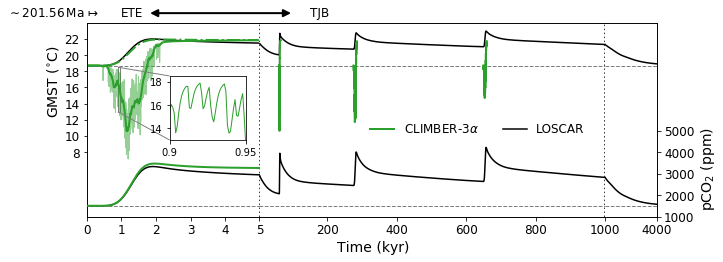

In [16]:
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
#from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

fig7=plt.figure(figsize=(10,3.75)) 
plt.clf()
gs = GridSpec(1, 3, width_ratios=[0.5,1,0.15])
ax1 = plt.subplot(gs[0]) #, ymargin=5
ax2 = plt.subplot(gs[1]) #sharey=ax1
ax3 = plt.subplot(gs[2]) 

#ax2=fig7.add_subplot(121) 
ax1_2=ax1.twinx()
#ax3=fig7.add_subplot(122, sharey=ax2) 
ax2_2=ax2.twinx()
ax3_2=ax3.twinx()
ax1.get_shared_y_axes().join(ax1, ax2, ax3)
ax1_2.get_shared_y_axes().join(ax1_2, ax2_2, ax3_2)

#ax2.tick_params(axis='y',labelleft=False)
ax2.tick_params(axis='y',labelleft=False, left=False)
ax1_2.tick_params(axis='y',labelright=False, right=False)
ax2_2.tick_params(axis='y',labelright=False, right=False)
ax3.tick_params(axis='y',labelleft=False, left=False)

#ax3_2.tick_params(axis='y',labelright=False)
#ax2_2.get_shared_y_axes().join(ax2_2, ax3_2)
ax1.spines['right'].set_visible(False); ax1_2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False); ax2_2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False); ax2_2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False); ax3_2.spines['left'].set_visible(False)
#ax3.spines['right'].set_visible(False); ax3_2.spines['right'].set_visible(False)
#years_geocarb_scaled=np.copy(years_geocarb)
#years_geocarb_scaled[200500:]=years_geocarb_scaled[200500]+years_geocarb_scaled[200500:]/40

#ax1.plot(years_geocarb_scaled, geocarb_out_df['pCO2'],'--', lw=2,c='k')
#ax2.plot(years_geocarb_scaled, geocarb_out_df['Tatm'],'--', lw=2,c='tab:blue')

l=spin ; u=spin+500;
#ax2.plot(years_geocarb[l:u], geocarb_out_df['pCO2'][l:u],'--', lw=2,c='k')
#ax2_2.plot(years_geocarb[l:u], geocarb_out_df['Tatm'][l:u],'--', lw=2,c='tab:cyan')
#ax2.set_xlim(years_geocarb[l],years_geocarb[u])

times=np.arange(0,5000,1)
times_long=np.arange(0,10000,1)
l1,=ax1_2.plot(times, pco2_c_1500ppm_5300GtC_5ka[500:], '-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=2, zorder=4, label=r'CLIMBER-3$\alpha$')
ax1.plot(times, ts_ann_pulse_c_1500ppm_5300GtC_5ka, '-.', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=2, zorder=4, label=r'T_Climber3$\alpha$')
ax1.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='1500ppm_5300GtC+50GtS', lw=2, zorder=4)
ax1.plot(times, ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw, c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=1, alpha=0.5, zorder=4)
#ax2_2.plot(times+start_2, ts_ann_pulse_c_2000ppm_5300GtC_5ka, '-', c=colors_paper_df.loc['pulse_c_2000ppm_5300GtC_5ka', 'color'], label='2000ppm_5300GtC', lw=2, zorder=3)
l2,=ax1_2.plot(loscar_years[0:50+1], loscar_pco2a[0:50+1],'-', lw=1.5,c='k', label='LOSCAR')
ax1.plot(loscar_years[0:50+1], loscar_temp[0:50+1],'-', lw=1.5,c='k', label=r'T_Loscar (simply scaled with $\mathsf{1/ln(pCO_2)}$)')
#$T_{1500ppm}+\frac{2.86^{\circ}C}{ln(2)}\frac{pCO_2}{1500ppm}$
#ax1_2.plot(loscar_new_years[0:50+1], loscar_new_pco2a[0:50+1],'-.', lw=2,c='tab:red')

l=spin+500 ; u=spin+100000-1 ;
#ax3.plot(years_geocarb[l:u], geocarb_out_df['pCO2'][l:u],'--', lw=2,c='k', label='Archer_pCO2')
#ax3_2.plot(years_geocarb[l:u], geocarb_out_df['Tatm'][l:u],'--', lw=2,c='tab:cyan', label='Archer_Temp')
#ax3.set_xlim(years_geocarb[l],years_geocarb[u])
ax2_2.plot(loscar_years[50:], loscar_pco2a[50:],'-', lw=1.5,c='k')
ax2.plot(loscar_years[50:], loscar_temp[50:],'-', lw=1.5,c='k')
#ax2_2.plot(loscar_new_years[50:], loscar_new_pco2a[50:],'-.', lw=2,c='tab:red', label='Loscar_new_pCO2')
#ax3.plot(times+start_2, pco2_c_2000ppm_5300GtC_5ka[500:], '-', c='k', label='Climber_pCO2', lw=2, zorder=4)
#ax3_2.plot(times+start_2, ts_ann_pulse_c_2000ppm_5300GtC_5ka, '-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='Climber_Temp', lw=2, zorder=4)
#ax3.plot(times+start_2, pco2_cs_2000ppm_5300GtC_5ka[500:], '-', c='k', label='Climber_pCO2', lw=2, zorder=4)
#ax3_2.plot(times+start_2, ts_ann_pulse_corr_cs_2000ppm_5300GtC_125GtS_5ka, '-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='Climber_Temp', lw=2, zorder=4)
#ax3_2.plot(times_long+start_2, ts_ann_pulse_corr_cs_1500ppm_5300GtC_250GtS_12ka, '-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], label='Climber_Temp', lw=2, zorder=4)
ax2.plot(times+start_2, ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=2, zorder=4)[0]


ll1=len(ts_ann_pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka)
ll2=len(ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka)

ax2.plot(times_long[:ll1]+start_3, ts_ann_pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=2, zorder=4)
#ax2.plot(times+start_4, ts_ann_pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=2, zorder=4)
ax2.plot(times_long[:ll2]+start_4, ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=2, zorder=4)


ax3_2.plot(loscar_years_ext[:], loscar_pco2a_ext[:],'-', lw=1.5,c='k')
ax3.plot(loscar_years_ext[:], loscar_temp_ext[:],'-', lw=1.5,c='k')

#ax1.set_xlim(0,1000000/30)
ax1.set_ylim(0,24)
ax1.set_ylabel(r'GMST ($\mathsf{^{\circ}C}$)', fontsize=14, position=(0.5,0.7))
ax1.set_yticks([8,10,12,14,16,18,20,22])
ax1.set_yticklabels([8,10,12,14,16,18,20,22])
#ax1.yaxis.label.set_color('tab:blue')
ax1.set_xlim(0,5000)
ax1.set_xticks([0,1000,2000,3000,4000])
ticks = ax1.get_xticks()//10**3
#ax1.set_xticklabels(ticks.astype(int))
ax1.set_xticklabels(['0','1','2','3','4'])
ax1_2.set_ylim(1000,10000)
#ax1_2.set_xticks([0,1000,2000,3000,4000])
ax1_2.axvline(x=5000, c='k', ls=':')
ax2_2.axvline(x=1000000, c='k', ls=':')
ax1.axhline(y=ts_ann_pulse_c_1500ppm_5300GtC_5ka[0], c='tab:grey', ls='--', lw=1)
ax2.axhline(y=ts_ann_pulse_c_1500ppm_5300GtC_5ka[0], c='tab:grey', ls='--', lw=1)
ax3.axhline(y=ts_ann_pulse_c_1500ppm_5300GtC_5ka[0], c='tab:grey', ls='--', lw=1)
ax1_2.axhline(y=pco2_c_1500ppm_5300GtC_5ka[500], c='tab:grey', ls='--', lw=1)
ax2_2.axhline(y=pco2_c_1500ppm_5300GtC_5ka[500], c='tab:grey', ls='--', lw=1)
ax3_2.axhline(y=pco2_c_1500ppm_5300GtC_5ka[500], c='tab:grey', ls='--', lw=1)

#axins2 = inset_axes(ax1, width="35%", height="35%", loc='center right')
axins2 = inset_axes(ax1, width="100%", height="100%", loc='lower left',bbox_to_anchor=(.45, .37, .44, .33), bbox_transform=ax1.transAxes)
#axins2 = zoomed_inset_axes(ax1, 1, loc='center right')  # zoom = 6 , aspect=5
#yr_l=1300; yr_u=1350;
yr_l=900; yr_u=yr_l+50;
axins2.plot(times[yr_l:yr_u+1], ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw[yr_l:yr_u+1], c='tab:green', lw=1)
#axins2.plot(times[1550:1600], ts_ann_pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka_raw[1550:1600], c='tab:green')
mark_inset(ax1, axins2, loc1a=2, loc2a=3, loc1b=2, loc2b=3, fc="none", ec="0.5")
#axins2.tick_params(axis='y',labelleft=False)
#axins2.tick_params(axis='x',labelbottom=False)
axins2.set_xlim([yr_l,yr_u])
#axins2.set_ylim([10,18])
axins2.set_ylim([13,18.5])
axins2.set_xticks([yr_l,yr_u])
axins2.set_xticklabels([yr_l/1000, yr_u/1000])
#axins2.set_yticks([10,12,14,16,18])

#ax2.set_xlabel('Time (kyr)')
ax2.set_ylim(0,24)
#ax2.set_xlabel('Time (kyr) +$\,$201.56$\,$Ma', fontsize=14, position=(0.33,0.5))
ax2.set_xlabel('Time (kyr)', fontsize=14, position=(0.33,0.5))

#ax2.legend(loc='lower right')
#ax2_2.legend(loc='lower left')
ax3_2.set_ylabel(r'$\mathsf{pCO_2}$ (ppm)', fontsize=14, position=(0.5,0.25))
ax2_2.set_xlim(5000,1000000)
ax2_2.set_xticks([5000,200000,400000,600000,800000])
ticks = ax2_2.get_xticks()//10**3
ax2_2.set_xticklabels(ticks.astype(int))
#ax2_2.set_yticks([1000,2000,3000,4000,5000])

ax3_2.set_xlim(1000000,4000000)
ax3_2.set_xticks([1000000,4000000])
ticks = ax3_2.get_xticks()//10**3
ax3_2.set_xticklabels(ticks.astype(int))
ax3_2.set_yticks([1000,2000,3000,4000,5000])

ax1.tick_params(labelsize=12)
ax2_2.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3_2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)


#ax1.annotate('', xy=(0, 1.1), xycoords='axes fraction', xytext=(1.5, 1.1), arrowprops=dict(arrowstyle="<->", color='b'))
#ax1.text(-0.25,-0.07,r'',transform=ax1.transAxes,fontsize=12, horizontalalignment='center')
#arrow=matplotlib.patches.FancyArrowPatch(posA=(0, 24),posB=(5000,24),arrowstyle=matplotlib.patches.ArrowStyle.CurveFilledB(head_length=.15, head_width=.03), lw=2.5, mutation_scale=100, edgecolor='k', facecolor='k') #, shrinkA=10                    #
#ax1.add_patch(arrow)
#ax2.arrow(105, -15.5, 55, 9, fc='k', ec='k', alpha=1, width=0.25, head_width=1, head_length=10,length_includes_head=True)
#ax1.text(-120., -1.975, '201.56$\,$Ma$\,-$', rotation=0, fontsize=12, horizontalalignment='right')
#ax1.text(-125., -1.96, '201.56\n Ma$\,-$', rotation=0, fontsize=12, horizontalalignment='right')
ax1.text(-0.46,1.03,r'$\sim$201.56$\,$Ma$\,$$\mapsto$',transform=ax1.transAxes,fontsize=12)
#ax1.text(-125., -1.96, '201.56\n Ma$\,-$', rotation=0, fontsize=12, horizontalalignment='right')
ax1.text(1000, 24.75, 'ETE', rotation=0, fontsize=12) 
ax2.text(150000, 24.75, 'TJB', rotation=0, fontsize=12) 

ax0tr = ax1.transData # Axis 0 -> Display
ax1tr = ax2.transData # Axis 1 -> Display
figtr = fig7.transFigure.inverted() # Display -> Figure
# 2. Transform arrow start point from axis 0 to figure coordinates
ptB = figtr.transform(ax0tr.transform((1700, 25.75))) #25.8
# 3. Transform arrow end point from axis 1 to figure coordinates
ptE = figtr.transform(ax1tr.transform((50700., 25.75))) #25.8
# 4. Create the patch
arrow = matplotlib.patches.FancyArrowPatch(
    ptB, ptE, transform=fig7.transFigure,  # Place arrow in figure coord system
    fc = "k", arrowstyle='<|-|>', alpha = 1,
    mutation_scale = 15.,lw=2) #, connectionstyle="arc3,rad=0.2"
fig7.patches.append(arrow)

#linelabels=[r'pCO2_Climber3$\alpha$','pCO2_Loscar',r'T_Climber3$\alpha$','T_Loscar']
#ax2.legend(handles=[l1,l2], loc='center right', fontsize=12, ncol=2, frameon=False)
ax2.legend(handles=[l1,l2], bbox_to_anchor=(0.53,0.4,0.2,0.1),loc='center', fontsize=12, ncol=2, frameon=False)
#ax2.legend(bbox_to_anchor=(0.615,-0.034,0.4,0.6),loc='center', fontsize=10, ncol=1, labelspacing=0.25, frameon=False)


plt.tight_layout(w_pad=-1.9) #w_pad=-0.6
fig7.savefig('./plot_pdf_files/Fig5_loscar_climber_synthesis_rev.pdf')

### Graphical Abstract

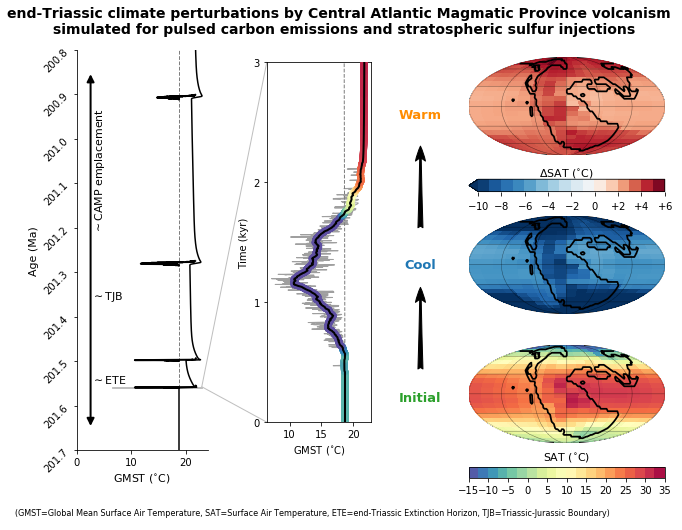

In [24]:
#var_scat=lonlat_paleo_norian_sel
#var_scat2=lonlat_paleo_rhaetian_sel
with open('../climber/continental_mask.pickle', 'rb') as f:  
    continental_mask = pickle.load(f, encoding='latin1') #Python3: , encoding='latin1'

fig=plt.figure(figsize=(10,7.5))
plt.clf()
gs = GridSpec(7, 4,height_ratios=[0.15,1,0.11,1,1,0.1,0.1], width_ratios=[0.45,0.45,0.1,0.675]) #,1

ax0=plt.subplot(gs[0,:]); ax0.axis('off')
ax1 = plt.subplot(gs[1:-2,0]) #, ymargin=5
#ax11 = plt.subplot(gs[1:-1,1]) #sharey=ax1

#ax112 = ax11.twiny()

ax21 = plt.subplot(gs[4,3])
ax22 = plt.subplot(gs[3,3])
ax23 = plt.subplot(gs[1,3])

ax24 = plt.subplot(gs[2,3]) #; ax24.axis('off')
ax25 = plt.subplot(gs[5,3])

# ax31 = plt.subplot(gs[3,4])
# ax32 = plt.subplot(gs[2,4])
# ax33 = plt.subplot(gs[0,4])

# ax34 = plt.subplot(gs[1,4])
# ax35 = plt.subplot(gs[4,4])

ax_text = plt.subplot(gs[1:-1,2]); ax_text.axis('off')
#ax_text1 = plt.subplot(gs[0,2]); ax_text1.axis('off')
#ax_text2 = plt.subplot(gs[2,2]); ax_text2.axis('off')
#ax_text3 = plt.subplot(gs[3,2]); ax_text3.axis('off')
#ax21.grid(linestyle=':', zorder=0)
ax_anno = plt.subplot(gs[-1,:]); ax_anno.axis('off')

lim_l=-10.
lim_u=6.
mycmap = jplt.shiftedColorMap(matplotlib.cm.RdBu_r, midpoint=abs(lim_l)/(lim_u+abs(lim_l)))
#mycmap = jplt.shiftedColorMap(matplotlib.cm.RdBu_r, stop=(abs(lim_l)+lim_u)/(2.*abs(lim_l)))

times=np.arange(0,5000,1)  
#times=np.arange(0,5000,1)
times_long=np.arange(0,10000,1)
#ax1.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka[0:3000],times[0:3000],'-', c='tab:green', lw=2) 
#ax1.plot(ts_ann_pulse_control_1500ppm[0:3000],times[0:3000], '--', c='tab:grey', zorder=1)
#ax1.plot(loscar_pco2a[:],201.56-(loscar_years[:]/10**6),'-', lw=1.5,c='k') #
ax1.plot(loscar_temp[:],201.56-(loscar_years[:]/10**6),'-', lw=1.5,c='k')
ax1.plot(loscar_temp_ext[:],201.56-1-((loscar_years_ext[:]/10**6)-1),'-', lw=1.5,c='k')
ax1.plot(np.repeat(18.7,50),201.56+np.linspace(0,0.5,50),'-', lw=1.5,c='k')
ax1.plot(np.repeat(18.7,100),201.56-np.linspace(0,0.8,100),'--', lw=1.0,c='tab:gray')

ax1.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka,201.56-(times)/10**6, '-', c='k', lw=2, zorder=4)[0]
ax1.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka,201.56-(times+start_2)/10**6, '-', c='k', lw=2, zorder=4)[0]
#colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color']

ll1=len(ts_ann_pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka)
ll2=len(ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka)

ax1.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_500GtS_12ka,201.56-(times_long[:ll1]+start_3)/10**6, '-', c='k', lw=2, zorder=4)
#ax2.plot(times+start_4, ts_ann_pulse_corr_cs_1500ppm_5300GtC_50GtS_5ka,'-', c=colors_paper_df.loc['pulse_c_1500ppm_5300GtC_5ka', 'color'], lw=2, zorder=4)
ax1.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_250GtS_12ka,201.56-( times_long[:ll2]+start_4)/10**6,'-', c='k', lw=2, zorder=4)

#ax1.plot(ts_ann_pulse_corr_cs_1500ppm_5300GtC_250GtS_12ka[ll1:],201.56-(times_long[ll1:]+start_3)/10**6, '-', c='tab:gray', lw=2, zorder=4)
#ax1.plot(ts_ann_pulse_corr_cs_1500ppm_5300GtC_125GtS_12ka[ll2:],201.56-(times_long[ll2:]+start_4)/10**6, '-', c='tab:gray', lw=2, zorder=4)

#ax1.scatter(pco2_schaller2011[:,1],pco2_schaller2011[:,0]) #,'-', lw=1.5,c='k'
#ax1.scatter(pco2_schaller2012[:,1],pco2_schaller2012[:,0])
##ax1.set_aspect(0.04)
##ax1.set_ymargin(0.1)
##ax1.axis('off')
ax1.spines['right'].set_visible(False)
##ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
##ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlim([0,24])
ax1.set_ylim([201.7,200.8])
#ax1.set_xticks([5,10,15,20,25])
for tick in ax1.get_yticklabels():
    tick.set_rotation(45)
ax1.set_xlabel(r'GMST ($\mathsf{^{\circ}C}$)', fontsize=11)
ax1.set_ylabel(r'Age (Ma)', fontsize=11)

axins3 = inset_axes(ax1, width="100%", height="100%", loc=2,bbox_to_anchor=(1.3, 0.12, 0.8, .9),borderpad=2, bbox_transform=ax1.transAxes)
axins3.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka[0:3000],201.56-times[0:3000]/10**6, '-', c='k', label='1500ppm_5300GtC+50GtS', lw=2, zorder=4)
axins3.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw[0:3000],201.56-times[0:3000]/10**6,  c='tab:gray', lw=1, alpha=0.75, zorder=2)
axins3.plot(ts_ann_pulse_control_1500ppm[0:3000],201.56-times[0:3000]/10**6, '--',lw=1.0, c='tab:grey', zorder=1)
axins3.scatter(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka[0:3000],201.56-times[0:3000]/10**6,c=ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka[0:3000], cmap='Spectral_r',zorder=3, vmin=18,vmax=22)
axins3.set_ylim([201.56,201.557])
axins3.set_yticks([201.56,201.559,201.558,201.557])
axins3.set_yticklabels(['0','1','2','3'])
axins3.set_ylabel('Time (kyr)')
axins3.set_xticks([10,15,20])
axins3.set_xlabel('GMST ($\mathsf{^{\circ}C}$)')
mark_inset(ax1, axins3, loc1a=2, loc2a=3, loc1b=1, loc2b=4, fc="none", ec="0.75") #, ec="0.5"

# ax11.plot(ts_ann_pulse_control_1500ppm[0:3000],times[0:3000], '--', c='tab:grey', zorder=1)
# ax11.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka,times, '-', c='k', label='1500ppm_5300GtC+50GtS', lw=2, zorder=4)
# ax11.plot(ts_ann_pulse_rev_cs_1500ppm_5300GtC_125GtS_5ka_raw,times,  c='tab:gray', lw=1, alpha=0.5, zorder=4)

#ax11.plot(eta_steric[0:3000],times[0:3000], '-', c='k', zorder=4, lw=2)
#ax11.plot(eta_steric_control_1500ppm[0:3000],times[0:3000], '--', c='tab:grey', zorder=1)
##ax11.set_aspect(0.04*((1.5-(-1.5))/(25-5)))

# ax11.spines['right'].set_visible(False)
# #ax11.spines['left'].set_visible(False)
# ax11.spines['top'].set_visible(False)
# #ax11.axes.get_yaxis().set_visible(False)
# ax11.set_xlim([8,24])
# ax11.set_ylim([-100,3050])
# #ax11.set_xticks([-1.5,0,1.5])
# #ax11.set_xticklabels(['$-1.5$','$0$','$+1.5$'])
# ax11.set_xlabel('GMST ($\mathsf{^{\circ}C}$)', fontsize=11)
# ax11.set_ylabel('Time (years)', fontsize=11)
# ax11.xaxis.label.set_color('k')
# for tick in ax11.get_yticklabels():
#     tick.set_rotation(45)

# ax11.set_zorder(10)
# ax11.patch.set_visible(False)
# ax112 = ax11.twiny()

# ax112.plot(glb_over[0:3000],times[0:3000], '-', c='tab:blue', zorder=3, lw=2) #c='teal'
# ax112.plot(glb_over_c[0:3000],times[0:3000], '-.', c='tab:blue', zorder=3, lw=2)
# ##ax112.set_aspect(0.04*((1.5-(-1.5))/(25-5))*(6-1/(25-5)), adjustable='box-forced')
# ax112.spines['right'].set_visible(False)
# ax112.spines['left'].set_visible(False)
# ax112.spines['bottom'].set_visible(False)
# ax112.axes.get_yaxis().set_visible(False)
# ax112.set_xlim([12,40])
# ax112.set_xticks([20,30,40])
# ax112.set_ylim([-100,3050])
# ax112.set_xlabel('Overturning (Sv)', fontsize=11) #Average Meridional #,fontweight='bold'
# ax112.xaxis.label.set_color('tab:blue')

latso, lonso, xo, yo=jan.grid_gen(region='ocean', cell='T')

xpa, ypa=jan.grid_gen(region='atmo', cell='p')[2:4]
xua,yua=jan.grid_gen(region='atmo', cell='u')[2:4]
xta,yta=jan.grid_gen(region='atmo', cell='T')[2:4]

xpo, ypo=jan.grid_gen(region='ocean', cell='p')[2:4] 
xuo,yuo=jan.grid_gen(region='ocean', cell='u')[2:4]
xto,yto=jan.grid_gen(region='ocean', cell='T')[2:4]           

xtac,ytac=jan.grid_gen(region='atmo', cell='T')[2:4]
xtoc,ytoc=jan.grid_gen(region='ocean', cell='T')[2:4]

x_1deg, y_1deg=jan.grid_gen(region='atmo_1deg', cell='p')[2:4] 
xu_1deg,yu_1deg=jan.grid_gen(region='atmo_1deg', cell='u')[2:4]
xt_1deg,yt_1deg=jan.grid_gen(region='atmo_1deg', cell='T')[2:4]

for axi in [ax21, ax22, ax23]: #, ax31, ax32, ax33
    m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0, ax=axi)
    m.drawmapboundary()  
    m.drawparallels(np.arange(-90.,120.,30.), linewidth=0.5)
    m.drawmeridians(np.arange(0.,420.,60.), linewidth=0.5)

xpam, ypam = m(xpa, ypa)
xom, yom = m(xo, yo)
xpom, ypom = m(xpo, ypo)

#xtm,ytm=m(xt,yt)   
#xtcm,ytcm=m(xtc,ytc)

#x_scat, y_scat=m(var_scat[:,0],var_scat[:,1])
#x_scat2, y_scat2=m(var_scat2[:,0],var_scat2[:,1])

a21=ax21.pcolor(xpam, ypam, ts_ini_1500ppm, cmap='Spectral_r',vmin=-15, vmax=35)
ax21.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')
cbar=fig.colorbar(mappable=a21, cax=ax25, orientation='horizontal', boundaries=np.arange(-15,35+2.5,2.5), ticks=np.arange(-15,35+2.5,5)) #, boundaries=np.arange(-11,6+1,1) drawedges=True, #cbar.dividers.set_color('white')  , pad=-0.5 ax=[ax21, ax22, ax23, ax24], c
#cbar.ax.set_xticklabels(['$-10$','$-8$','$-6$','$-4$','$-2$','$0$','$+2$', '$+4$', '$+6$'])
cbar.set_label(r'SAT ($\mathsf{^{\circ}C}$)', labelpad=-45, fontsize=11)
cbar.ax.tick_params(labelsize=10);


a22=ax22.pcolor(xpam, ypam, ts_diff_maxcool, cmap=mycmap, vmin=lim_l, vmax=lim_u) # , cmap=mycmap
ax22.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')

a23=ax23.pcolor(xpam, ypam, ts_diff_maxwarm, cmap=mycmap, vmin=lim_l, vmax=lim_u) #, vmin=1.5, vmax=6
ax23.contour(xom,yom,continental_mask,levels=[0.5], linewidths=1.75, colors='k')
cbar=fig.colorbar(mappable=a23, cax=ax24, orientation='horizontal', extend='min', boundaries=np.arange(-11,6+1,1)) #, boundaries=boundaries, ticks=ticks drawedges=True, #cbar.dividers.set_color('white')  , pad=-0.5 ax=[ax21, ax22, ax23, ax24], c
cbar.ax.set_xticklabels(['$-10$','$-8$','$-6$','$-4$','$-2$','$0$','$+2$', '$+4$', '$+6$'])
cbar.set_label(r'$\Delta$SAT ($\mathsf{^{\circ}C}$)', labelpad=-45, fontsize=11)
#cbar.set_label("%s (%s)" % (varname, units), fontsize=12) , \
#           shrink=0.7 , pad=0.06
cbar.ax.tick_params(labelsize=10);



ax_text.text(0.5,0.18,'Initial',fontsize=13, horizontalalignment='center', color='tab:green',fontweight='bold')
ax_text.text(0.5,0.49,'Cool',fontsize=13, horizontalalignment='center', color='tab:blue',fontweight='bold')
ax_text.text(0.5,0.84,'Warm',fontsize=13, horizontalalignment='center', color='darkorange',fontweight='bold')

arrow=matplotlib.patches.FancyArrowPatch(posA=(0.5,0.25),posB=(0.5,0.45),arrowstyle=matplotlib.patches.ArrowStyle.Fancy(head_length=.3, head_width=.2, tail_width=.1), mutation_scale=50, edgecolor='k', facecolor='k') #, shrinkA=10                    #
ax_text.add_patch(arrow)
arrow2=matplotlib.patches.FancyArrowPatch(posA=(0.5,0.58),posB=(0.5,0.78),arrowstyle=matplotlib.patches.ArrowStyle.Fancy(head_length=.3, head_width=.2, tail_width=.1), mutation_scale=50, edgecolor='k', facecolor='k') #, shrinkA=10                    #
ax_text.add_patch(arrow2)
#ax_text.arrow(0.5, 0.25, 0, 0.2,fc='k', ec='k', alpha=1, width=0.05, head_width=0.2, head_length=0.05,length_includes_head=True)
#ax_text.arrow(0.5, 0.58, 0, 0.2,fc='k', ec='k', alpha=1, width=0.05, head_width=0.2, head_length=0.05,length_includes_head=True)

ax0.text(0.45,0.0,'end-Triassic climate perturbations by Central Atlantic Magmatic Province volcanism \n simulated for pulsed carbon emissions and stratospheric sulfur injections',fontweight='bold',transform=ax0.transAxes,fontsize=14, ha='center')
#ax1.text(-0.35,1.01,'(a)',transform=ax1.transAxes,fontsize=11)
#ax11.text(-0.35,1.01,'(b)',transform=ax11.transAxes,fontsize=11)

#ax21.text(0,0.85,'(c)',transform=ax21.transAxes,fontsize=11)
#ax22.text(0,0.85,'(d)',transform=ax22.transAxes,fontsize=11)
#ax23.text(0,0.85,'(e)',transform=ax23.transAxes,fontsize=11)

arrow = matplotlib.patches.FancyArrowPatch(
    posA=(2.5, 201.65), posB=(2.5,200.85), #transform=fig7.transFigure,  # Place arrow in figure coord system
    fc = "k", arrowstyle='<|-|>', alpha = 1,
    mutation_scale = 15.,lw=2) #, connectionstyle="arc3,rad=0.2"
#fig7.patches.append(arrow)
#arrow=matplotlib.patches.FancyArrowPatch(posA=(102, -15.75),posB=(165,-6.0),arrowstyle=matplotlib.patches.ArrowStyle.CurveFilledB(head_length=.15, head_width=.03), lw=2.5, mutation_scale=100, edgecolor='k', facecolor='k') #, shrinkA=10                    #
ax1.add_patch(arrow)
ax1.text(3.0, 200.95,'$\sim$CAMP emplacement',fontsize=11, rotation=90) #,transform=ax1.transAxes
ax1.text(2.5, 201.56-0.01,'$\sim$ETE',fontsize=11) #'end-Triassic \nextinction horizon'
ax1.text(2.5, 201.36,'$\sim$TJB',fontsize=11) #'Triassic-Jurassic \nboundary'

#ax23.text(0.5,1.15,'Surface Air Temperature \n & Oxygen Minima',transform=ax23.transAxes,fontsize=14, horizontalalignment='center')

ax_anno.text(0.4,-0.8,'(GMST=Global Mean Surface Air Temperature, SAT=Surface Air Temperature, ETE=end-Triassic Extinction Horizon, TJB=Triassic-Jurassic Boundary)',transform=ax_anno.transAxes,fontsize=8, ha='center')

plt.tight_layout(h_pad=-1.75) #h_pad=-4.25, w_pad=-2

fig.savefig('./plot_pdf_files/GraphicalAbstract.pdf',bbox_inches='tight', pad_inches=0.05, dpi=900)
